# Выявление профилей потребления покупателей интернет-магазина для дома и быта «Пока все ещё тут»

**Исходные данные**:
датасет с транзакциями интернет-магазина товаров для дома и быта «Пока
все ещё тут».

date - дата совершения действия;  
customer_id - id пользователя;  
order_id - id заказа;  
product - наименование товара в заказе;  
quantity - количество товара в заказе;  
price - цена за единицу товара.  

**Цели исследования:**  
- произвести исследовательский анализ данных;
  - рассмотреть динамику медианного чека;  
  - рассмотреть динамику медианной выручки;
  - оценить лояльность клиентов
  - произвесть категоризацию товаров и проанализировать указанные метрики для категорий;
- сегментировать покупателей на основе истории их покупок;
- проверить статистические гипотезы о равенстве между сегментированными группами;
- сделать выводы по полученным показателям и дать рекомендации по улучшению ключевых метрик.

### Импорт библиотек 

In [1]:
import pandas as pd

In [2]:
import seaborn as sns 

In [3]:
import matplotlib.pyplot as plt 

In [4]:
import plotly.express as px

In [5]:
from datetime import datetime as dt

In [6]:
import nltk

In [7]:
from nltk import word_tokenize

In [8]:
from nltk.probability import FreqDist

In [9]:
from abc_analysis import abc_analysis

In [10]:
import numpy as np

In [11]:
from scipy import stats as st

### Предобработка данных

In [12]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/ecom_dataset_upd.csv')

Выведим первые 10 строк датасета и посмотрим данные о нем: 

In [13]:
data

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0
...,...,...,...,...,...,...
7469,2020013021,63208953-a8e4-4f77-9b47-3a46e7b72eee,104002,томата (помидор) Черниченский черри № 116 сорт...,2,38.0
7470,2020013022,d99d25f1-4017-4fcd-8d29-c580cc695a1a,107336,Дендробиум Санок Анна Грин 1 ствол d-12 см,1,869.0
7471,2020013102,2c9bd08d-8c55-4e7a-9bfb-8c56ba42c6d6,106336,Подставка для обуви резиновая Attribute 80x40 ...,1,354.0
7472,2020013112,cdd17932-623e-415f-a577-3b31312fd0e2,102002,Тагетис крупноцветковый рассада однолетних цве...,1,128.0


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7474 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         7474 non-null   int64  
 1   customer_id  7474 non-null   object 
 2   order_id     7474 non-null   int64  
 3   product      7474 non-null   object 
 4   quantity     7474 non-null   int64  
 5   price        7474 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 350.5+ KB


#### Форматирование данных

Приведем данные в столбцах customer_id и product к строковому формату и создадим новый столбец для форматированной даты:

In [15]:
data['customer_id'] = data['customer_id'].astype('str')

In [16]:
data['product'] = data['product'].astype('str')

In [17]:
data['date_full'] = pd.to_datetime(data['date'], format='%Y%m%d%H')

In [18]:
data['date_full'] = data['date_full'].astype('datetime64')

#### Приведение данных к нижнему регистру

приведем данные столбцов customer_id и product к нижнему регистру для исключения исключения неявного дублирования из-за разных регистров:

In [19]:
data['product'] = data['product'].str.lower()

In [20]:
data['customer_id'] = data['customer_id'].str.lower()

In [21]:
data['date_full'] = data['date_full'].astype('datetime64')

#### Проверка на пропуски в данных

In [22]:
data.isna().sum()

date           0
customer_id    0
order_id       0
product        0
quantity       0
price          0
date_full      0
dtype: int64

Пропуски в данных отсутсвуют во всех столбацах

#### Проверка на явные дубликаты

In [23]:
data.duplicated().sum()

0

Явные дубликаты отсутствуют

#### Проверка на неявные дубликаты

Проверим на неявные дубликаты в столбцах customer_id, order_id, product 

In [24]:
data.duplicated(subset = ['customer_id', 'order_id', 'product']).sum()

1886

Найдено 1886 неявных дубликатов, что сотавляет ~25% от всех данных. Выведим их список:

In [25]:
data[data.duplicated(subset = ['customer_id', 'order_id', 'product'])]

,date,customer_id,order_id,product,quantity,price,date_full
58,2018100218,b731df05-98fa-4610-8496-716ec530a02c,68474,доска гладильная eurogold professional 130х48 ...,1,3299.0,2018-10-02 18:00:00
59,2018100219,b731df05-98fa-4610-8496-716ec530a02c,68474,доска гладильная eurogold professional 130х48 ...,1,3299.0,2018-10-02 19:00:00
60,2018100220,b731df05-98fa-4610-8496-716ec530a02c,68474,доска гладильная eurogold professional 130х48 ...,1,3299.0,2018-10-02 20:00:00
63,2018100304,b731df05-98fa-4610-8496-716ec530a02c,68474,доска гладильная eurogold professional 130х48 ...,1,3299.0,2018-10-03 04:00:00
94,2018100413,32de7df8-8d4f-4c84-a7b9-c41d00dd83ba,68522,эвкалипт гунни d-17 см h-60 см,1,1409.0,2018-10-04 13:00:00
...,...,...,...,...,...,...,...
6706,2019102810,57cc80a2-2610-4eef-9457-e7c3bf0c72f0,70960,сумка-тележка 2-х колесная gimi argo красная,1,1087.0,2019-10-28 10:00:00
6711,2019102821,cb65d08a-dae7-4890-aef0-bb9f79055e02,73108,мирт d-9 см h-15 см,1,134.0,2019-10-28 21:00:00
6728,2019103100,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,73136,"таз пластмассовый со стиральной доской (иж), 1...",1,397.0,2019-10-31 00:00:00
6729,2019103102,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,73136,"таз пластмассовый со стиральной доской (иж), 1...",1,397.0,2019-10-31 02:00:00


Дубликаты представляют из разнесенные по времени заказы одного пользователя 

Посчитаем какое количество разнесенных заказов по времени приходится на одного такого пользователя:

In [26]:
duplicates = data[data.duplicated(subset = ['customer_id', 'order_id', 'product'])] 
#передадим выборку дубликатов переменной duplicates

In [27]:
dup_sum =duplicates.groupby(['customer_id'],as_index = False) \
.agg({'order_id':'count'}) #сгрупируем дубликты по пользователю и посчитаем количество заказов разнесенных во времени
dup_sum.describe() #выведим описание значений 


,order_id
count,255.000000
mean,7.396078
std,56.041218
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,876.000000


**Вывод:**  
75% процентов пользователей в этой выборке имеют менее 2 заказов.Оставив данные о последнем заказе по времени для каждго пользователя мы потеряем из этой выборки ~ 50 процентов данных и ~ 12,5% данных исходного датасета.  
Убрав данные о дублированных заказах немного исказим данные о времени покупок и суммрной выручке,но мы получим более точные данные по другим метрикам(метрики на одного покупателя).

Уберем дублирующие заказы из датасета, оставив последние по времени для каждого пользователя, как скорее всего точно правильно оформленные.

In [28]:
data_filt = data.drop_duplicates(subset = ['customer_id', 'order_id', 'product'], keep = 'last').reset_index(drop = True)
data_filt.head(10)

,date,customer_id,order_id,product,quantity,price,date_full
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,2018-10-01 00:00:00
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194.0,2018-10-01 00:00:00
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.0,2018-10-01 00:00:00
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.0,2018-10-01 00:00:00
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.0,2018-10-01 00:00:00
5,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,шеффлера лузеана d-9 см,1,164.0,2018-10-01 00:00:00
6,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,юкка нитчатая d-12 см h-25-35 см,1,134.0,2018-10-01 00:00:00
7,2018100108,375e0724-f033-4c76-b579-84969cf38ee2,68479,настенная сушилка для белья gimi brio super 100,1,824.0,2018-10-01 08:00:00
8,2018100108,6644e5b4-9934-4863-9778-aaa125207701,68478,"таз пластмассовый 21,0 л круглый ""водолей"" с61...",1,269.0,2018-10-01 08:00:00
9,2018100109,c971fb21-d54c-4134-938f-16b62ee86d3b,68480,чехол для гладильной доски colombo persia beig...,1,674.0,2018-10-01 09:00:00


Проверим разных пользователей входящих в один заказ:

In [29]:
common_customer_order = data_filt.groupby('order_id', as_index = False) \
.agg({'customer_id':'nunique'})\
.reset_index(drop = True)
common_customer_order = common_customer_order.query('customer_id > 1')
common_customer_order 

,order_id,customer_id
248,14872,2
516,68785,2
797,69283,2
817,69310,2
832,69345,2
862,69410,2
902,69485,3
933,69531,2
1066,69833,2
1200,70114,2


Выведем заказы с разными пользователями

In [30]:
filtered_orders = data_filt[data_filt['order_id'].isin(common_customer_order['order_id'])].sort_values(by = 'price')
filtered_orders 

,date,customer_id,order_id,product,quantity,price,date_full
4222,2019080215,da6f7bf7-f699-4046-a4dd-cab0c27debcb,72188,муляж персики мини полиуретан d-6 см,1,22.0,2019-08-02 15:00:00
4226,2019080313,55b8d928-77f8-40fc-a2e9-08424d13b0e4,72188,муляж персики мини полиуретан d-6 см,1,22.0,2019-08-03 13:00:00
1095,2018121820,caaa3f41-c9ab-4e3d-8b75-94e1d3a8d7b4,69410,муляж желудь 2 шт,3,22.0,2018-12-18 20:00:00
1076,2018121714,4ea06f66-0876-4dec-8d14-ea994ffe435f,69410,муляж желудь 2 шт,3,22.0,2018-12-17 14:00:00
1512,2019020920,b827d1a8-5e5d-4a44-9813-2bd669471a73,70114,вешалка-плечики без эссенции цвет тёмно-розовы...,30,40.0,2019-02-09 20:00:00
...,...,...,...,...,...,...,...
4624,2019093009,07b63f16-aa4a-4acc-a7a5-af941fd4b0a9,72790,сушилка для белья потолочно-настенная gimi lif...,1,1424.0,2019-09-30 09:00:00
3353,2019051919,79162ad6-b2f0-491a-b3fb-2376c9001b63,71461,"коврик придверный с дизайном, из резины и коко...",1,1642.0,2019-05-19 19:00:00
3357,2019052008,9ecc5887-b4d4-4cea-b446-88748df71d9c,71461,"коврик придверный с дизайном, из резины и коко...",1,1642.0,2019-05-20 08:00:00
1901,2019030614,2273b174-e223-415a-9be1-49d19abea06e,69531,сумка-тележка хозяйственная rolser bab010 rojo...,1,4139.0,2019-03-06 14:00:00


Пользователи с разными id, но одинаковыми id заказа производили несколько раз один и тот же товар. Вероятно, это техническая ошибка. Оставим из этого множество пользователей которые сделали заказ позднее. 

In [31]:
filtered_orders_new = filtered_orders.drop_duplicates(subset = ['order_id'], keep = 'last')
filtered_orders_new

,date,customer_id,order_id,product,quantity,price,date_full
4226,2019080313,55b8d928-77f8-40fc-a2e9-08424d13b0e4,72188,муляж персики мини полиуретан d-6 см,1,22.0,2019-08-03 13:00:00
1076,2018121714,4ea06f66-0876-4dec-8d14-ea994ffe435f,69410,муляж желудь 2 шт,3,22.0,2018-12-17 14:00:00
1461,2019020520,673d44a3-9cec-4c2f-b0c6-9be4952ddc7c,70114,вешалка-плечики без эссенции цвет тёмно-розовы...,30,40.0,2019-02-05 20:00:00
3656,2019060509,34572907-a445-4b40-b1b6-fd0cbfa653b1,71054,вешалка-плечики без эссенции цвет тёмно-розовы...,10,43.0,2019-06-05 09:00:00
1429,2019020322,845d52ce-9420-4c44-b4b5-3fb55c792084,69310,"муляж груша желтый 9,5 см полиуретан",7,59.0,2019-02-03 22:00:00
4679,2019100720,2ac05362-3ca7-4d19-899c-7ba266902611,72845,муляж яблоко зеленый 9 см полиуретан,40,59.0,2019-10-07 20:00:00
3380,2019052102,4bd9c1e8-b2cc-4ec5-97eb-28d8f3c22d8d,71480,мята перечная шоколадная chocolate d-7 см h-10...,1,74.0,2019-05-21 02:00:00
1910,2019030707,d1bf7700-6afa-4297-9220-48e6aa0d7e2c,70631,искусственная композиция из цветов пластиковая...,1,74.0,2019-03-07 07:00:00
3843,2019062409,9897ccd6-9441-4886-b709-b06361fabf6c,14872,петуния махровая рассада однолетних цветов в к...,1,128.0,2019-06-24 09:00:00
3861,2019062509,11a9ee7f-c1af-48eb-ab82-bfe5dbc0ab02,71663,пеларгония розебудная prins nikolai укорененны...,1,134.0,2019-06-25 09:00:00


Перезапишем датафрейм с только удаляемыми пользователями

In [32]:
filtered_orders = filtered_orders.drop(index = filtered_orders_new.index) 

удалим ранее определенные строки с пользовтелями из общего датафрейма

In [33]:
data_filt = data_filt.drop(index = filtered_orders.index)


#### Добавление дополнительных столбцов с данными 

Добавим данные о дне недели заказа, месяце и часе заказа:

In [34]:
data_filt['month'] = data_filt['date_full'].dt.month 

In [35]:
data_filt['weekday'] = data_filt['date_full'].dt.weekday

In [36]:
data_filt['hour'] = data_filt['date_full'].dt.hour

In [37]:
data_filt['year'] = data_filt['date_full'].dt.year
data_filt.head(10)

,date,customer_id,order_id,product,quantity,price,date_full,month,weekday,hour,year
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,2018-10-01 00:00:00,10,0,0,2018
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194.0,2018-10-01 00:00:00,10,0,0,2018
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.0,2018-10-01 00:00:00,10,0,0,2018
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.0,2018-10-01 00:00:00,10,0,0,2018
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.0,2018-10-01 00:00:00,10,0,0,2018
5,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,шеффлера лузеана d-9 см,1,164.0,2018-10-01 00:00:00,10,0,0,2018
6,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,юкка нитчатая d-12 см h-25-35 см,1,134.0,2018-10-01 00:00:00,10,0,0,2018
7,2018100108,375e0724-f033-4c76-b579-84969cf38ee2,68479,настенная сушилка для белья gimi brio super 100,1,824.0,2018-10-01 08:00:00,10,0,8,2018
8,2018100108,6644e5b4-9934-4863-9778-aaa125207701,68478,"таз пластмассовый 21,0 л круглый ""водолей"" с61...",1,269.0,2018-10-01 08:00:00,10,0,8,2018
9,2018100109,c971fb21-d54c-4134-938f-16b62ee86d3b,68480,чехол для гладильной доски colombo persia beig...,1,674.0,2018-10-01 09:00:00,10,0,9,2018


### Исследовательский анализ данных

#### Анализ аномальных значений цены товаров и количество заказанных единиц

Проведем анализ аномальных значений представленных цен и количества товаров в представленных заказах

In [38]:
data_filt['quantity'].describe()

count    5551.000000
mean        2.586921
std        16.475227
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max      1000.000000
Name: quantity, dtype: float64

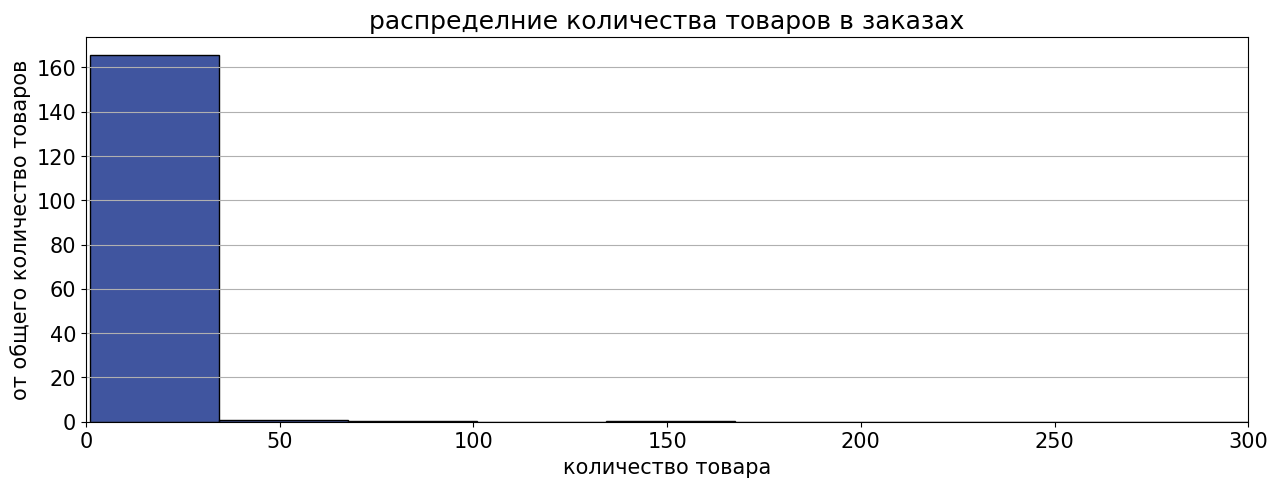

In [158]:
plt.figure(figsize = (15,5))
sns.histplot(data = data_filt, x = 'quantity', stat="frequency", bins = 10)
plt.xlabel('количество товара')
plt.title('распределние количества товаров в заказах')
plt.xlabel('количество товара')
plt.ylabel('от общего количество товаров')
plt.xlim(0, 300)
plt.grid(axis = 'y')
plt.show()

Почти сто процентов пользователей заказали менее 200 единиц товара в заказе, Рассмотрим в каких заказах было более двухсот единиц товара.

In [40]:
data_filt[data_filt['quantity'] > 200]

,date,customer_id,order_id,product,quantity,price,date_full,month,weekday,hour,year
3379,2019052021,5d189e88-d4d6-4eac-ab43-fa65a3c4d106,71478,муляж яблоко 9 см красное,300,51.0,2019-05-20 21:00:00,5,0,21,2019
3737,2019061107,146cd9bf-a95c-4afb-915b-5f6684b17444,71668,вешалки мягкие для деликатных вещей 3 шт шоколад,334,148.0,2019-06-11 07:00:00,6,1,7,2019
3805,2019061815,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"вантуз с деревянной ручкой d14 см красный, bur...",1000,675.0,2019-06-18 15:00:00,6,1,15,2019


Заказ на тысячу вантусов кажется подозрительным. Этот заказ представлет значительный выброс, так как превышает максимальный почти в три раза. Этот заказ следует удалить.

In [41]:
data_filt = data_filt[data_filt['quantity'] < 400]

In [42]:
data_filt['price'].describe()

count     5550.000000
mean       531.675330
std        974.584513
min          9.000000
25%         90.000000
50%        150.000000
75%        524.000000
max      14917.000000
Name: price, dtype: float64

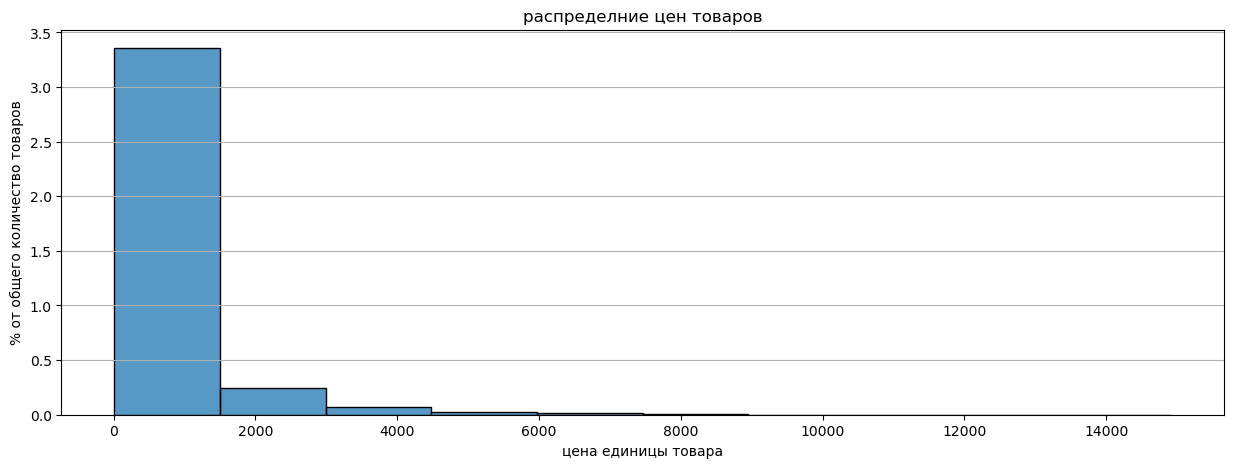

In [43]:
plt.figure(figsize = (15,5))
plt.rcParams.update({'font.size': 10})
sns.histplot(data = data_filt, x = 'price', stat="frequency", bins = 10)
plt.xlabel('количество товара')
plt.title('распределние цен товаров')
plt.xlabel('цена единицы товара')
plt.ylabel('% от общего количество товаров')
plt.grid(axis = 'y')
plt.show()

Товары стоймостью более 6000 тысяч представлены крайне малочисленно

#### Временные рамки данных

Рассмотрим в какие временные рамки входят данные:

In [44]:
f'минимальная дата заказа {data_filt["date_full"].min()}'

'минимальная дата заказа 2018-10-01 00:00:00'

In [45]:
f'максимальная дата заказа {data_filt["date_full"].max()}'

'максимальная дата заказа 2020-01-31 15:00:00'

In [46]:
percent_orders = data_filt.groupby('year', as_index = False).agg({'order_id':'nunique'})
percent_orders['year'] = percent_orders['year'].astype('str')

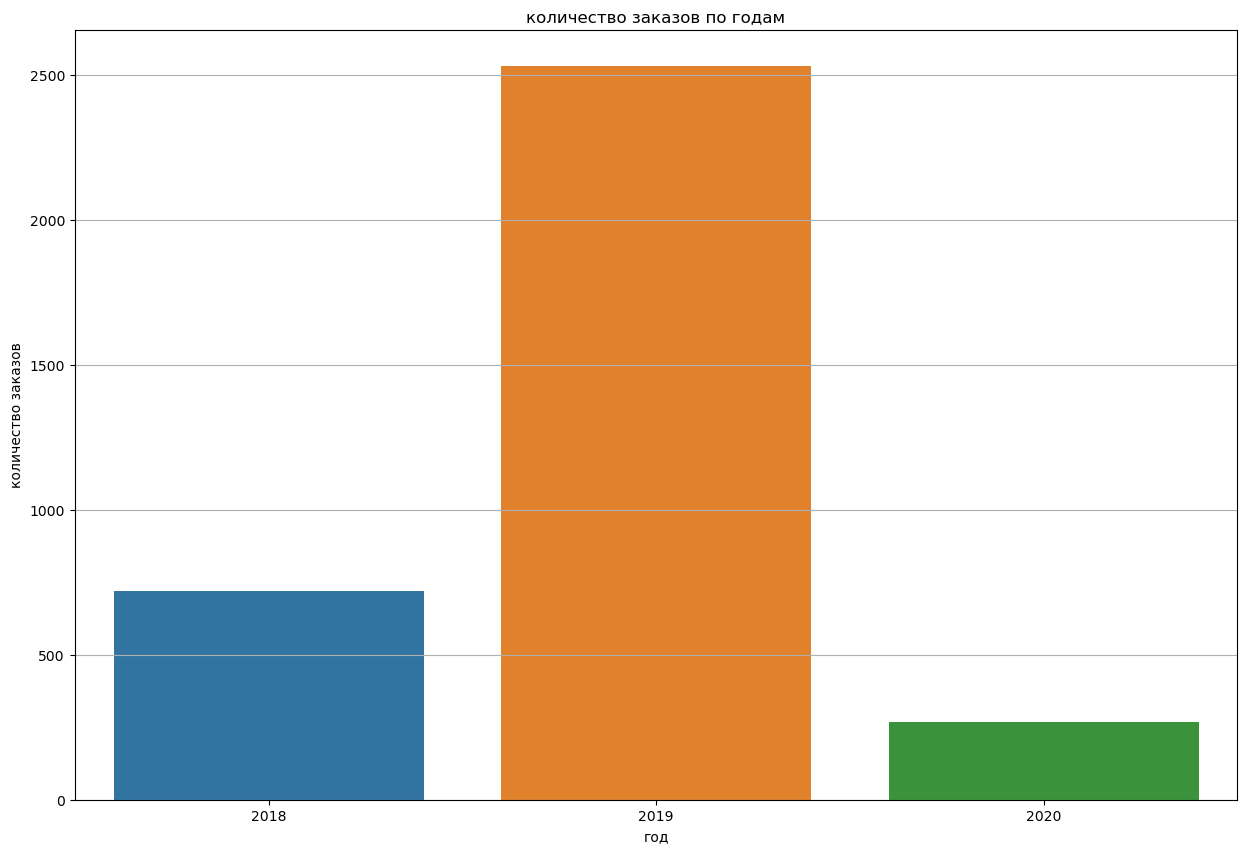

In [47]:
plt.figure(figsize = (15,10))
sns.barplot(data=percent_orders, x = 'year', y = 'order_id')
plt.xlabel('год')
plt.title('количество заказов по годам')
plt.ylabel('количество заказов')
plt.grid(axis = 'y')
plt.show()

In [48]:
f'Данные представленны в период с {data_filt["date_full"].min()} по {data_filt["date_full"].max()}'

'Данные представленны в период с 2018-10-01 00:00:00 по 2020-01-31 15:00:00'

Так как мы имеем полные данные по всему году лишь за 2019 год, по 2018 году за 3 последних месяца, по 2020 году за один первый месяц, следует отбросить данные за 2019 и 2020 год так не обладая полнотой данных за эти периоды невозможно сравнить целые метрики и динамику метрик в годовой перспективе.

#### Расчет медианного чека и его динамика 

Расчитаем средний чек для всего периода данных: 

In [49]:
data_filt['reciept'] = data_filt['quantity'].multiply(data_filt['price'], axis='index')

In [50]:
data_filt['reciept'].describe()

count     5550.000000
mean       709.690345
std       1655.971240
min          9.000000
25%        120.000000
50%        191.000000
75%        734.000000
max      49432.000000
Name: reciept, dtype: float64

In [51]:
f'размер медианного чека за весь период сотавляет {data_filt["reciept"].median()}'

'размер медианного чека за весь период сотавляет 191.0'

Посмотрим динамику медианного чека по годам:

сгруппируем данные по по месяцу и году и посчитаем мединный чек для каждого месяца из временного промежутка данных

In [52]:
median_reciept = data_filt.groupby(['month', 'year', 'order_id'], as_index = False).agg({'reciept':'sum'})
median_reciept = median_reciept.groupby(['month', 'year'], as_index = False).agg({'reciept':'median'})

Сформируем дату с месяцем и годом:

In [53]:
median_reciept['date'] = median_reciept[['month', 'year']].apply(lambda x: '-'.join(x.values.astype(str)), axis = 'columns')
median_reciept['date'] = pd.to_datetime(median_reciept['date'])
median_reciept

,month,year,reciept,date
0,1,2019,674.0,2019-01-01
1,1,2020,188.0,2020-01-01
2,2,2019,603.0,2019-02-01
3,3,2019,637.0,2019-03-01
4,4,2019,592.5,2019-04-01
5,5,2019,805.5,2019-05-01
6,6,2019,599.5,2019-06-01
7,7,2019,599.0,2019-07-01
8,8,2019,579.5,2019-08-01
9,9,2019,599.5,2019-09-01


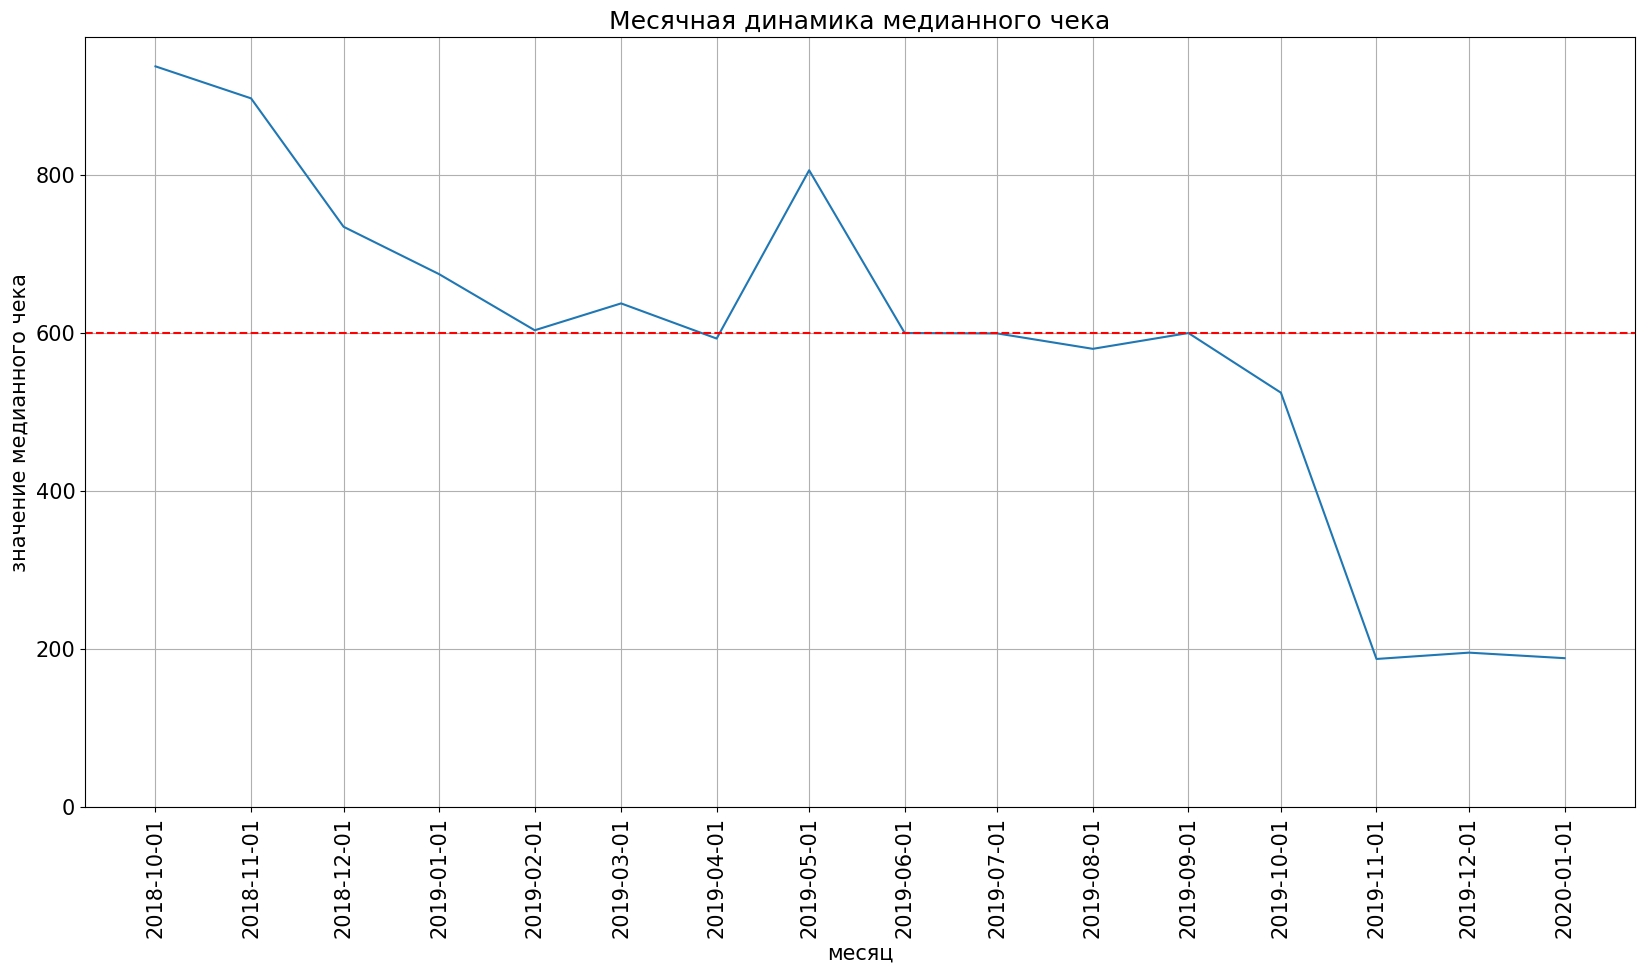

In [54]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize = (20,10))
plt.grid(True)
sns.lineplot(data = median_reciept, x = 'date', y = 'reciept')
plt.xlabel('месяц')
plt.title('Месячная динамика медианного чека')
plt.ylabel('значение медианного чека')
plt.xticks(median_reciept['date'], rotation = 90)
plt.ylim(0, )
plt.axhline(y = median_reciept["reciept"].median(), color='red', linestyle='--', label = 'медианный чек')
plt.show()

При рассмотрении годовой динамики медиаанного чека имеентся негативный тренд на всем протяжении иссследования. С октября 2018 года значения медианного чека уменьшаются достигая плато в феврале 2019 года. В мае 2019 года наблюдается пик значений, а затем снова плато в окрестностях медианного значения. В сентябре наблюдается снова резкий спад до ноября 2019 года. С ноября значения стабилизируются на минимальных значениях.

По графику наблюдаем падение значений медианного чека с востановлением роста весной, стабилизацией в августе-октябре и затем падем до годового медианного чека с тенденцией к росту.

In [55]:
median_reciept_day = data_filt.groupby(['weekday','order_id'], as_index = False).agg({'reciept':'sum'})
median_reciept_day = median_reciept_day .groupby('weekday', as_index = False).agg({'reciept':'median'})

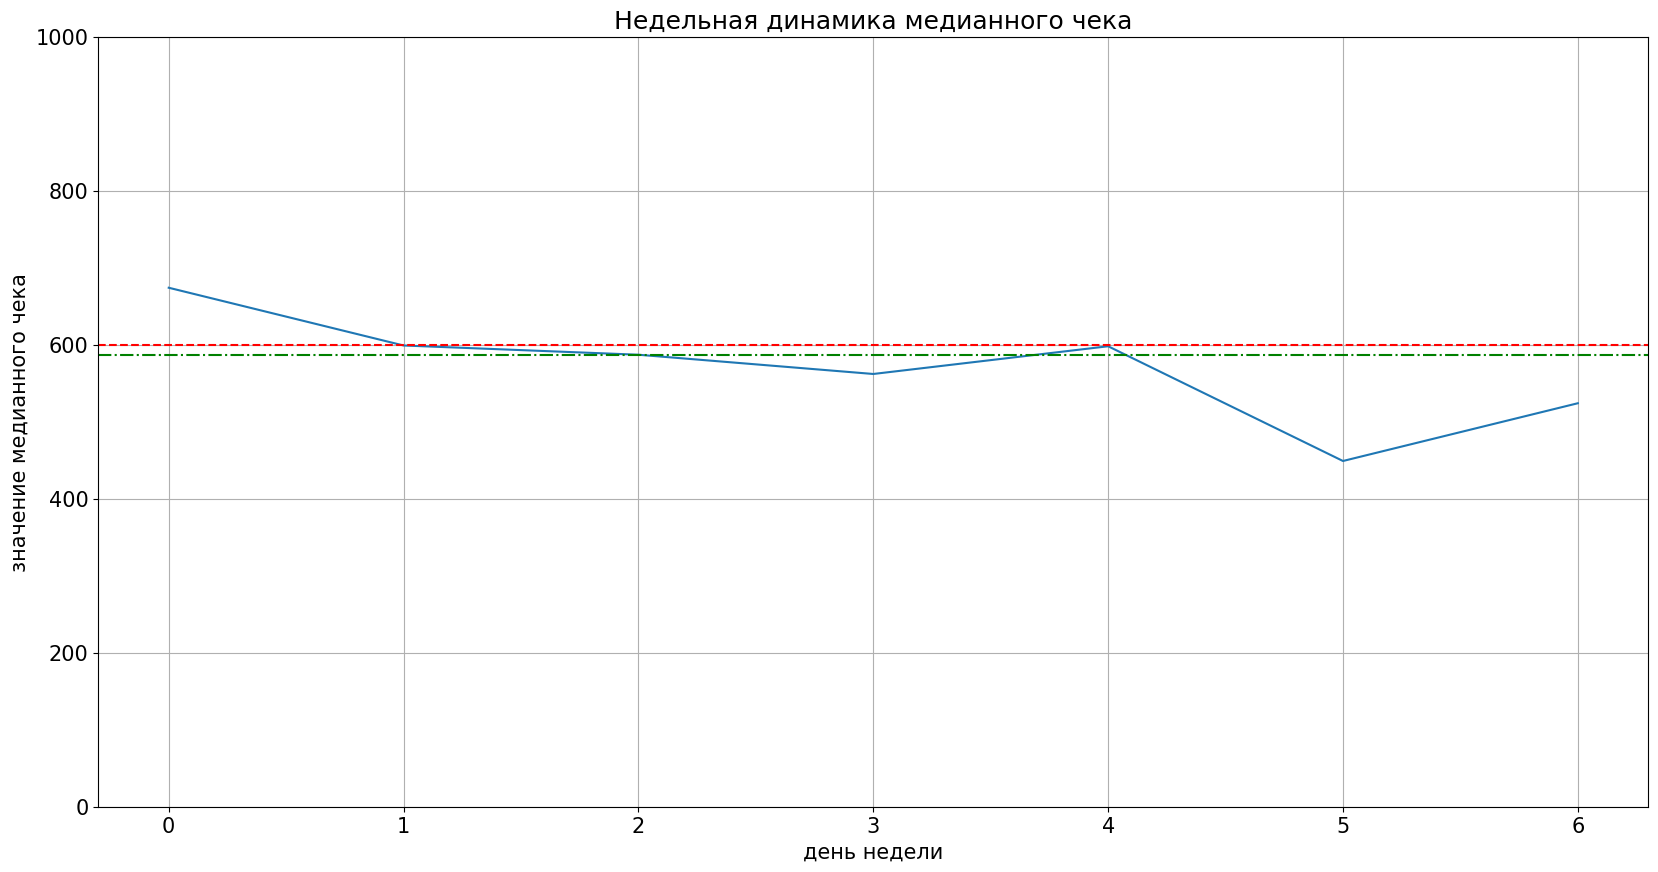

In [56]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize = (20,10))
plt.grid(True)
sns.lineplot(data = median_reciept_day , x = 'weekday', y = 'reciept')
plt.xlabel('день недели')
plt.title('Недельная динамика медианного чека')
plt.ylabel('значение медианного чека')
plt.ylim(0, 1000)
plt.axhline(y = median_reciept["reciept"].median(), color='red', linestyle='--', label = 'медианный чек')
plt.axhline(y = median_reciept_day["reciept"].median(), color='green', linestyle='dashdot', label = 'недельный медианный чек')
plt.show()

По графику динамики медианного недельного чека наблюдаем стабильные колебания в окрестностиях 600.Наблюдается провал в значений медианного чека в выходные дни.

In [57]:
median_reciept_hour = data_filt.groupby(['hour','order_id'], as_index = False).agg({'reciept':'sum'})
median_reciept_hour = median_reciept_hour.groupby('hour', as_index = False).agg({'reciept':'median'})

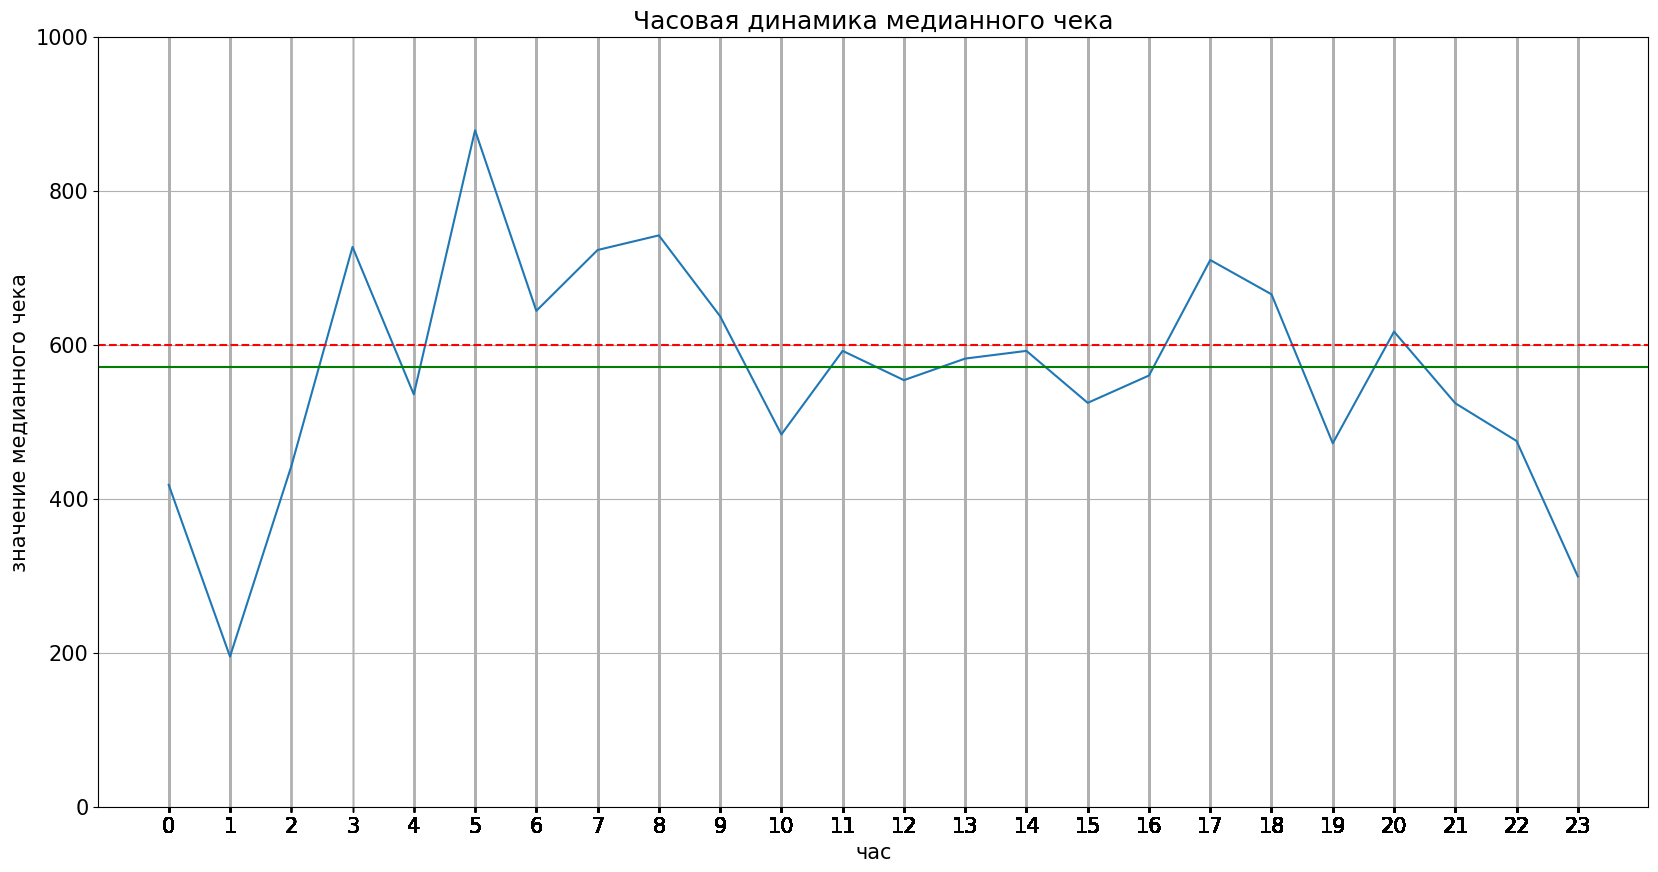

In [58]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize = (20,10))
plt.grid(True)
sns.lineplot(data = median_reciept_hour , x = 'hour', y = 'reciept')
plt.xlabel('час')
plt.title('Часовая динамика медианного чека')
plt.ylabel('значение медианного чека')
plt.xticks(data_filt['hour'])
plt.ylim(0, 1000)
plt.axhline(y = median_reciept["reciept"].median(), color='red', linestyle='--', label = 'медианный чек за весь период')
plt.axhline(y = median_reciept_hour["reciept"].median(), color='green', linestyle='-', label = 'медианный чек за день')
plt.show()

Рост значений медианного чека наблюдается с 1 часа ночи и с колебаниями достигает пика к 5 часам утра. После 5 часов утра обнаруживается колебатильное снижение значений к 10 часам утра. В остальное время дня значения стабилизируются в окрестностиях 600. Небольшой пик виден в конце рабочего дня в 17 часов. К концу суток происходит ожидаемое снижение.

#### Определение выручки на одного покупателя и ее динамика

In [59]:
median_profit = data_filt.groupby('customer_id', as_index = False).agg({'reciept':'sum'})
mediam_profit_per_user_common = median_profit['reciept'].median()
f'медианная выручка сотавляет {mediam_profit_per_user_common}'

'медианная выручка сотавляет 832.0'

Посчитаем годовую динамику выручки на каждого клиента:

In [60]:
    def annual_dynamic_profit_per_customer(data):
        median_profit_annual = data.groupby(['year','month','customer_id'], as_index = False).agg({'reciept':'sum'})
        median_profit_annual.rename(columns = {'reciept':'profit'}, inplace = True)
        median_profit_annual['date'] = median_profit_annual[['month', 'year']].apply(lambda x: '-'.join(x.values.astype(str)), axis = 'columns')
        median_profit_annual['date'] = pd.to_datetime(median_profit_annual['date'])
        median_profit_annual = median_profit_annual.groupby(['date'], as_index = False).agg({'profit':'sum', 'customer_id':'nunique'})
        median_profit_annual['profit_per_user'] = median_profit_annual['profit'] /  median_profit_annual['customer_id']
        return median_profit_annual

In [61]:
profit_per_user_monthly = annual_dynamic_profit_per_customer(data_filt)

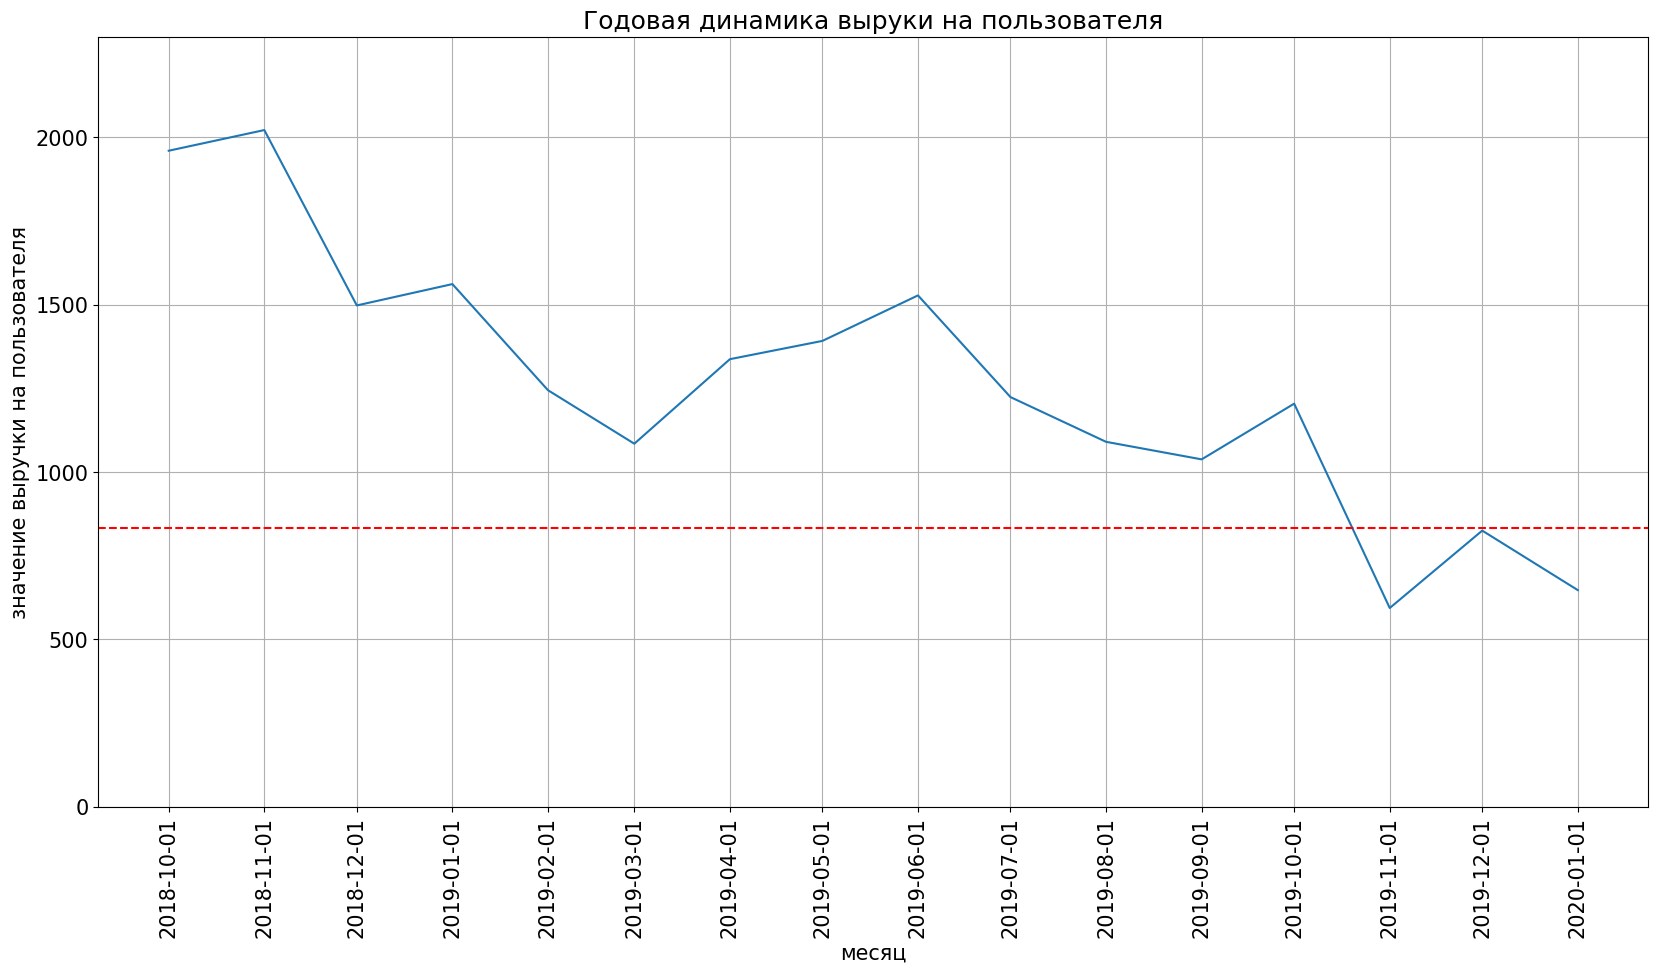

In [62]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize = (20,10))
plt.grid(True)
sns.lineplot(data = profit_per_user_monthly , x = 'date', y = 'profit_per_user')
plt.xticks(profit_per_user_monthly['date'], rotation = 90)
plt.xlabel('месяц')
plt.ylim(0, 2300)
plt.title('Годовая динамика выруки на пользователя')
plt.ylabel('значение выручки на пользователя')
plt.axhline(y = mediam_profit_per_user_common, color='red', linestyle='--', label = 'медианный чек')
plt.show()

По графику наблюдается тенденция на снижение за весь исследуемый промежуток времени. Наибольшие значения выручки были в ноябре 2018 года. В период новогодних праздников наблюдается небольшой рост, а затем снижение до марта 2019 года. После марта 2019 года наблюдается повышение значений  достигающих пика в июне 2019 года. После июня 2091 года тенденция к снижению с колебаниями в  октябре и декабре 2019 года.

In [63]:
    def period_dynamic_profit_per_customer(data, period):
        median_profit_annual = data.groupby([period,'customer_id'], as_index = False).agg({'reciept':'sum'})
        median_profit_annual.rename(columns = {'reciept':'profit'}, inplace = True)
        median_profit_annual = median_profit_annual.groupby(period, as_index = False).agg({'profit':'sum', 'customer_id':'nunique'})
        median_profit_annual['profit_per_user'] = median_profit_annual['profit'] /  median_profit_annual['customer_id']
        return median_profit_annual

In [64]:
profit_per_user_weekday = period_dynamic_profit_per_customer(data_filt, 'weekday')

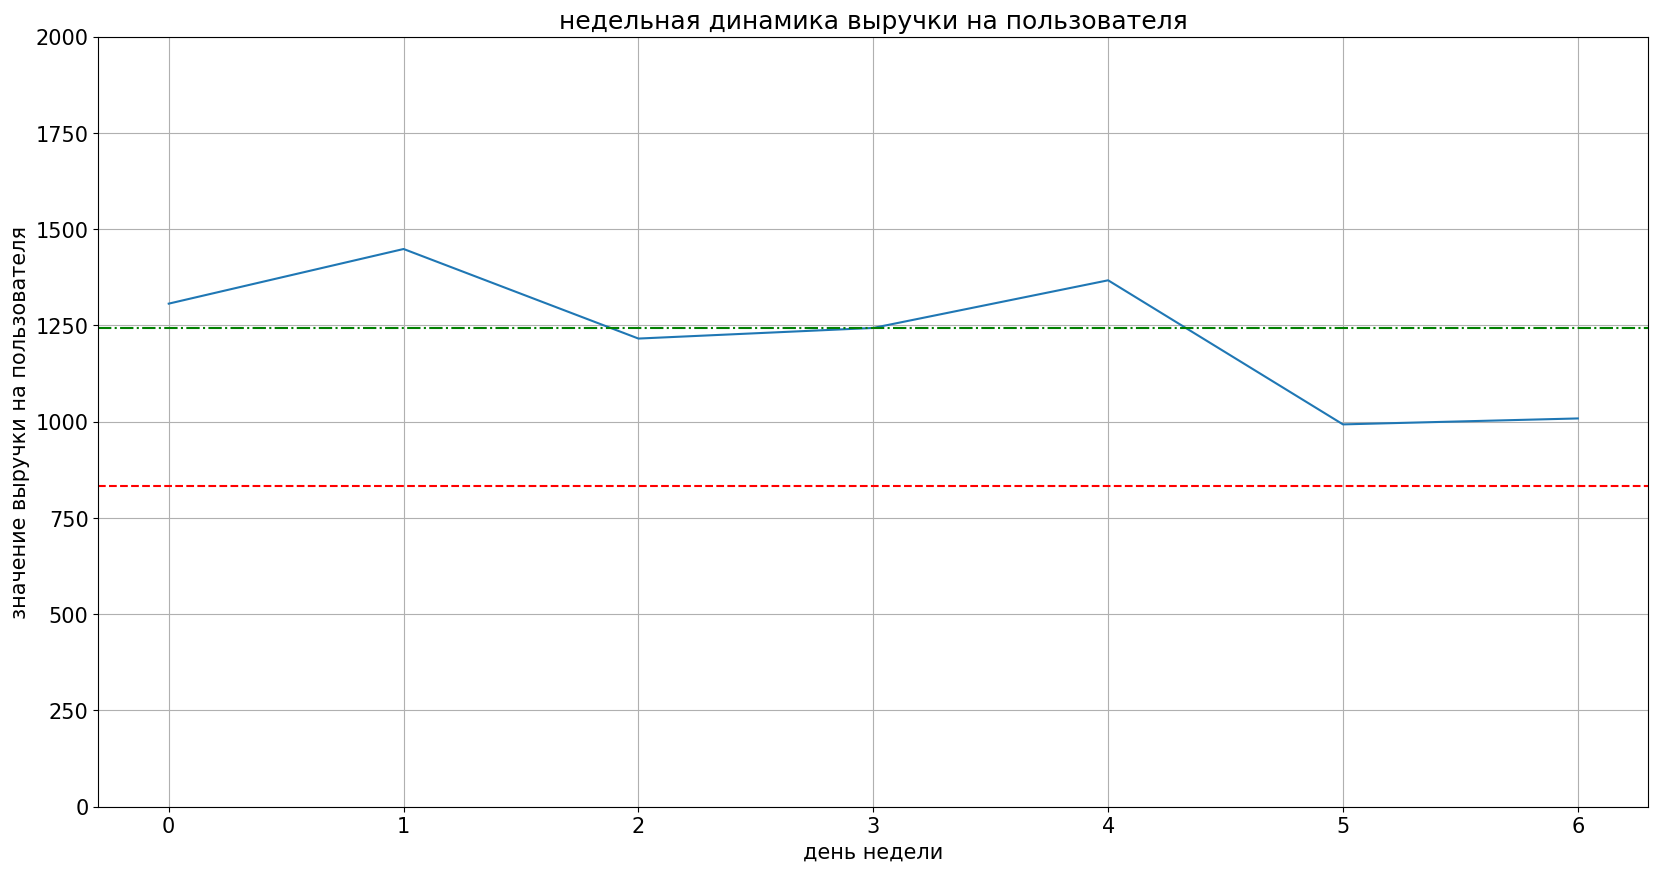

In [65]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize = (20,10))
plt.grid(True)
sns.lineplot(data = profit_per_user_weekday  , x = 'weekday', y = 'profit_per_user')
plt.xlabel('день недели')
plt.title('недельная динамика выручки на пользователя')
plt.ylabel('значение выручки на пользователя')
plt.ylim(0, 2000)
plt.axhline(y = mediam_profit_per_user_common, color='red', linestyle='--', label = 'мединная выручка')
plt.axhline(y = profit_per_user_weekday['profit_per_user'].median(), color='green', linestyle='dashdot', label = ' неделя медианное выручка на рользователя')
plt.show()

По недельному графику динамики медианной выручки на пользователя резких колебаний не наблюдаетсяю. Наибольшая значения выручки на пользователя наблюдаются в понедельник затем наблюдается снижение до мединанного недельного значения с небольшим провалом в субботу и воскресенье.

In [66]:
profit_per_user_daily = period_dynamic_profit_per_customer(data_filt, 'hour')

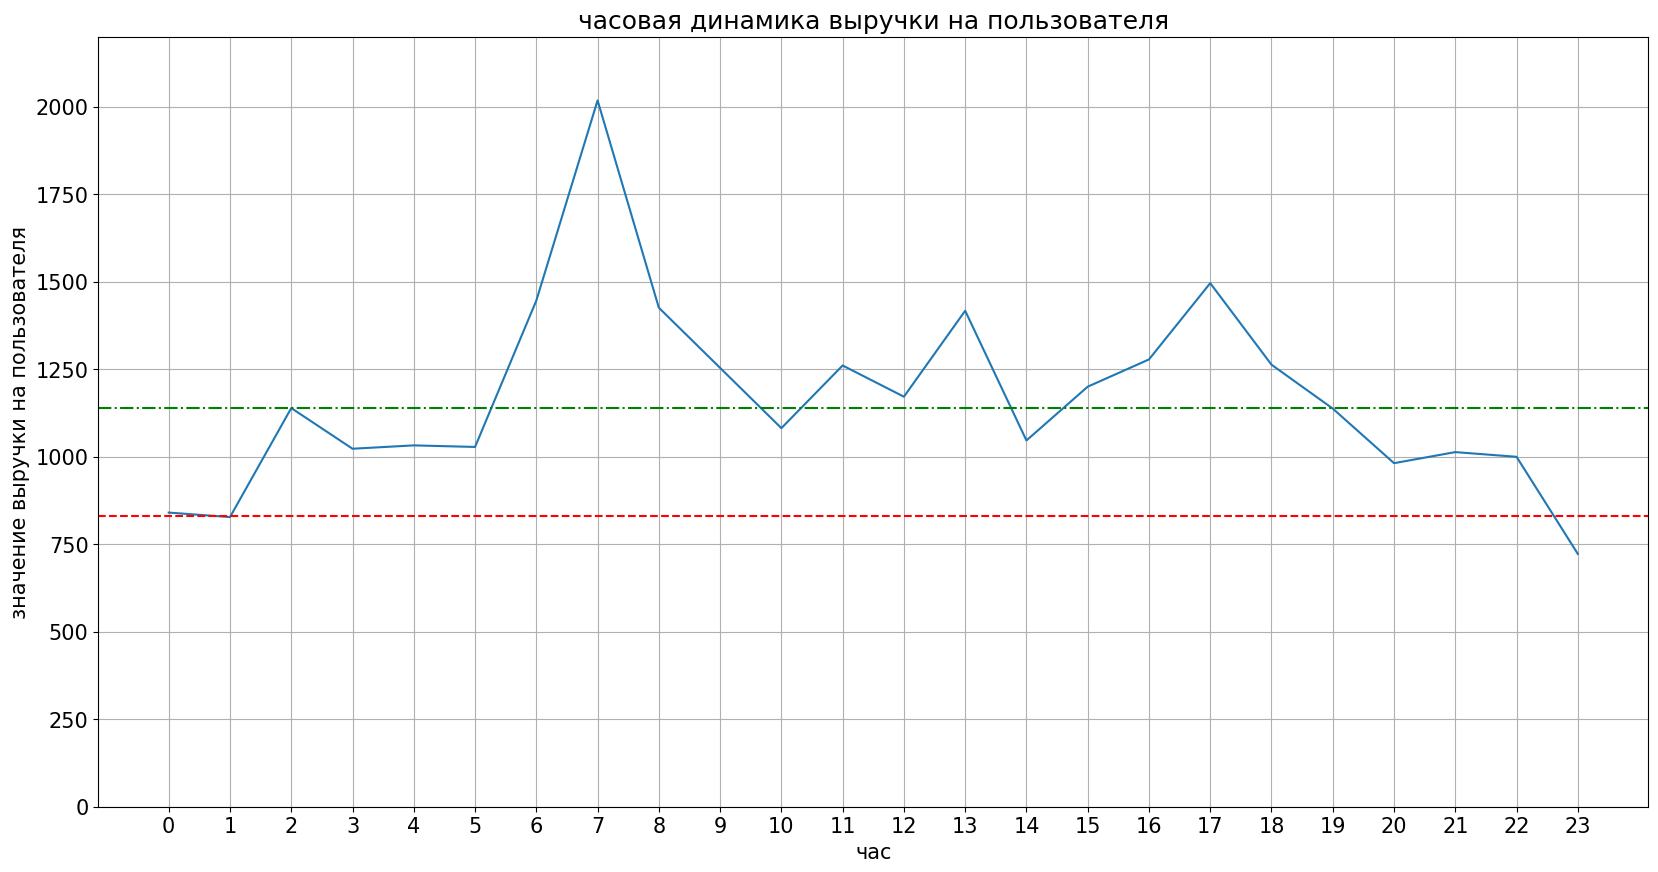

In [67]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize = (20,10))
plt.grid(True)
sns.lineplot(data = profit_per_user_daily  , x = 'hour', y = 'profit_per_user')
plt.xlabel('час')
plt.title('часовая динамика выручки на пользователя')
plt.ylabel('значение выручки на пользователя')
plt.xticks(profit_per_user_daily['hour'])
plt.ylim(0, 2200)
plt.axhline(y = mediam_profit_per_user_common, color='red', linestyle='--', label = 'медианный чек')
plt.axhline(y = profit_per_user_daily['profit_per_user'].median(), color='green', linestyle='dashdot', label = 'медианный чек недельный')
plt.show()

По графику дневной выручки на пользователя наблюдаем два пика в утрение часы, провал  выручки на пользователя в середине дня и небольшой пик во время окончания рабочего дня с поледующим падением.

#### Динамика абсолютных метрик

Зададим функцию для посчета динамики метрики по месяцам

In [68]:
def year_dynamics (data, period, metric, func):
    result = data.groupby(period, as_index = False).agg({metric:func})
    result['date'] = result[period].apply(lambda x: '-'.join(x.values.astype(str)), axis = 'columns')
    result['date'] = pd.to_datetime(result['date'])
    return result

Полчим динамику абсолютной выручки по месяцам за весь исследуемый период:

In [69]:
profit_annual_absolute = year_dynamics(data_filt, ['year', 'month'],'reciept', 'sum')
profit_annual_absolute

,year,month,reciept,date
0,2018,10,350748.000000,2018-10-01
1,2018,11,359772.000000,2018-11-01
2,2018,12,344388.000000,2018-12-01
3,2019,1,238854.000000,2019-01-01
4,2019,2,306059.000000,2019-02-01
5,2019,3,251565.000000,2019-03-01
6,2019,4,316825.000000,2019-04-01
7,2019,5,230971.000000,2019-05-01
8,2019,6,235207.000000,2019-06-01
9,2019,7,226361.000000,2019-07-01


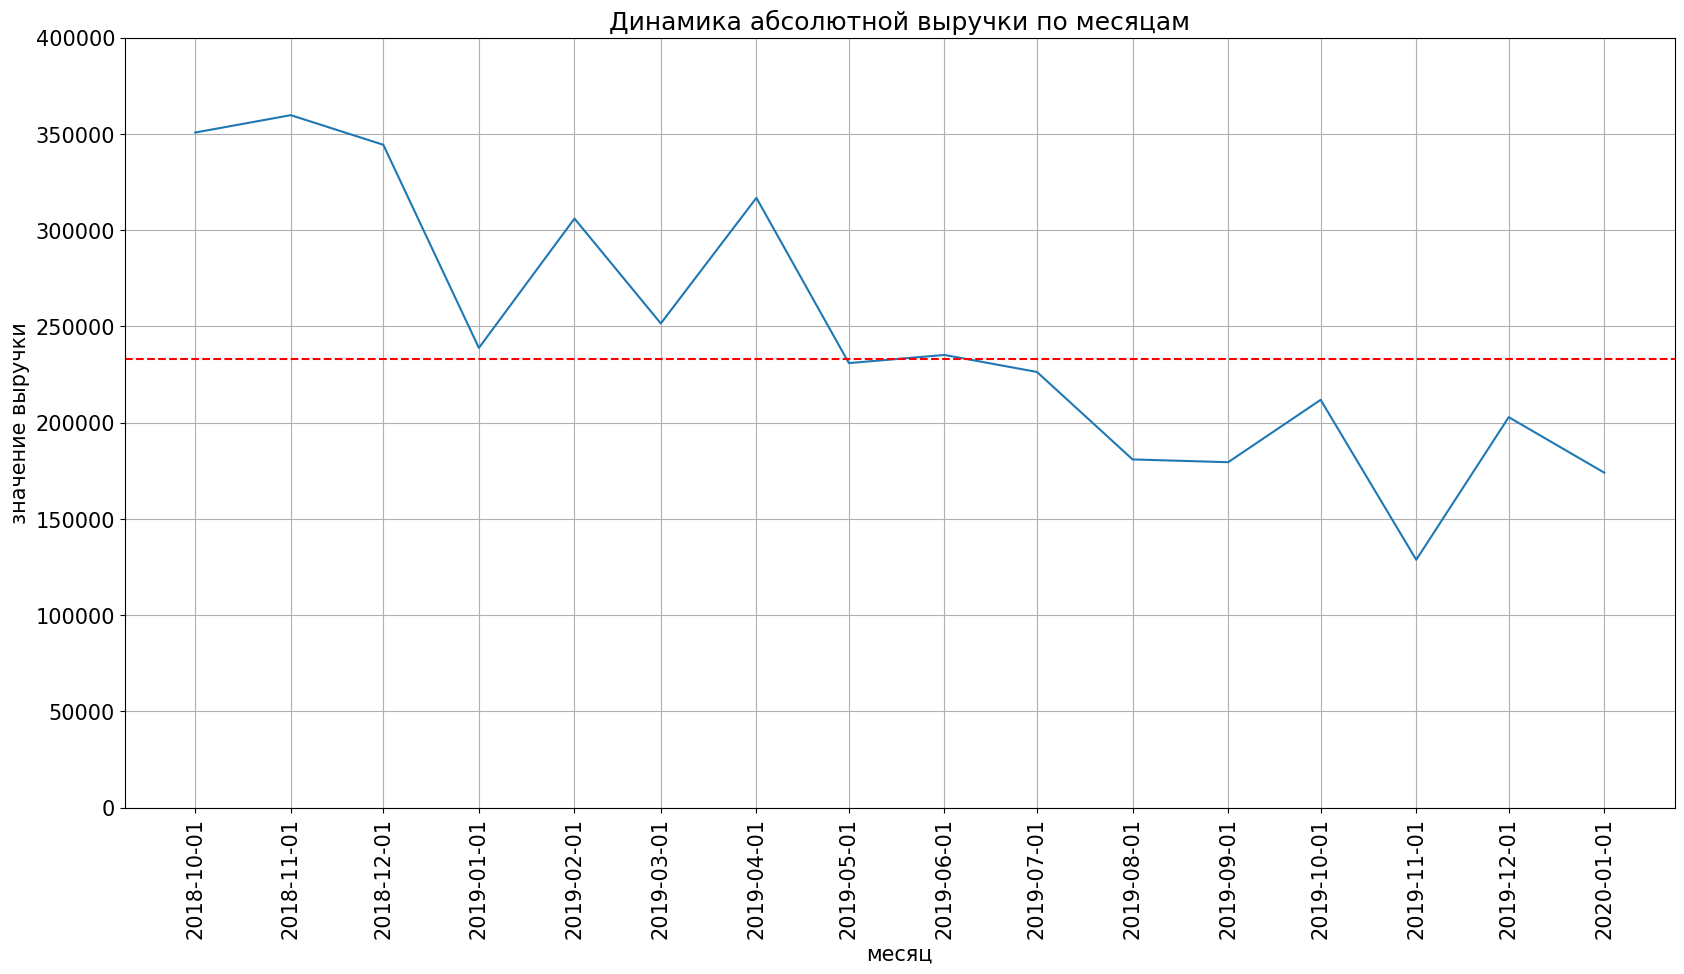

In [70]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize = (20,10))
plt.grid(True)
sns.lineplot(data = profit_annual_absolute  , x = 'date', y = 'reciept')
plt.xticks(profit_annual_absolute['date'], rotation = 90)
plt.xlabel('месяц')
plt.title('Динамика абсолютной выручки по месяцам')
plt.ylabel('значение выручки')
plt.ylim(0, 400000)
plt.axhline(y = profit_annual_absolute['reciept'].median(), color='red', linestyle='--', label = 'медианный чек недельный')
plt.show()

Рассматиривая график димнамики абсолютной выручки монжо отметить тенденцию к снижению абсолютной выручки на всем исследуемом промежутке  
времени. Наибольших значений вырука достигает в ноябре 2018 года с последующими колебаниями снижается к мединному значению в мае-июне 2019 года с последующим снижением начиная с июля 2019 года.

Зададим функцию для опредления остальных метрик

In [71]:
def period_dynamics (data, period, metric, func):
    result = data.groupby(period, as_index = False).agg({metric:func})
    return result

In [72]:
week_profit_absolute = period_dynamics (data_filt, 'weekday', 'reciept', 'sum')

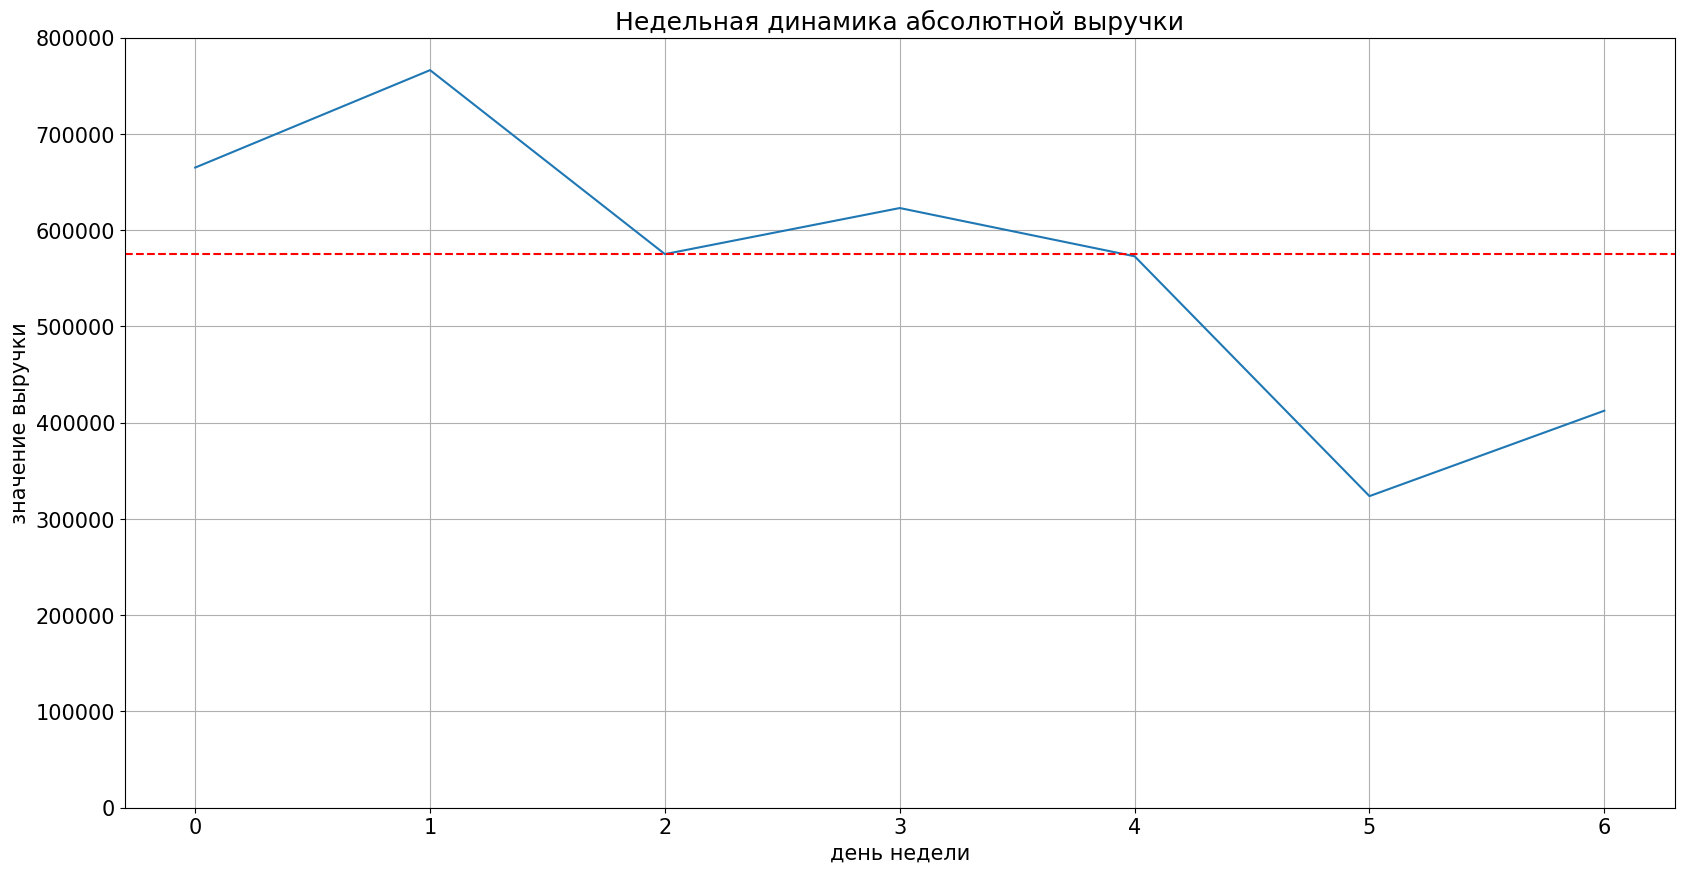

In [73]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize = (20,10))
plt.grid(True)
sns.lineplot(data = week_profit_absolute  , x = 'weekday', y = 'reciept')
plt.xticks(week_profit_absolute['weekday'])
plt.xlabel('день недели')
plt.title('Недельная динамика абсолютной выручки')
plt.ylabel('значение выручки')
plt.ylim(0, 800000)
plt.axhline(y = week_profit_absolute['reciept'].median(), color='red', linestyle='--', label = 'медианный чек недельный')
plt.show()

По динамике недельной выручки за весь период наблюдается тенденция к снижению. Наибольшие значения наблюдаются во вторник
с дальнейшими колебаниями в окрестностях медианного недельного значения. В субботу наблюдается значительное снижение с небольшим 
восстановлением в воскресенье

In [74]:
day_profit_absolute = period_dynamics (data_filt, 'hour', 'reciept', 'sum')

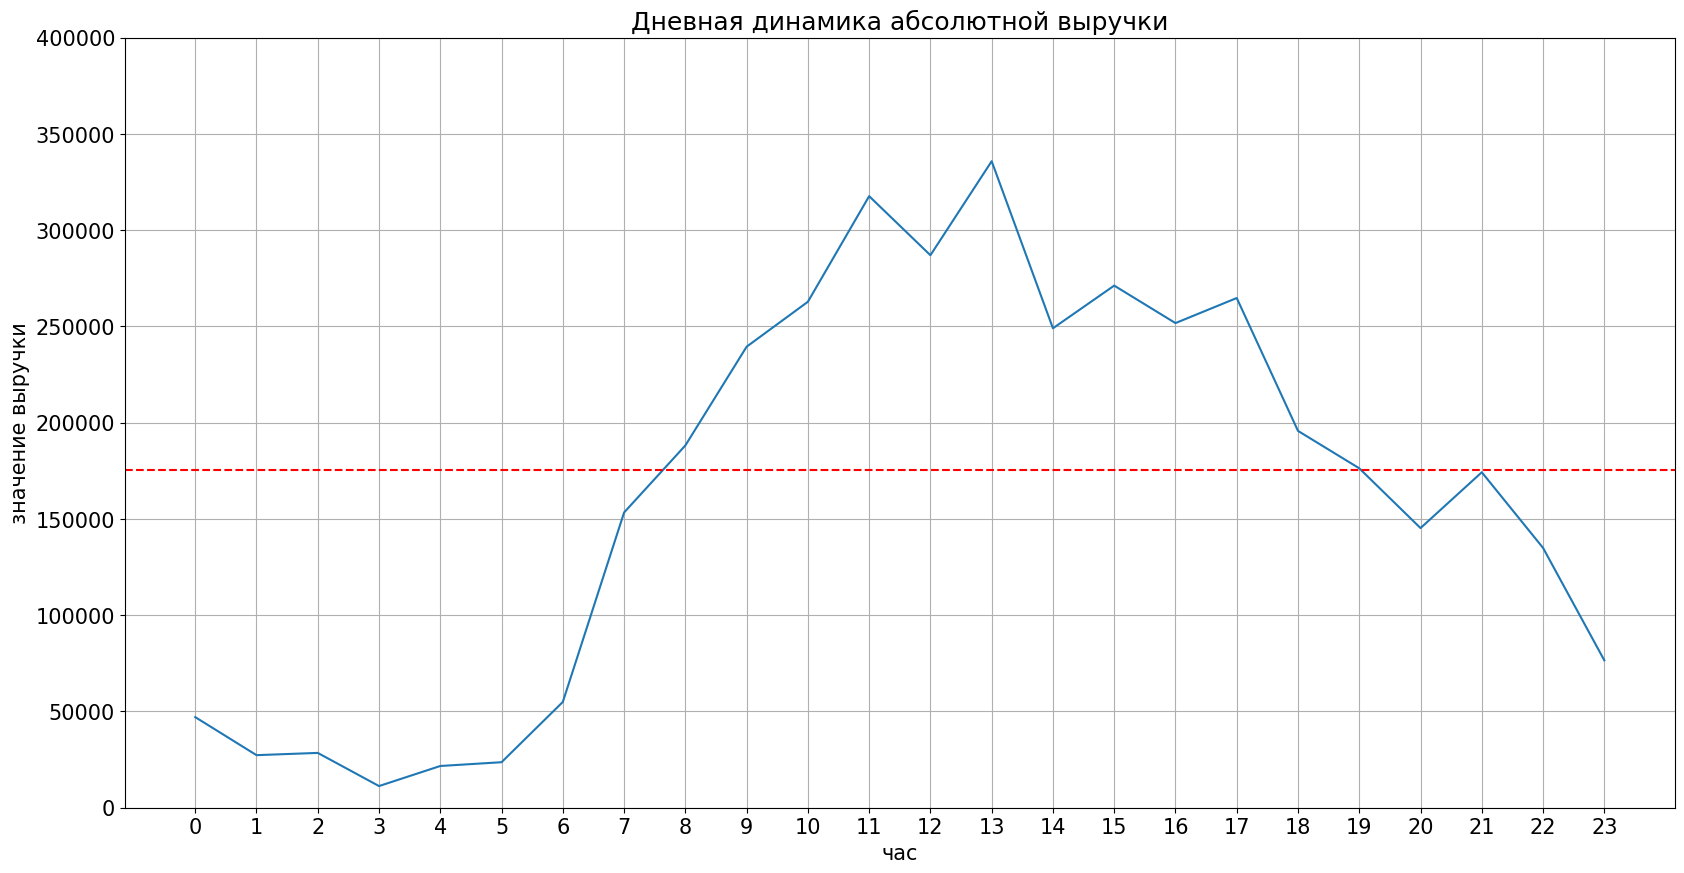

In [75]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize = (20,10))
plt.grid(True)
sns.lineplot(data = day_profit_absolute  , x = 'hour', y = 'reciept')
plt.xticks(day_profit_absolute['hour'])
plt.xlabel('час')
plt.title('Дневная динамика абсолютной выручки')
plt.ylabel('значение выручки')
plt.ylim(0, 400000)
plt.axhline(y = day_profit_absolute['reciept'].median(), color='red', linestyle='--', label = 'медианный чек недельный')
plt.show()

Анализируя дневную динамику абсолютной выручки можно отметить, что значения начинают расти с 5 часов утра и достигают пика в 13 часов. С 13 часов наблюдается колебательные снижения значений до минимальных значений в конце суток

In [76]:
customer_quantity_dynamics  = year_dynamics(data_filt, ['year', 'month'], 'customer_id', 'nunique')

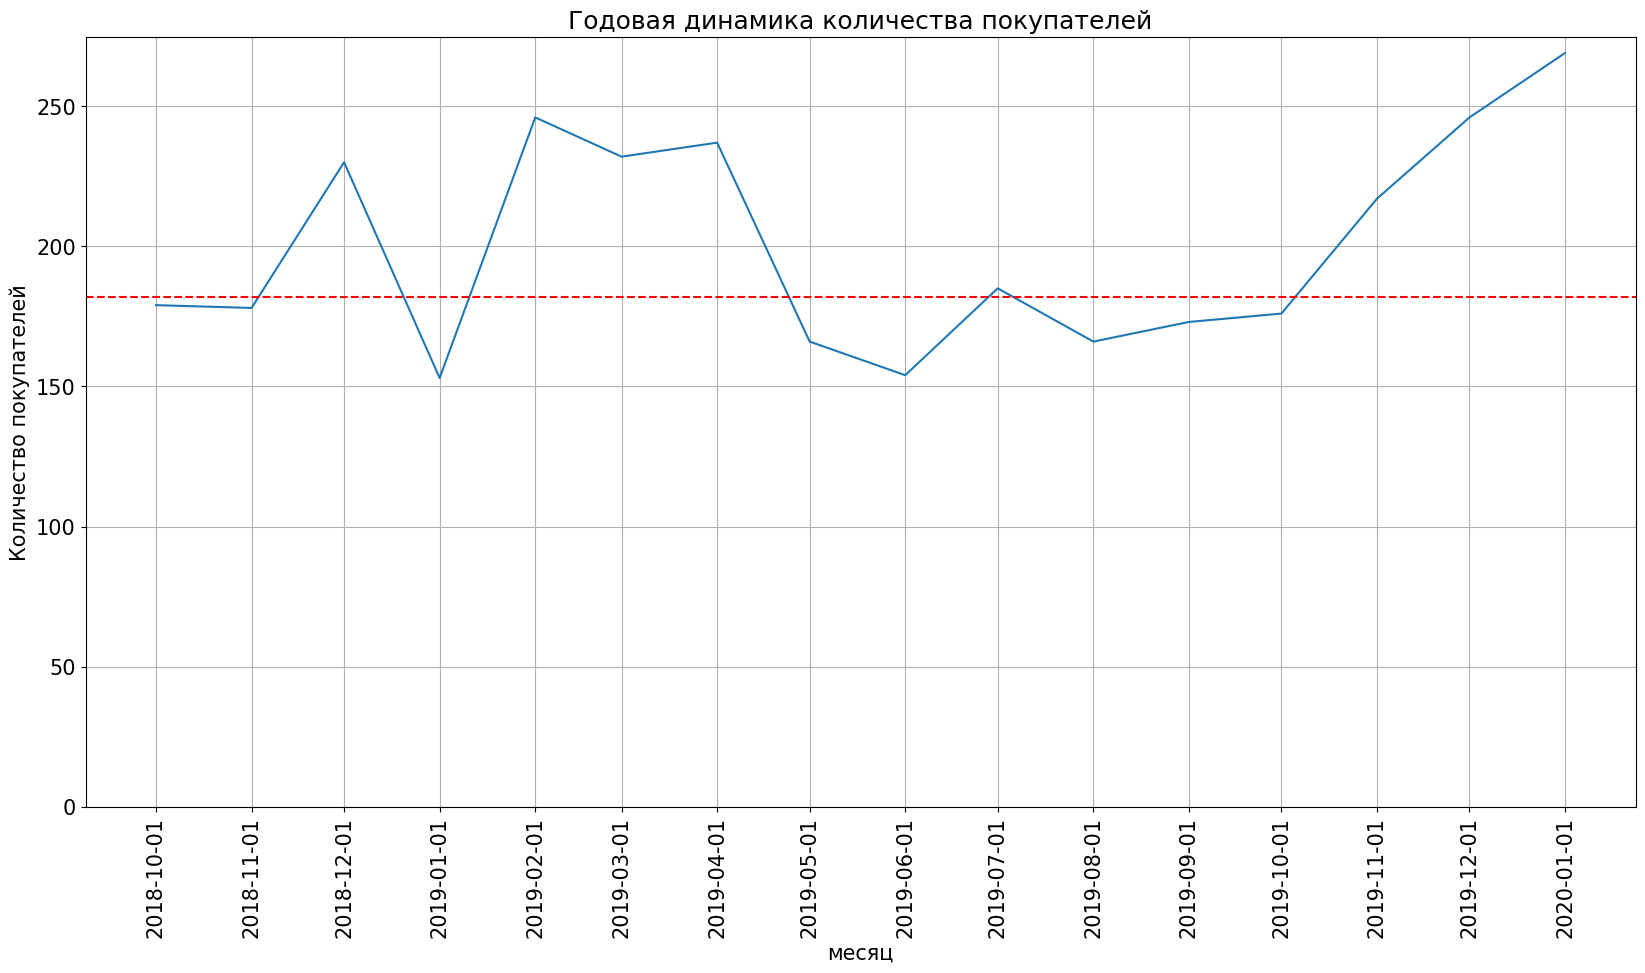

In [77]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize = (20,10))
plt.grid(True)
sns.lineplot(data = customer_quantity_dynamics  , x = 'date', y = 'customer_id')
plt.xticks(customer_quantity_dynamics['date'], rotation = 90)
plt.xlabel('месяц')
plt.title('Годовая динамика количества покупателей')
plt.ylabel('Количество покупателей')
plt.ylim(0,)
plt.axhline(y = customer_quantity_dynamics['customer_id'].median(), color='red', linestyle='--', label = 'медианный чек недельный')
plt.show()

Пик количества покупателей наблюдается в декабре 2018 года, что ожидаемо. В январе 2019 года наблюдается спад, а в феврале-апреле наблюдаются максимальные значения количества клиентов за 2019 год. С февраля до ноября 2019 года наблюдается спад количества клиентов ниже медианного значения с одним небольшим пиком. С ноября 2019 года наблюдается значительный рост клиетнов который продолжается и в первом месяце 2020 года, достигая максимальных значений за все время.

In [78]:
week_customer_dynamics = period_dynamics (data_filt, 'weekday', 'customer_id', 'nunique')

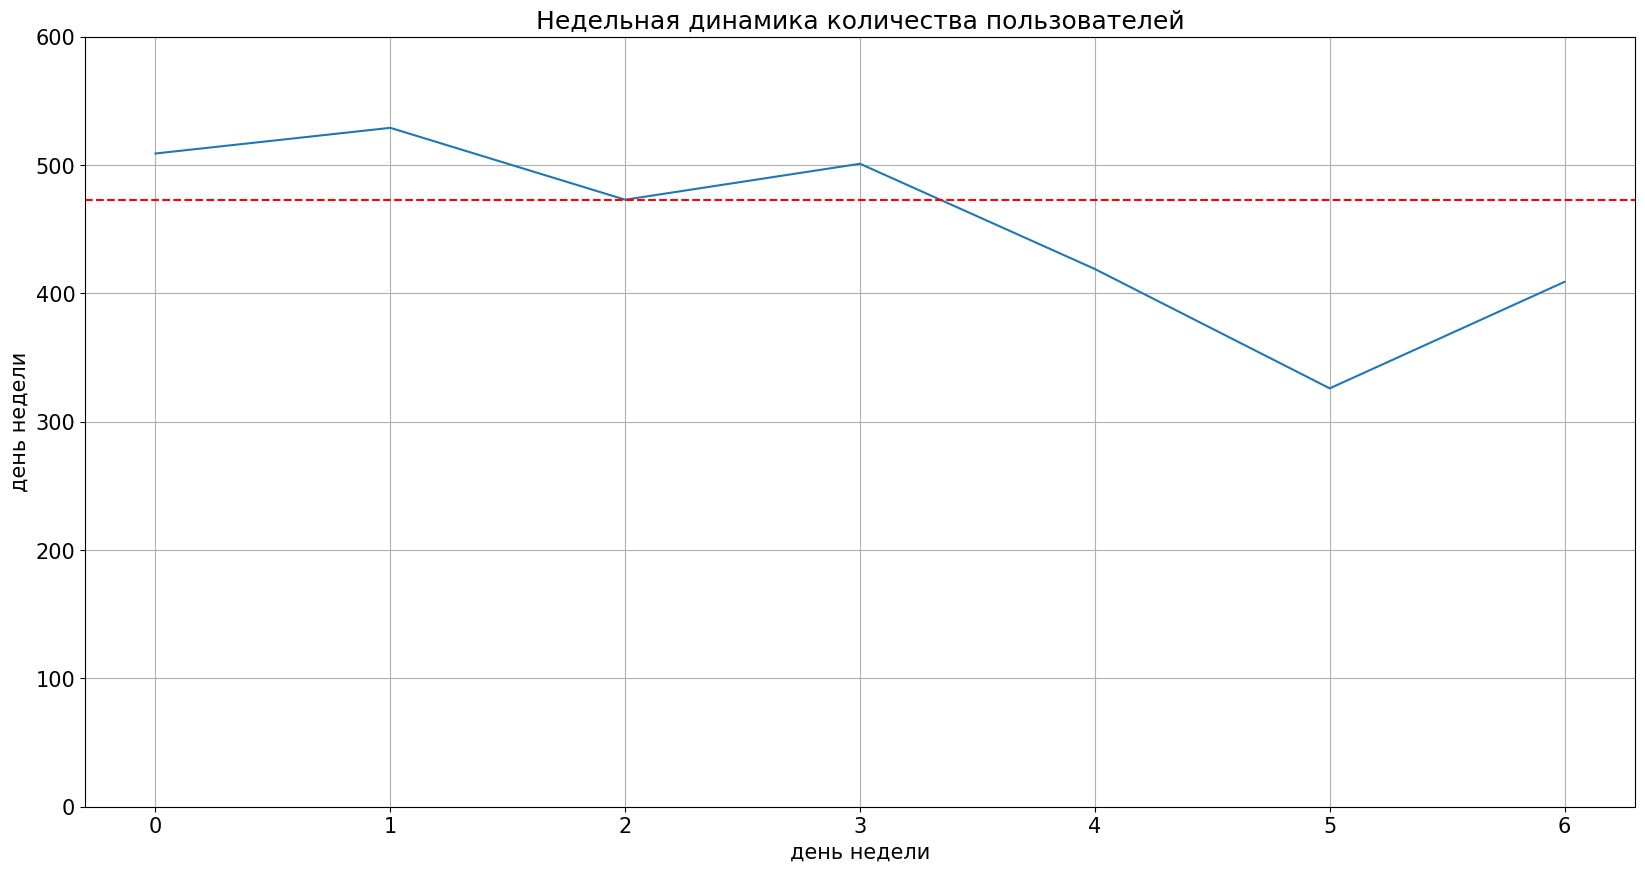

In [79]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize = (20,10))
plt.grid(True)
sns.lineplot(data = week_customer_dynamics , x = 'weekday', y = 'customer_id')
plt.xticks(week_customer_dynamics['weekday'])
plt.xlabel('день недели')
plt.title('Недельная динамика количества пользователей')
plt.ylabel('день недели')
plt.ylim(0, 600)
plt.axhline(y = week_customer_dynamics['customer_id'].median(), color='red', linestyle='--', label = 'медианный чек недельный')
plt.show()

По недельной динамике количества клиентов не наблюдается значительных колебаний с тенденцией к снижению в течении недели. 
Наибольшее значение клиентов наблюдается во вторник, наименьшее количество в субботу.

In [80]:
day_customer_dynamics = period_dynamics (data_filt, 'hour', 'customer_id', 'nunique')

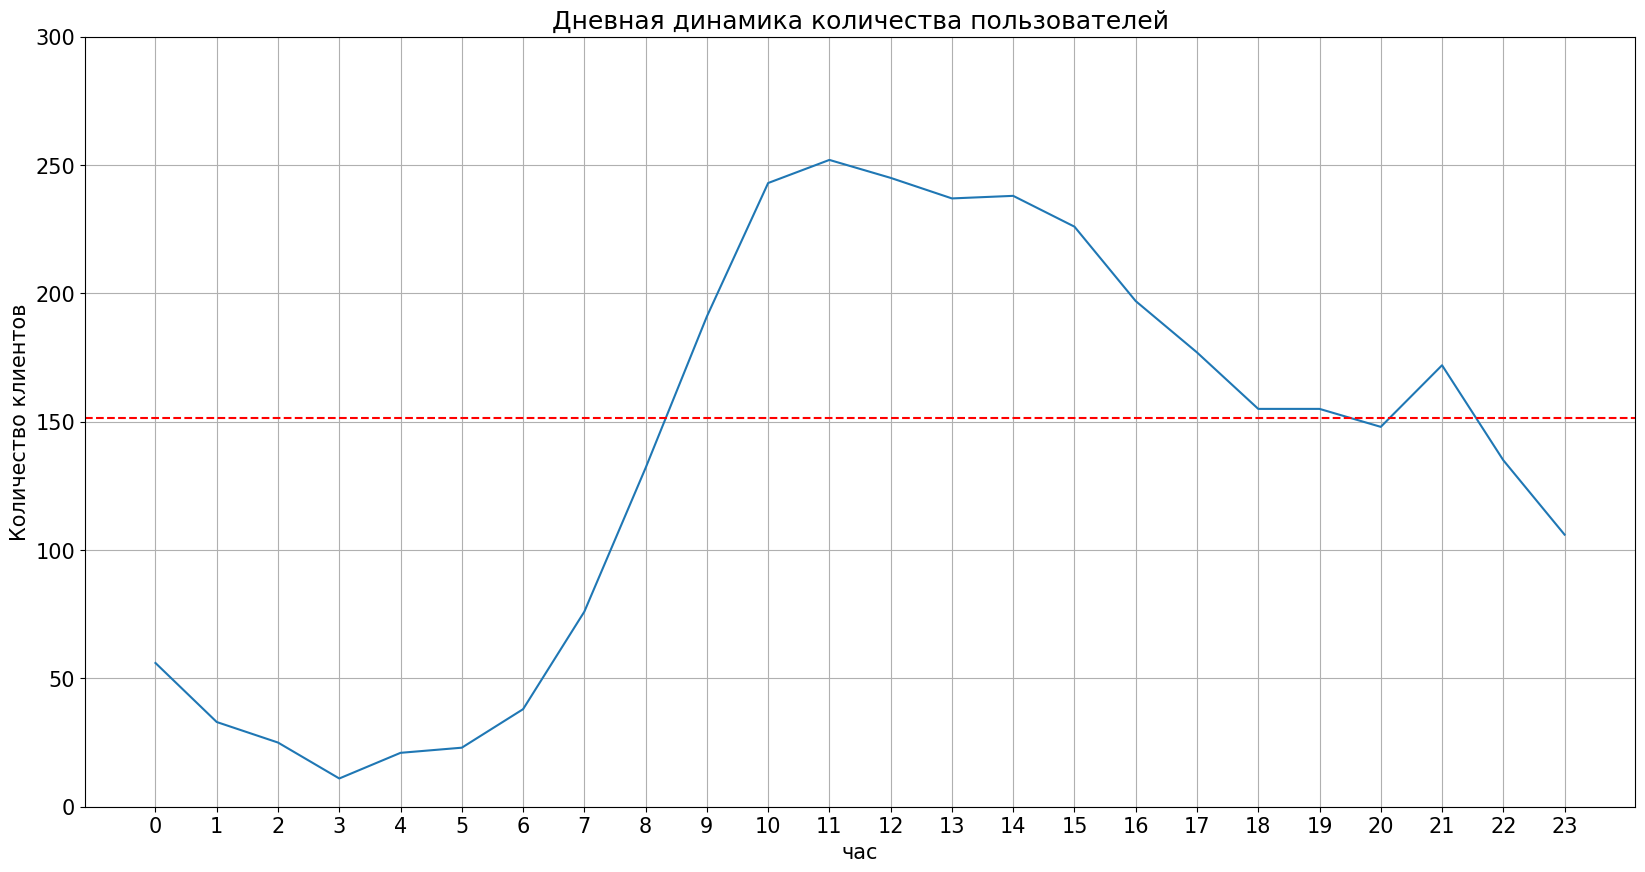

In [81]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize = (20,10))
plt.grid(True)
sns.lineplot(data = day_customer_dynamics , x = 'hour', y = 'customer_id')
plt.xticks(day_customer_dynamics['hour'])
plt.xlabel('час')
plt.title('Дневная динамика количества пользователей')
plt.ylabel('Количество клиентов')
plt.ylim(0, 300)
plt.axhline(y = day_customer_dynamics['customer_id'].median(), color='red', linestyle='--', label = 'медианный чек недельный')
plt.show()

Анализируя график дневной динамики видно, что минимальное значения клиентов наблюдается в 3 часа ночи, после наблюдается быстрый рост, который достигает максимальных значений в 11 часов. После пика наблюдается медленный спад до плато в районе 18-20 часов с небольшим пиком в 21 час.

#### Анализ постоянных клиентов

In [82]:
customers = data_filt.groupby('customer_id', as_index = False).agg({'order_id':'nunique'})
f'максимальное количество заказов на одного пользователя составляет {customers["order_id"].max()}'

'максимальное количество заказов на одного пользователя составляет 126'

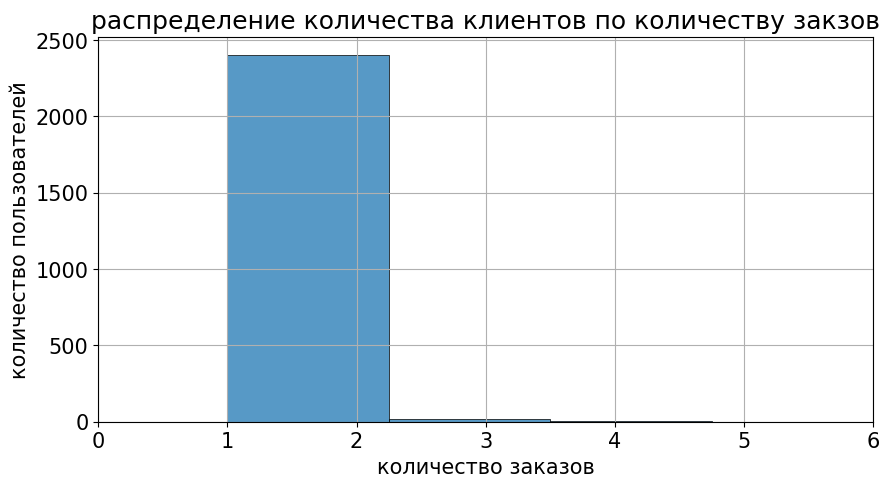

In [83]:
plt.figure(figsize = (10,5))
sns.histplot(data = customers, x = 'order_id', bins = 100)
plt.xlabel('количество товара')
plt.title('распределение количества клиентов по количеству закзов')
plt.xlim(0,6)
plt.xlabel('количество заказов')
plt.ylabel('количество пользователей')
plt.grid()
plt.show()

Гистограмма показывает, что абсоюлютное большинство клиентов совершают не более одного заказа.

In [84]:
def customer_type(index):#создадим функцию для категоризации этажей
    if index['order_id'] == 1:
        return 'одна покупка'
    else:
        return 'постоянный клиент'

In [85]:
customers['loyal'] = customers.apply(customer_type, axis = 1)
loyal = customers.groupby('loyal', as_index = False).agg({'order_id':'count'})
loyal

,loyal,order_id
0,одна покупка,1546
1,постоянный клиент,884


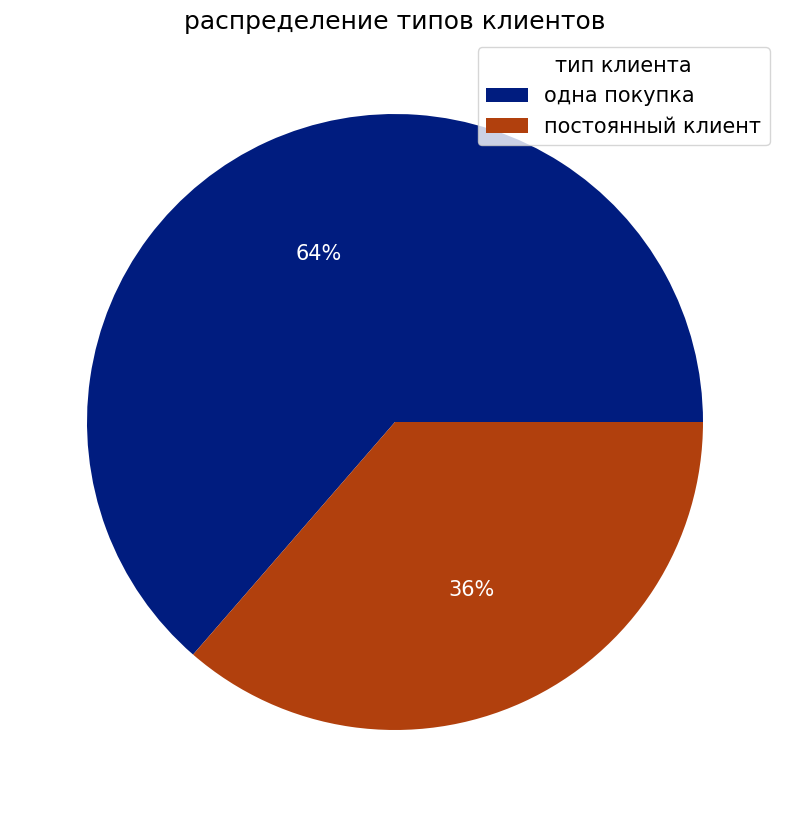

In [86]:
plt.figure(figsize = (15,10))#зададим размер графика 
sns.set_palette('dark') #выберим стиль графика
plt.pie(loyal['order_id'] , autopct='%.0f%%',textprops={'color':"w"})
plt.legend(labels = loyal['loyal'], title="тип клиента")#построим курговую диаграмму
plt.title('распределение типов клиентов')#установим название графика
plt.show;

Доля лояльных клиентов совершивших две покупки и более за 2019 год сотавляет всего 36%.

### Категоризация товаров 

**Разобъем представленные товары на категории**

Выделим первое слово из наименование товара, как  наиболее его характеризующие

In [87]:
words = data_filt['product'].str.split()
words

0       [комнатное, растение, в, горшке, алое, вера,, ...
1       [комнатное, растение, в, горшке, кофе, арабика...
2                       [радермахера, d-12, см, h-20, см]
3                   [хризолидокарпус, лутесценс, d-9, см]
4                   [циперус, зумула, d-12, см, h-25, см]
                              ...                        
5583    [томата, (помидор), черниченский, черри, №, 11...
5584    [дендробиум, санок, анна, грин, 1, ствол, d-12...
5585    [подставка, для, обуви, резиновая, attribute, ...
5586    [тагетис, крупноцветковый, рассада, однолетних...
5587    [вешалка, для, блузок, 41, см, красный, attrib...
Name: product, Length: 5550, dtype: object

составим список из этих слов и сделаем датафрейм

In [88]:
words_update = words.loc[5550:5587]
words_update
words_update_list = list(words_update)
words_update_list_data = pd.DataFrame(words_update_list)
words_update_list_data = words_update_list_data.loc[:,0]

In [89]:
words = list(words)


In [90]:
words = pd.DataFrame(words)

In [91]:
words

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,комнатное,растение,в,горшке,алое,"вера,","d12,",h30,None,None,...,None,None,None,None,None,None,None,None,None,None
1,комнатное,растение,в,горшке,кофе,"арабика,","d12,",h25,None,None,...,None,None,None,None,None,None,None,None,None,None
2,радермахера,d-12,см,h-20,см,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,хризолидокарпус,лутесценс,d-9,см,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,циперус,зумула,d-12,см,h-25,см,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5545,томата,(помидор),черниченский,черри,№,116,сорт,индетерминантный,позднеспелый,черный,...,None,None,None,None,None,None,None,None,None,None
5546,дендробиум,санок,анна,грин,1,ствол,d-12,см,None,None,...,None,None,None,None,None,None,None,None,None,None
5547,подставка,для,обуви,резиновая,attribute,80x40,см,amc080,None,None,...,None,None,None,None,None,None,None,None,None,None
5548,тагетис,крупноцветковый,рассада,однолетних,цветов,в,кассете,по,6,шт,...,None,None,None,None,None,None,None,None,None,None


In [92]:
words = words.loc[:,0]
words = words.append(words_update_list_data).reset_index(drop = True)

C:\Users\ДМИТРО\AppData\Local\Temp\ipykernel_13800\3472199018.py:2: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  words = words.append(words_update_list_data).reset_index(drop = True)


In [93]:
data_filt['product_def'] = words

In [94]:
data_filt['product_def'] = data_filt['product_def'].astype('str')

При помощи библиотеки nltk сгрупируем слова по их частоте и выведим полученный результат:

In [95]:
frequncy_of_goods = FreqDist(words)

In [96]:
frequncy_of_goods = pd.DataFrame(frequncy_of_goods.items(), columns = ['name', 'frequency'])

In [97]:
# pd.set_option('display.max_rows', None)
frequncy_of_goods.sort_values(by = 'frequency', ascending = False)

,name,frequency
25,пеларгония,737
15,рассада,516
10,сушилка,307
13,сумка-тележка,269
16,муляж,188
...,...,...
258,фикус,1
259,защитная,1
261,вешалка-перекладина,1
267,кодонанта,1


Создадим списки из товаров разделенные на две категори: 
    - товары для дома и быта;
    - товары для сада и огорода;

In [98]:
garden = ['пеларгония',
             'рассада',
             'томата',
             'рассада'
             'петуния',
             'однолетнее',
             'роза',
             'калибрахоа',
             'бакопа',
             'цветок',
             'фуксия',
             'мята',
             'декабрист',
             'примула',
             'флокс',
             'вербена',
             'лобелия',
             'дыня',
             'эвкалипт',
             'цикламен',
             'бегония',
             'виола',
             'фиалка',
             'капуста',
             'тимьян',
             'гвоздика',
             'газания',
             'антуриум',
             'циперус',
             'арбуз',
             'колокольчик',
             'кружка',
             'окномойка',
             'бальзамин',
             'томат',
             'комнатное',
             'комнатное',
             'пуансеттия',
             'космея',
             'лаванда',
             'петрушка',
             'огурец',
             'алиссум',
             'львиный',
             'вербейник',
             'лавр',
             'мирт',
             'петрушка',
             'огурец',
             'спатифиллум',
             'хлорофитум',
             'табак',
             'седум',
             'цинния',
             'эхинокактус',
             'зверобой',
             'патиссон',
             'азалия',
             'портулак',
             'астра',
             'клубника',
             'мединилла',
             'афеляндра',
             'калатея',
             'кореопсис',
             'чабер',
             'тагетис',
             'мимоза',
             'котовник',
             'лантана',
             'календула',
             'настурция',
             'клен',
             'гардения',
             'нивянник',
             'ясколка',
             'аквилегия',
             'кофр',
             'шеффлера',
             'алоэ',
             'гипсофила',
             'дендробиум',
             'хризантема',
             'фаленопсис',
             'земляника',
             'незабудка',
             'молодило',
             'физостегия',
             'аптения',
             'колеус',
             'лен',
             'лапчатка',
             'цикламен,',
             'салат',
             'муррайя',
             'цинерания',
             'сальвия',
             'фатсия',
             'вероника',
             'левкой',
             'аргирантерум',
             'каланхое',
             'монарда',
             'целозия',
             'осина',
             'хамедорея',
             'змееголовник',
             'укроп',
             'сельдерей',
             'нефролепис',
             'калла',
             'тюльпан',
             'платикодон',
             'гортензия',
             'цитрофортунелла',
             'папоротник',
             'тыква',
             'замиокулькас',
             'импатиенс',
             'кабачок',
             'вигна',
             'половник',
             'соланум',
             'кипарисовик',
             'пуансетия',
             'литопс',
             'гиностемма',
             'кампанула',
             'розмарин',
             'хризолидокарпус',
             'амариллис',
             'диффенбахия',
             'душица',
             'гиацинт',
             'пахира',
             'фиттония',
             'кодонанта',
             'синнингия',
             'циния',
             'пеперомия',
             'гимнокалициум',
             'гербера',
             'маттиола',
             'мускари',
             'пиретрум',
             'агератум',
             'энотера',
             'лилейник',
             'ранункулус',
             'георгина',
             'горох',
             'смолевка',
             'эпипремнум',
             'эхинацея',
             'крокусы',
             'фал',
             'кориандр',
             'солидаго',
             'бадан',
             'барвинок',
             'сотейник',
             'лаватера',
             'анемона',
             'баклажан',
             'буддлея',
             'валериана',
             'любисток',
             'цинерария',
             'шалфей',
             'бузульник',
             'фикус',
             'лук',
             'джункус',
             'драцена',
             'хоста',
             'многолетнее',
             'гайлардия',
             'рудбекия',
             'сциндапсус',
             'петуния',
             'аспарагус',
             'базилик',
             'герань',
             '',
             'адиантум',
             'альбука',
             'артемизия',
             'бархатцы',
             'глоксиния',
             'годеция',
             'ель',
             'иссоп',
             'каллуна',
             'калоцефалус',
             'капсикум',
             'крассула',
             'кувшин',
             'масленка',
             'мелисса',
             'морковь',
             'нолина',
             'подсолнечник',
             'сантолина',
             'скиммия',
             'суккулент',
             'эшшольция',
             'юкка']

In [99]:
housekeeping = ['сушилка',
                'корзина',
                'вешалка',
                'коврик',
                'гладильная',
                'штора',
                'таз',
                'скатерть',
                'контейнер',
                'карниз',
                'щетка',
                'салатник',
                'чайник',
                'швабра',
                'виола',
                'банка',
                'ёрш',
                'ведро',
                'кастрюля',
                'нож',
                'термокружка',
                'сковорода',
                'хлебница',
                'покрытие',
                'ковер',
                'разделочная',
                'корыто',
                'миска',
                'этажерка',
                'перчатки',
                'подставка',
                'рукав',
                'миксер',
                'коробка',
                'салфетка',
                'жестяная',
                'плечики',
                'просеиватель',
                'махровое',
                'совок',
                'веник',
                'блюдо',
                'покрывало',
                'овощеварка',
                'вешалки',
                'тряпкодержатель',
                'одеяло', 
                'стакан',
                'стеллаж',
                'измельчитель',
                'ящик',
                'полотенце',
                'tepмокружка',
                'мусорный',
                'блюдце',
                'петля',
                'столовая',
                'вилка',
                'столовая',
                'сетка',
                'настенная',
                'насадка',
                'емкость',
                'соковарка',
                'вакуумный',
                'чайный',
                'комод',
                'столовый',
                'бельевые',
                'толкушка',
                'паста',
                'подушка',
                'вешалка-стойка',
                'соковыжималка',
                'мешок',
                'гипоаллергенный',
                'простыня',
                'универсальный',
                'крышка',
                'пьезозажигалка',
                'модульная',
                'плед',
                'шпагат',
                'увлажняющая',
                'прищепки',
                'кухонное',
                'терка',
                'дозатор',
                'мыло',
                'ароматизированное',
                'цветущее',
                'бак',
                'сито',
                'простынь',
                'полка',
                'термометр',
                'лоток',
                'ключница',
                'пылесос',
                'зубная',
                'бидон',
                'линейка,',
                'урна-пепельница',
                'отделитель',
                'ковш',
                'вантуз',
                'сахарница',
                'чайная',
                'электроштопор',
                'веревка',
                'отбеливатель',
                'шприц',
                'шнур',
                'ручка',
                'доска',
                'вкладыши',
                'универсальное',
                'салфетница',
                'подголовник',
                'ручка-скоба',
                'кольца',
                'шпингалет',
                'завертка',
                'тряпка',
                'решетка',
                'щётка',
                'запасная',
                'уголок',
                'двуспальное',
                'кипятильник',
                'холодная',
                'основание',
                'мерный',
                'ложка',
                'ваза',
                'насадка-отжим',
                'наматрацник',
                'фиксатор-шар',
                'термостакан',
                'сменная',
                'нетканые',
                'утюг',
                'скалка',
                'венчик',
                'концентрат',
                'махровый',
                'тортница',
                'орехоколка',
                'вешалка-перекладина',
                'корзинка',
                'ванна',
                'антинакипин',
                'складной',
                'мантоварка-пароварка',
                'пряные',
                'складная',
                'защитная',
                'пряные',
                'наволочка',
                'обувница-3',
                'пододеяльник',
                'мыло-скраб',
                'отжим',
                'рыбочистка',
                'сумка-тележка',
                'муляж',
                'чехол',
                'искусственная',
                'штанга',
                'подарочный',
                'подкладка',
                'декоративная',
                'сумка',
                'комплект',
                'подрукавник',
                'ткань',
                'форма',
                'девичий',
                'тележка',
                'набор',
                  'стремянка',
                  'лестница-стремянка',
                  'весы',
                  'сиденье',
                  'крючок',
                  'щетка-сметка',
                  'стремянки',
                  'эхеверия',
                  'камнеломка',
                  'стяжка',
                  'сетка',
                  'скребок',
                  'насадка-моп',
                  'штангенциркуль',
                  'крепеж',
                  'измерительный',
                  'бензин',
                  'стяжки',
                  'сверло',
                  'стремянка-табурет',
                  'подвесное',
                  'искусственный',
                  'бульонница',
                  'вешалка-плечики',
                  'корзина',
                  'искусственный',
                  'кофе',
                  'лестница',
                  'овсянница',
                  'полки',
                  'средство',
                  'тарелка',
                  'термос',
                  'халат',
                  'вешалка',
                  'антижир',
                  'автоматическая',
                  'бальзам',
                  'вешалка-сушилка',
                  'ерш'
                  'готовая',
                  'губка',
                  'держатель',
                  'жидкое',
                  'защитный',
                  'картофелемялка',
                  'кисточка',
                  'ковёр',
                  'кондиционер',
                  'короб',
                  'котел',
                  'кухонные',
                  'лопатка',
                  'мантоварка',
                  'масленка',
                  'мини-сковорода',
                  'многофункциональный',
                  'мыльница',
                  'наматрасник',
                  'наматрицник-чехол',
                  'настольная',
                  'новогоднее',
                  'ножеточка',
                  'овощечистка', 
                  'ополаскиватель',
                  'пена',
                  'петля-стрела',
                  'пресс',
                  'пробка', 
                  'противень',
                  'пружина',
                  'радермахера',
                  'рассекатель',
                  'ролик',
                  'пружина',
                  'радермахера',
                  'противень', 
                  'ролик',
                  'сверло-фреза,',
                  'сервировочная',
                  'светильник',
                  'сменный',
                  'сметка',
                  'стеклянная',
                  'стиральный',
                  'фарфоровая',
                  'урна',
                  'фен',
                  'фоторамка',
                  'чистящий',
                  'шило',
                  'щетка-утюжок',
                  'готовая',
                   'ерш']

Создадим функцию для категоризации представленных товаров

In [100]:
def categorize_purpose(row):
    try:
        if row in garden:
            return 'для сада и огорода'
        elif row in housekeeping:
            return 'для дома и быта'
        else:
            return 'ошибка'
    except:
        return 'нет категории'

Применим функцию категоризации товаров к исходному датафрейму добавив дополнительный столбец

In [101]:
data_filt['type'] = data_filt['product_def'].apply(categorize_purpose)

Построим круговую диаграмму по категориям представленных товаров:

In [102]:
type_goods_quant = data_filt.groupby('type', as_index = False).agg({'customer_id':'count'})

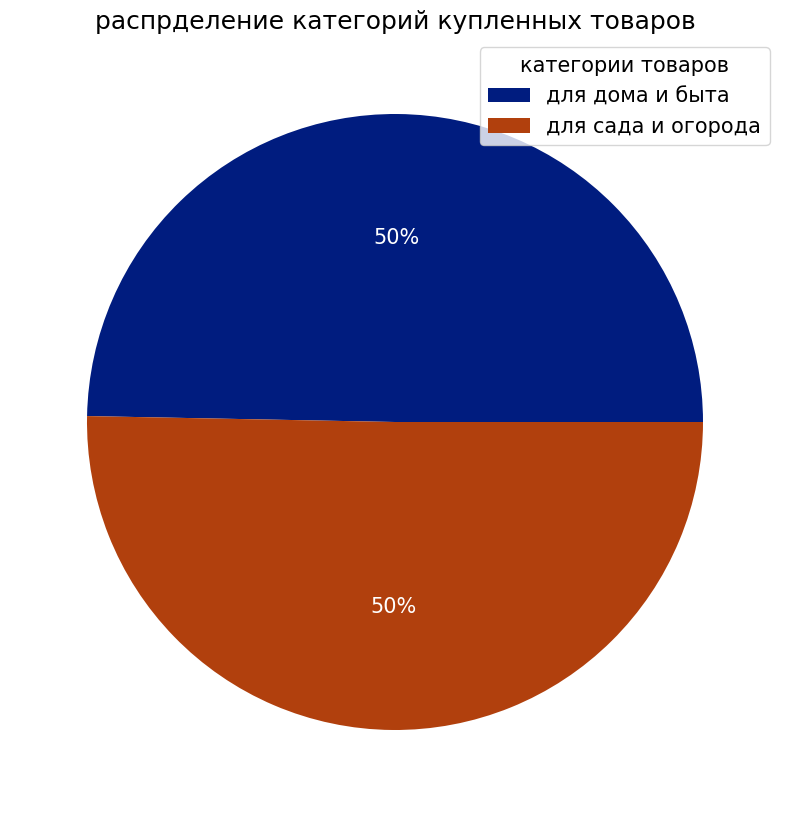

In [103]:
plt.figure(figsize = (15,10))#зададим размер графика 
sns.set_palette('dark') #выберим стиль графика
plt.pie(type_goods_quant['customer_id'] , autopct='%.0f%%',textprops={'color':"w"})
plt.legend(labels = type_goods_quant['type'], title="категории товаров")#построим курговую диаграмму
plt.title('распрделение категорий купленных товаров')#установим название графика
plt.show;

По диаграмме можно наблюдать, что количетство проданных товаров распредлено по ровну между категориями

Проверим месячную динамику продажи товаров по категориям

#### Определение динамики медианного по категориям

**Рассмотрим динамику для медианного чека для категорий в различных временных разрезах**

In [104]:
month_type = data_filt.groupby(['year','month','type', 'order_id'], as_index = False).agg({'reciept':'sum'})
month_type = month_type .groupby(['year','month','type'], as_index = False).agg({'reciept':'median'})

In [105]:
month_type['date'] = month_type[['month', 'year']].apply(lambda x: '-'.join(x.values.astype(str)), axis = 'columns')
month_type['date'] = pd.to_datetime(month_type['date'])

In [106]:
housekeeping_dynamics = month_type.query('type == "для дома и быта"')

In [107]:
garden_dynamics = month_type.query('type == "для сада и огорода"')

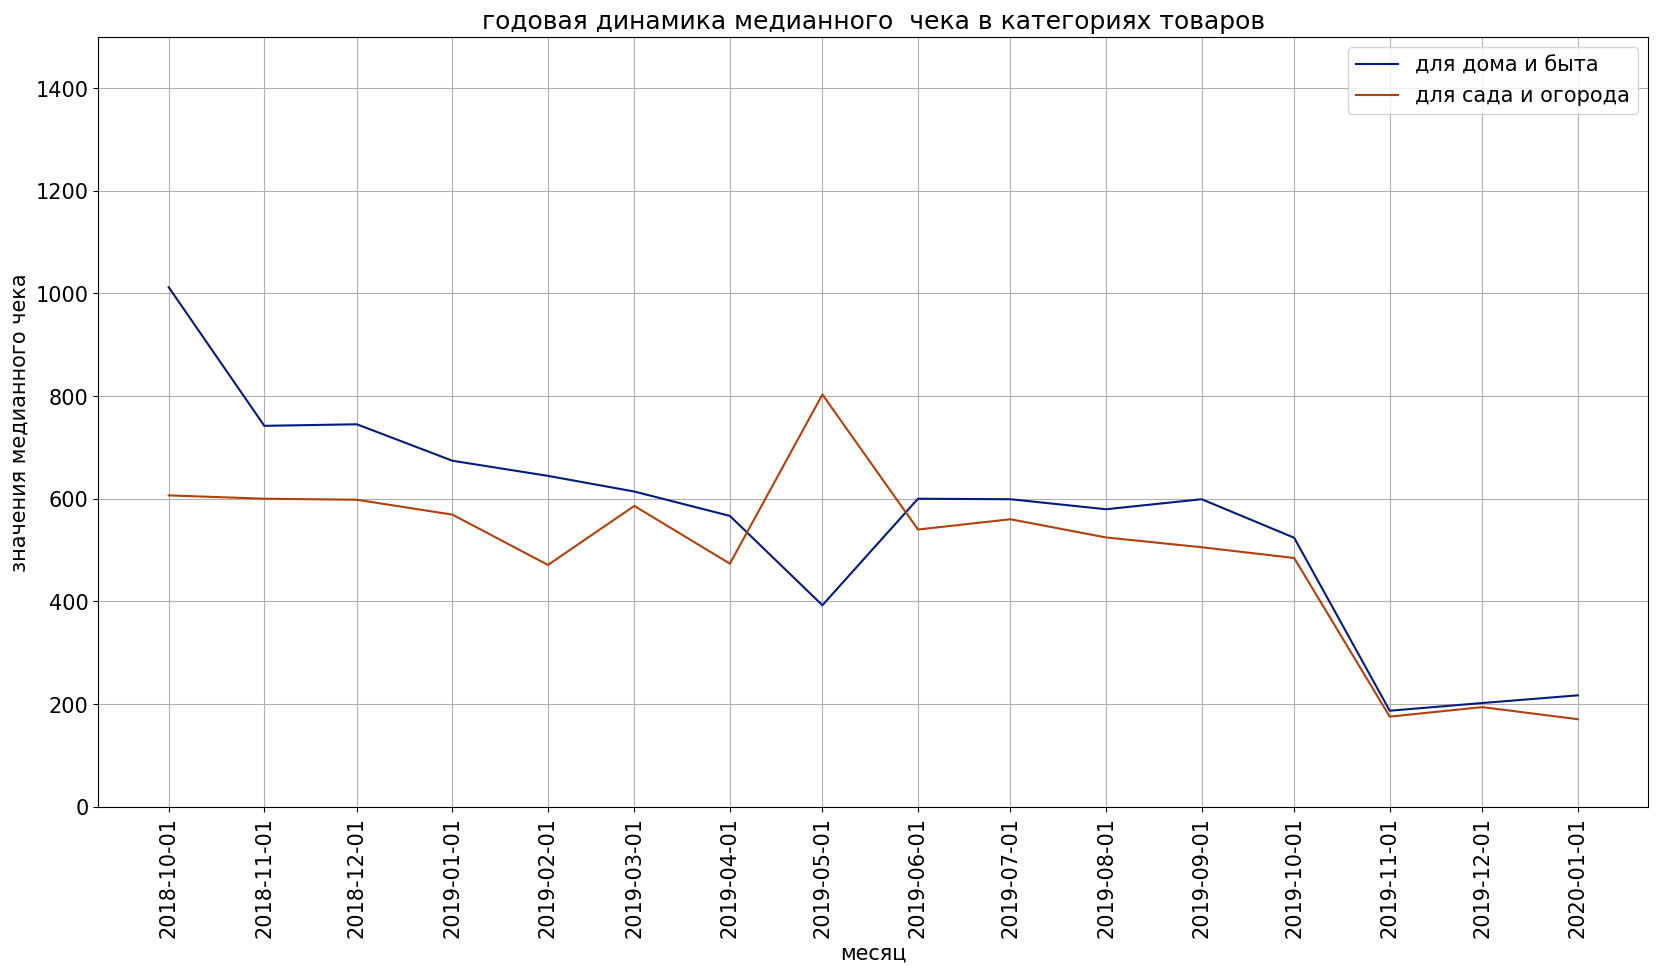

In [108]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize = (20,10))
plt.grid(True)
plt.plot(housekeeping_dynamics['date'], housekeeping_dynamics['reciept'], label ='для дома и быта')
plt.plot(garden_dynamics['date'], garden_dynamics['reciept'], label='для сада и огорода')
plt.xticks(garden_dynamics['date'], rotation = 90)
plt.ylim(0, 1500)
plt.title('годовая динамика медианного  чека в категориях товаров')
plt.xlabel('месяц')
plt.ylabel('значения медианного чека')
plt.legend() 
plt.show()

Для каетгории 'для дома и быта' значения медианной выручки для категории 'для дома и быта снижаются от начала периода данных до мая 2019 года, затем восстанавливаются  до плато в течении июня-октября 2019. В ноябре наблюдается значительное снижение с медленным востановлением к концу года.  
Для категории 'для сада и огорода' значения медианной выручки на клиента стабильны в районе 600 до мая 2019, когда наблюдается максимальный пик значения. После наблюдается медленное снижение до октября 2019 год, с резким снижением в ноябре 2019 года, с последующей стабилизацией на минимальных значениях.

In [109]:
weekday_type = data_filt.groupby(['weekday','type','order_id'], as_index = False).agg({'reciept':'sum'})
weekday_type = weekday_type.groupby(['weekday', 'type'], as_index = False).agg({'reciept':'median'})

In [110]:
week_housekeeping = weekday_type.query('type == "для дома и быта"')
week_garden = weekday_type.query('type == "для сада и огорода"')

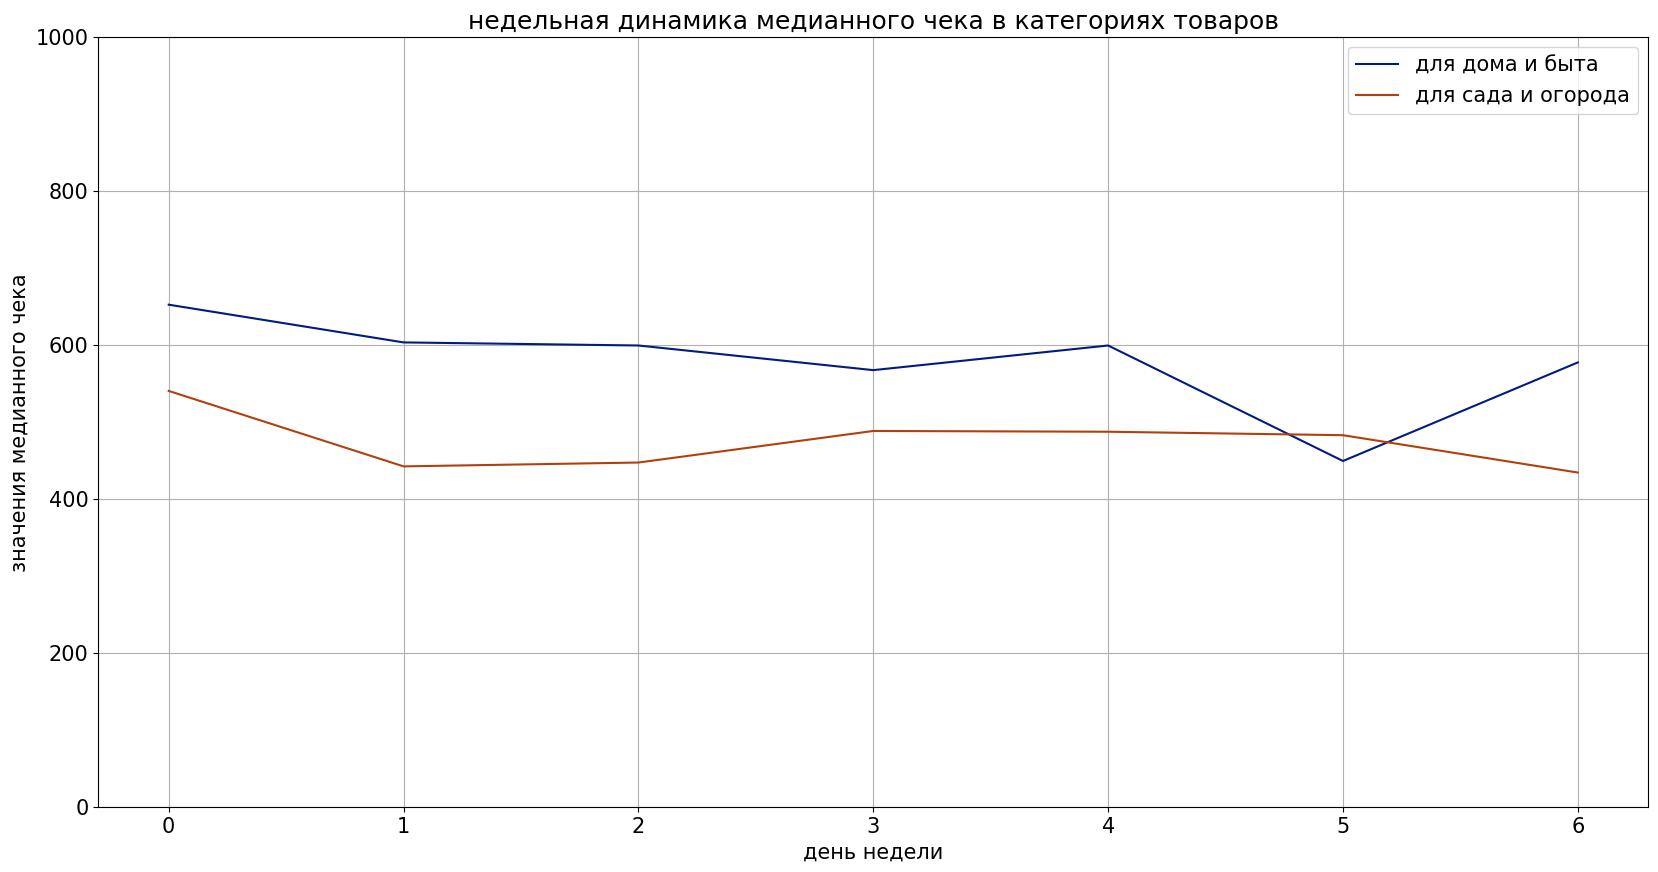

In [111]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize = (20,10))
plt.grid(True)
plt.plot(week_housekeeping['weekday'], week_housekeeping['reciept'], label ='для дома и быта')
plt.plot(week_garden['weekday'], week_garden['reciept'], label='для сада и огорода')
plt.title('недельная динамика медианного чека в категориях товаров')
plt.ylim(0, 1000)
plt.xlabel('день недели')
plt.ylabel('значения медианного чека')
plt.legend() 
plt.show()

Значения медианного чека  в категории 'дя дома и быта имеет небольшую тенденцию к снижению в течении всей недели, с небольшим провалом в субботу, и воскрестным восстановлением.
Для категории 'для сада и огорода' значительных колебаний в течении недели нет.

In [112]:
median_reciept_hour_type = data_filt.groupby(['hour', 'type', 'order_id'], as_index = False).agg({'reciept':'sum'})
median_reciept_hour_type = median_reciept_hour_type.groupby(['hour', 'type'], as_index = False).agg({'reciept':'median'})

In [113]:
hour_housekeeping = median_reciept_hour_type.query('type == "для дома и быта"')
hour_garden = median_reciept_hour_type.query('type == "для сада и огорода"')

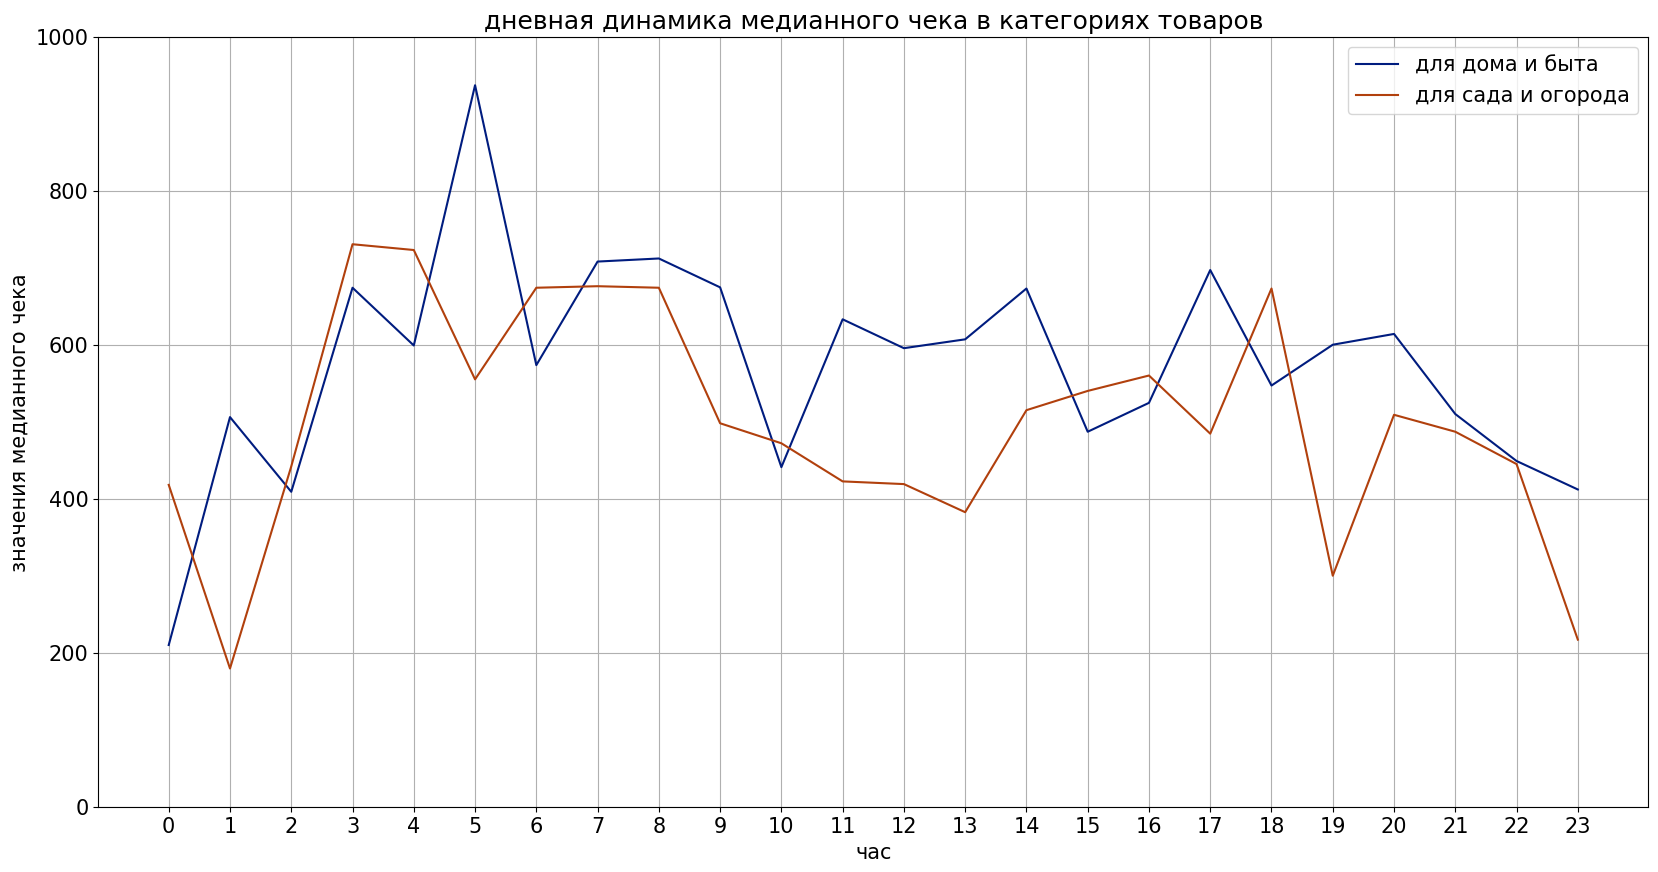

In [114]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize = (20,10))
plt.grid(True)
plt.plot(hour_housekeeping['hour'], hour_housekeeping['reciept'], label ='для дома и быта')
plt.plot(hour_garden['hour'], hour_garden['reciept'], label='для сада и огорода')
plt.title('дневная динамика медианного чека в категориях товаров')
plt.xticks(hour_garden['hour'])
plt.ylim(0, 1000)
plt.xlabel('час')
plt.ylabel('значения медианного чека')
plt.legend() 
plt.show()

Для категории 'для дома и быта' наибольший пик значений медианного чека приходится на 5 часов утра. Затем снижение в корридор 600 - 800 с небольшим пиком в конце рабочего дня с дальнейшим снижением.
Для категории 'для сада и огорода' наблюдается несколько пиков: в 3-4 часа, в 8 часов и 18 часов. 

#### Определение динамики медианной выручки на одного клиента по категориям

Определим динамеческие показатели выручки на одного клиента

Зададим функцию для определения медианной выручки на одного клиента в различные периоды:

In [115]:
    def annual_dynamic_profit_per_customer(data):
        median_profit_annual = data.groupby(['year','month','customer_id'], as_index = False).agg({'reciept':'sum'})
        median_profit_annual.rename(columns = {'reciept':'profit'}, inplace = True)
        median_profit_annual['date'] = median_profit_annual[['month', 'year']].apply(lambda x: '-'.join(x.values.astype(str)), axis = 'columns')
        median_profit_annual['date'] = pd.to_datetime(median_profit_annual['date'])
        median_profit_annual = median_profit_annual.groupby(['date', t], as_index = False).agg({'profit':'sum', 'customer_id':'nunique'})
        median_profit_annual['profit_per_user'] = median_profit_annual['profit'] /  median_profit_annual['customer_id']
        return median_profit_annual

In [116]:
def median_profit_dynamics_year (data, period1, period2):
    median_profit = data.groupby([period1, period2,'customer_id', 'type'], as_index = False).agg({'reciept':'sum'})
    median_profit.rename(columns = {'reciept':'profit'}, inplace = True)
    median_profit['date'] = median_profit[[period1, period2]].apply(lambda x: '-'.join(x.values.astype(str)), axis = 'columns')
    median_profit['date'] = pd.to_datetime(median_profit['date'])
    median_profit = median_profit.groupby(['date', 'type'], as_index = False).agg({'profit':'sum', 'customer_id':'nunique'})
    median_profit['profit_per_user'] = median_profit['profit'] /  median_profit['customer_id']
    housekeeping = median_profit.query('type == "для дома и быта"')
    garden = median_profit.query('type == "для сада и огорода"')
    return housekeeping, garden 

In [117]:
def median_profit_dynamics (data, period):
    median_profit = data.groupby([period,'customer_id', 'type'], as_index = False).agg({'reciept':'sum'})
    median_profit.rename(columns = {'reciept':'profit'}, inplace = True)
    median_profit = median_profit.groupby([period, 'type'] , as_index = False).agg({'profit':'sum', 'customer_id':'nunique'})
    median_profit['profit_per_user'] = median_profit['profit'] /  median_profit['customer_id']
    housekeeping = median_profit.query('type == "для дома и быта"')
    garden = median_profit.query('type == "для сада и огорода"')
    return housekeeping, garden 

Получим данные о медианной выручке на одного клиента в месячном разрезе:

In [118]:
housekeeping_annual_dyn, garden_annual_dyn = median_profit_dynamics_year (data_filt, 'year','month')

Построим график медианной выручки на клиента по месяцам по двум категориям товаров

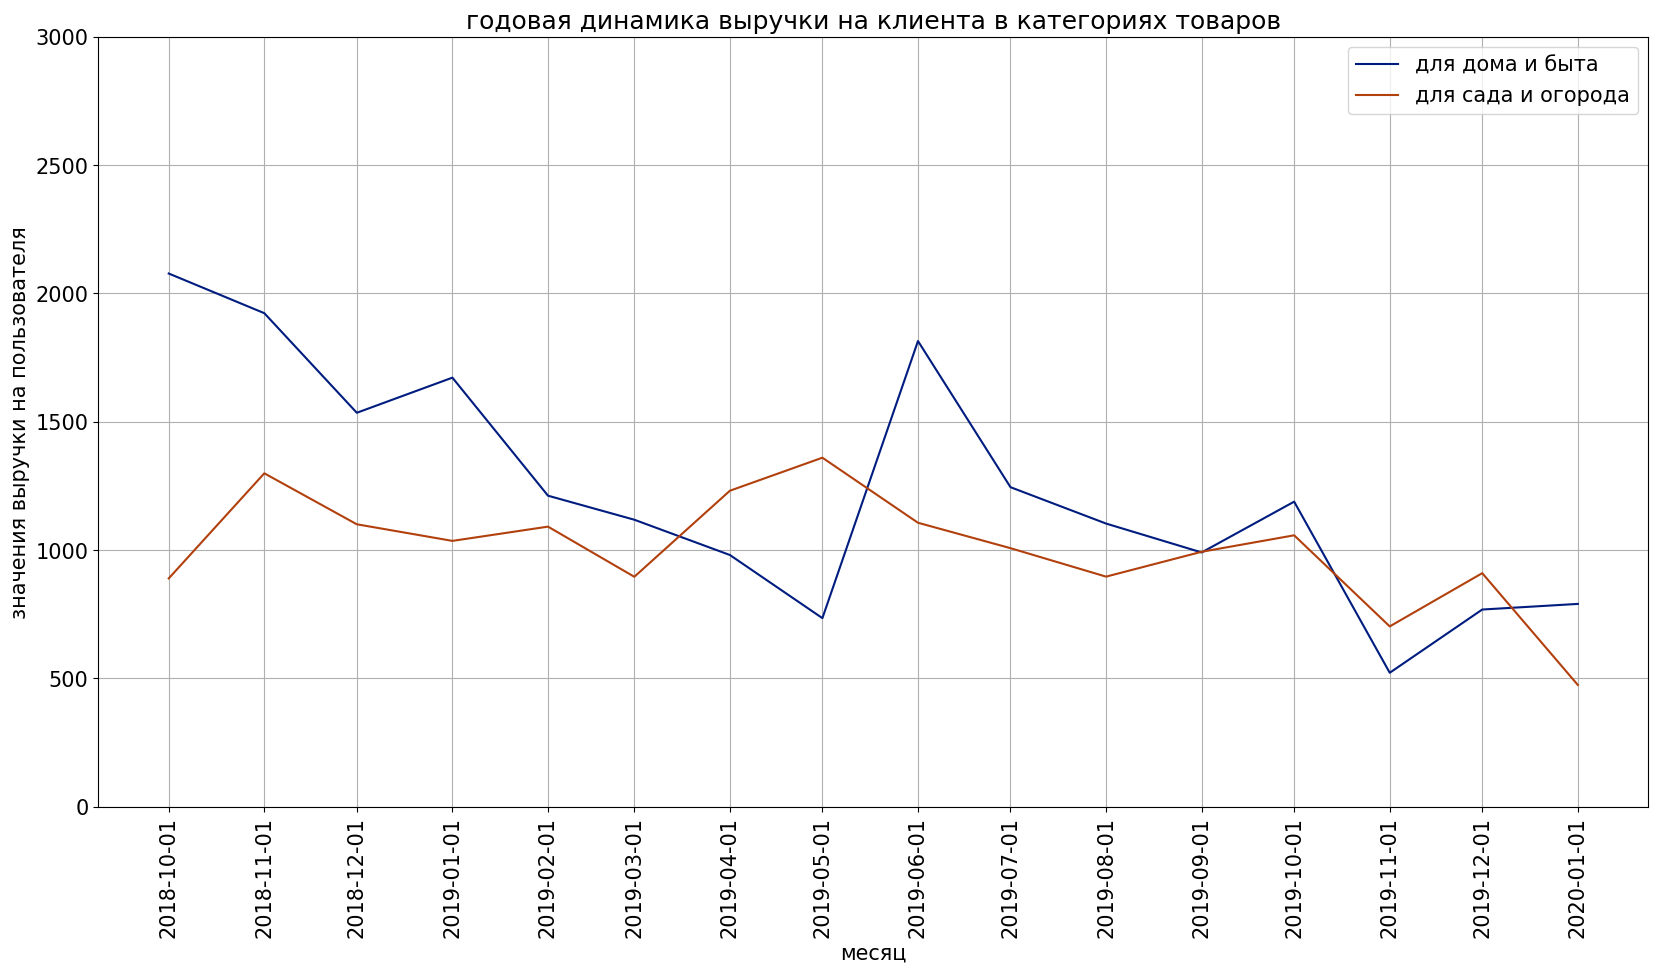

In [119]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize = (20,10))
plt.grid(True)
plt.plot(housekeeping_annual_dyn['date'], housekeeping_annual_dyn['profit_per_user'], label ='для дома и быта')
plt.plot(garden_annual_dyn['date'], garden_annual_dyn['profit_per_user'], label='для сада и огорода')
plt.title('годовая динамика выручки на клиента в категориях товаров')
plt.xticks(garden_annual_dyn['date'], rotation = 90)
plt.ylim(0, 3000)
plt.xlabel('месяц')
plt.ylabel('значения выручки на пользователя')
plt.legend() 
plt.show()

Для каетгории 'для дома и быта' значения выручки на пользователя категории 'для дома и быта снижаются от начала периода данных до мая 2019 года, затем восстанавливаются  до плато в течении июня-октября 2019. В ноябре наблюдается значительное снижение с медленным востановлением к концу года.  
Для категории 'для сада и огорода' значения  выручки  на клиента стабильны в районе 1000 до мая 2019, когда наблюдается максимальный пик значения. После наблюдается медленное снижение до октября 2019 год, с снижением в ноябре 2019 года.

Получим данные о медианной выручке в разрезе недели

In [120]:
housekeeping_week_dyn, garden_week_dyn = median_profit_dynamics (data_filt, 'weekday')

Построим график медианной выручки на клиента по дням недели:

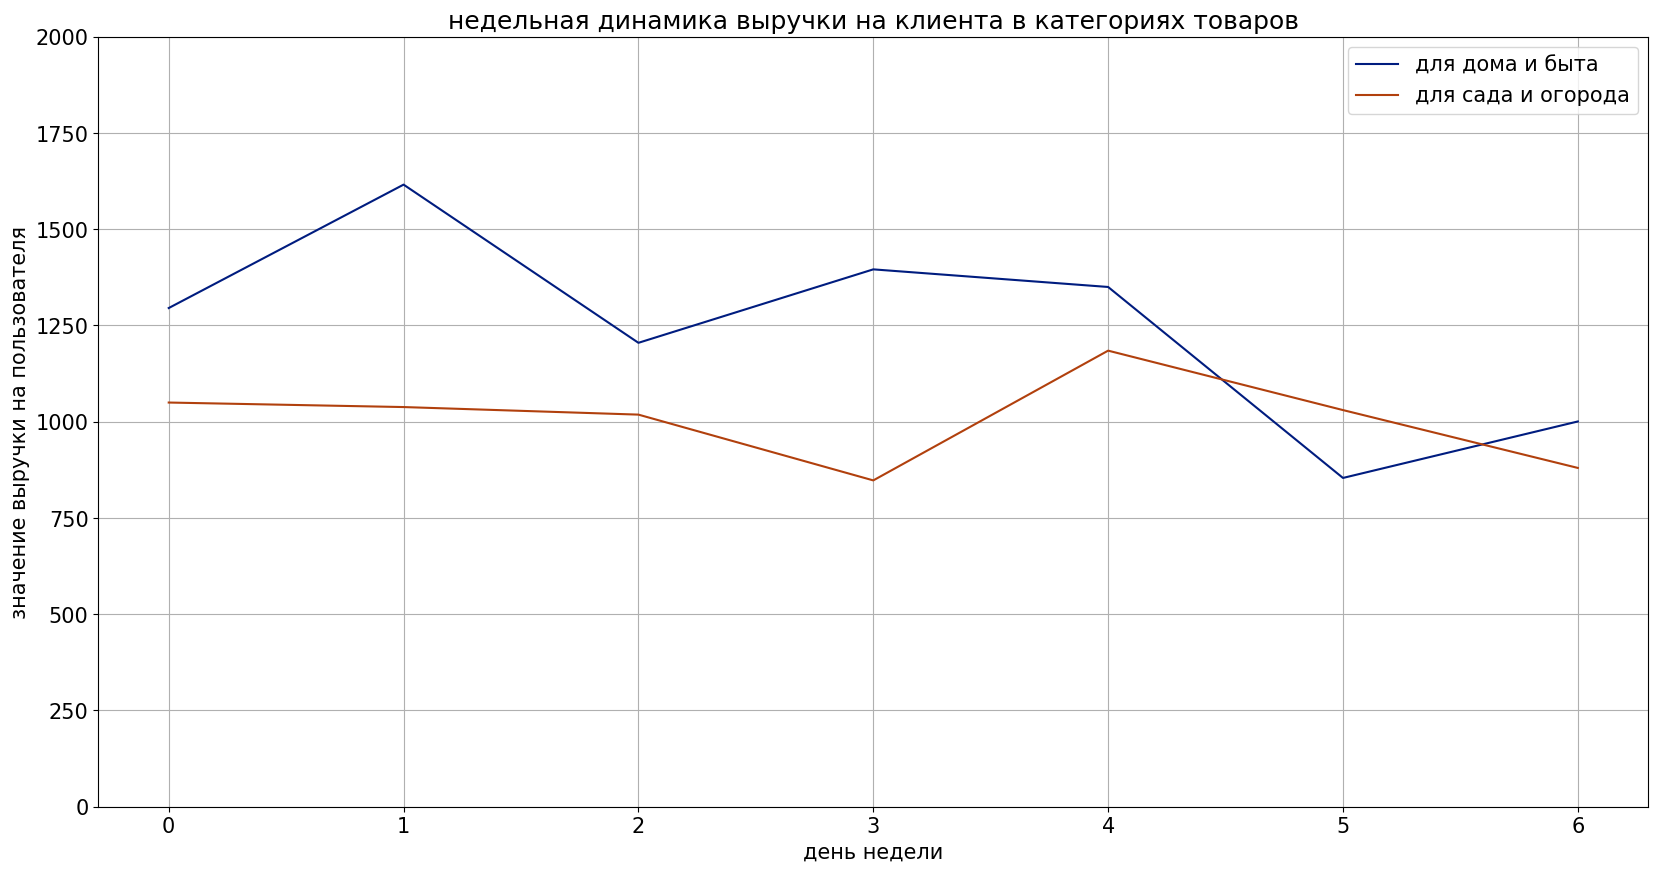

In [121]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize = (20,10))
plt.grid(True)
plt.plot(housekeeping_week_dyn['weekday'], housekeeping_week_dyn['profit_per_user'], label ='для дома и быта')
plt.plot(garden_week_dyn['weekday'], garden_week_dyn['profit_per_user'], label='для сада и огорода')
plt.ylim(0, 2000)
plt.title('недельная динамика выручки на клиента в категориях товаров')
plt.xlabel('день недели')
plt.ylabel('значение выручки на пользователя')
plt.legend() 
plt.show()

Выручка на пользователя в категории 'дя дома и быта имеет небольшую тенденцию к снижению в течении всей недели, с небольшим провалом в субботу, и воскрестным восстановлением.
Для категории 'для сада и огорода' наблюдается небольшой провал в четверг и рост до максимального значения в пятнцу, с последующим снижением в выходные.

Получим данные по медианной выручке на клиента в часовом разрезе:

In [122]:
housekeeping_day_dyn, garden_day_dyn = median_profit_dynamics (data_filt, 'hour')

Построим график по часам:

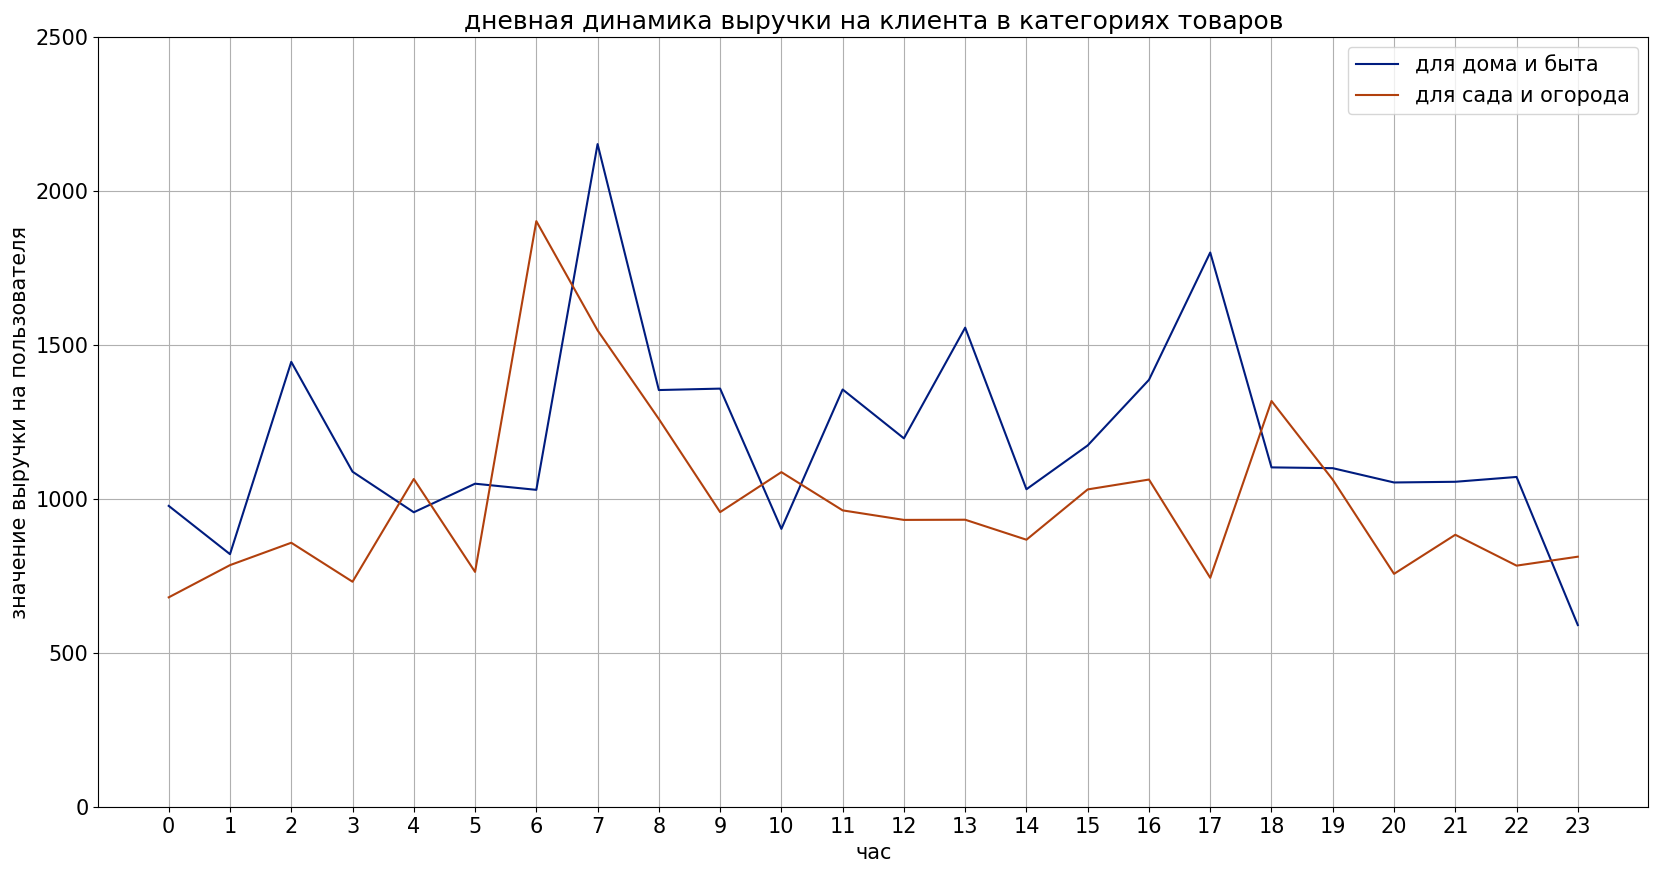

In [123]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize = (20,10))
plt.grid(True)
plt.plot(housekeeping_day_dyn['hour'], housekeeping_day_dyn['profit_per_user'], label ='для дома и быта')
plt.plot(garden_day_dyn['hour'], garden_day_dyn['profit_per_user'], label='для сада и огорода')
plt.ylim(0, 2500)
plt.xticks(garden_day_dyn['hour'])
plt.title('дневная динамика выручки на клиента в категориях товаров')
plt.xlabel('час')
plt.ylabel('значение выручки на пользователя')
plt.legend() 
plt.show()

Для категории 'для дома и быта' наибольший пик выручки на пользователя приходится на 7 часов утра. Затем снижение в корридор 1000 - 1500 с пиком в конце рабочего дня с дальнейшим снижением.
Для категории 'для сада и огорода' значения выручки на пользователя ведут себя схожим образом: наибольший пик в 6 утра, меньший в конце рабочего дня в 18 часов  

Зададим функцию для опеределения абсолютной выручки в различные периоды:

In [124]:
def profit_dynamics_annual (data, period1, period2):
    median_profit = data.groupby([period1, period2, 'type'], as_index = False).agg({'reciept':'sum'})
    median_profit.rename(columns = {'reciept':'profit'}, inplace = True)
    median_profit['date'] = median_profit[[period1, period2]].apply(lambda x: '-'.join(x.values.astype(str)), axis = 'columns')
    median_profit['date'] = pd.to_datetime(median_profit['date'])
    housekeeping = median_profit.query('type == "для дома и быта"')
    garden = median_profit.query('type == "для сада и огорода"')
    return housekeeping, garden 

In [125]:
def profit_dynamics (data, period):
    median_profit = data.groupby([period, 'type'], as_index = False).agg({'reciept':'sum'})
    median_profit.rename(columns = {'reciept':'profit'}, inplace = True)
    housekeeping = median_profit.query('type == "для дома и быта"')
    garden = median_profit.query('type == "для сада и огорода"')
    return housekeeping, garden 

In [126]:
profit_annaual_housekeeping, profit_annual_garden = profit_dynamics_annual (data_filt, 'year', 'month')

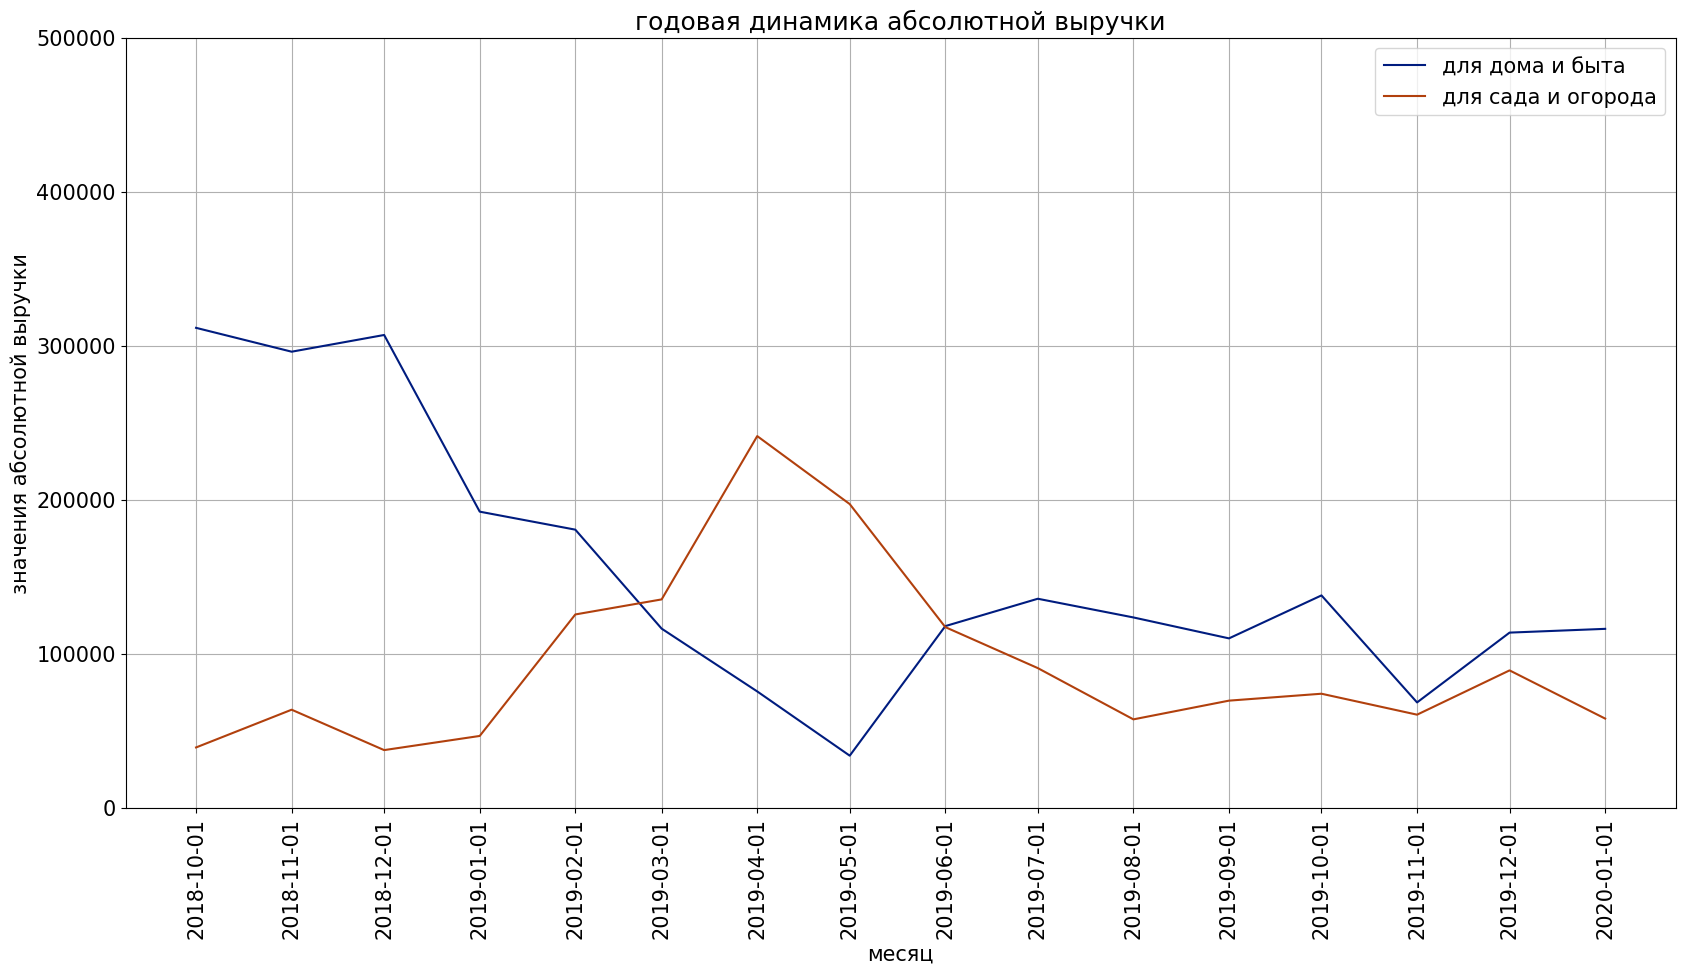

In [127]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize = (20,10))
plt.grid(True)
plt.plot(profit_annaual_housekeeping['date'], profit_annaual_housekeeping['profit'], label ='для дома и быта')
plt.plot(profit_annual_garden['date'], profit_annual_garden['profit'], label='для сада и огорода')
plt.title('годовая динамика абсолютной выручки')
plt.xticks(garden_annual_dyn['date'], rotation = 90)
plt.ylim(0, 500000)
plt.xlabel('месяц')
plt.ylabel('значения абсолютной выручки')
plt.legend() 
plt.show()

Для категории 'для дома и быта' наблюдается негативная динамика на всем протяжении исследуемого периода. Наибольшие значения абсолютной выручки находятся в октябре - декабре 2018 года. С января 2019 года происходит снижение до минимального значения в мае 2019 года. С июня 2019 года выручка выходит на плато и с небольшими колебаниями держится в окрестностях 100000 до конца исследуемого периода. 
В категории 'для сада и огорода' в 2018 году наблюдаются минимальные значения абсолютной выручки. С января 2019 года обнаруживается рост с пиком в апреле 2019 года. После пика происходит снижение до августа 2018. Далее выручка выходит на плато с незначительными колебаниями до конца исследуемого периода.

In [128]:
week_profit_dyn_housekeeping, week_profit_dyn_garden  = profit_dynamics (data_filt, 'weekday')

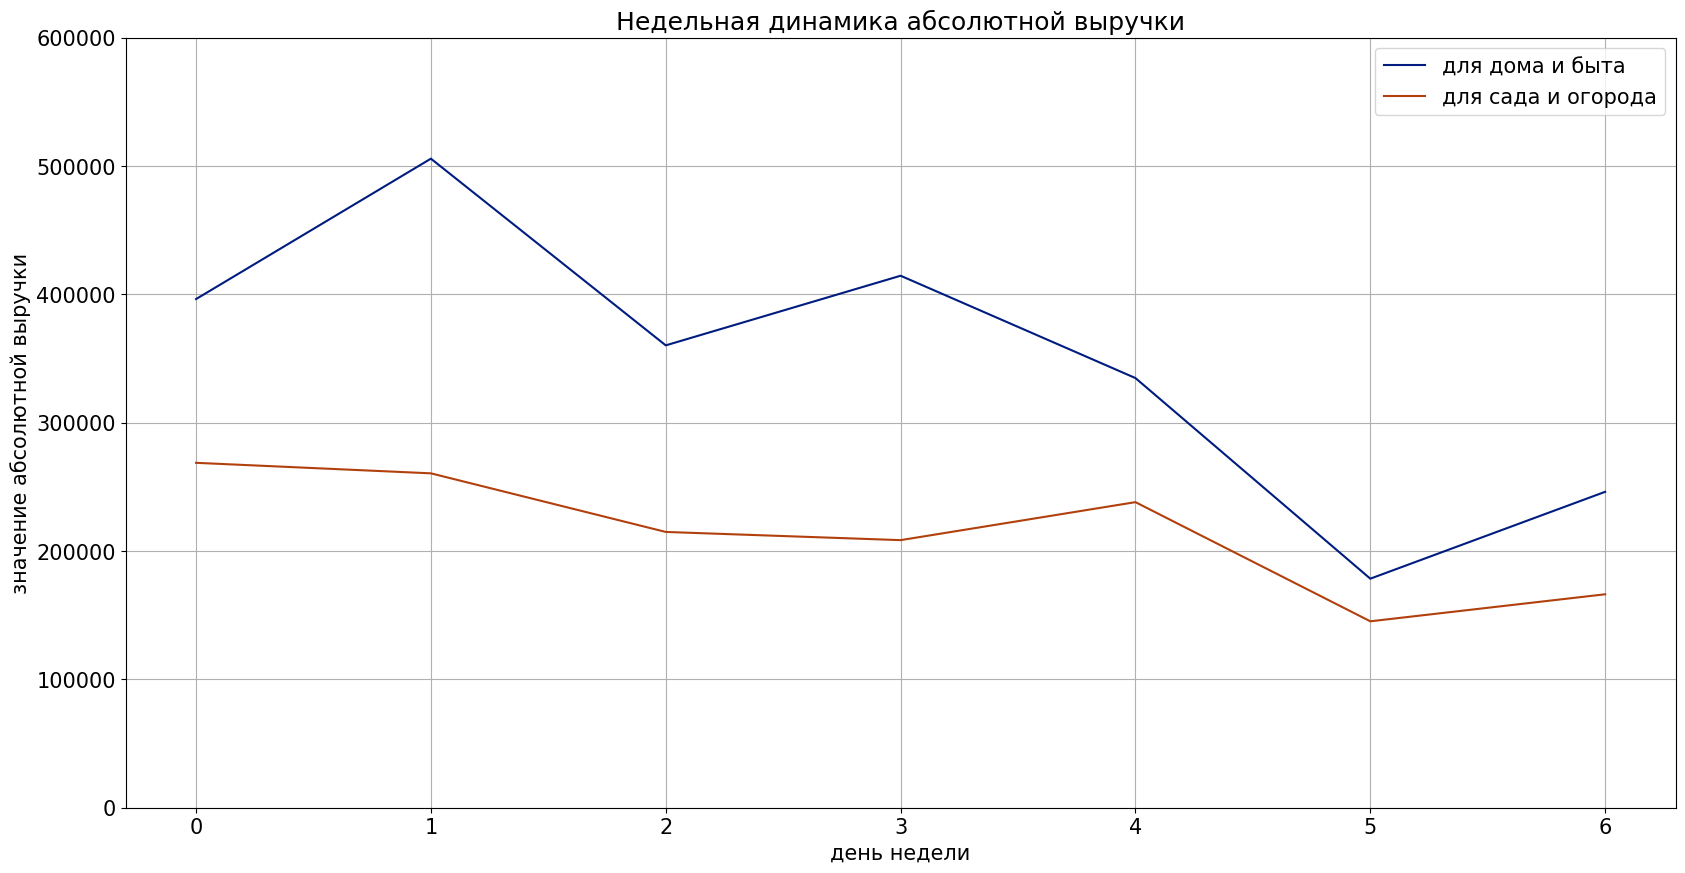

In [129]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize = (20,10))
plt.grid(True)
plt.plot(week_profit_dyn_housekeeping['weekday'], week_profit_dyn_housekeeping['profit'], label ='для дома и быта')
plt.plot(week_profit_dyn_garden['weekday'], week_profit_dyn_garden['profit'], label='для сада и огорода')
plt.title('Недельная динамика абсолютной выручки')
plt.xticks(week_profit_dyn_garden['weekday'])
plt.ylim(0, 600000)
plt.xlabel('день недели')
plt.ylabel('значение абсолютной выручки')
plt.legend() 
plt.show()

Для категории 'для дома и быта' наблюдается тендения к снижению выручки на протяжении всей недели. Наибольшее значение выручки в категории наблюдается во вторник, наменьшее в субботу с небольшим востановлением в воскресенье.  
В категории 'для сада и огорода' так же наблюдается недельное снижение, хоть и с меньшим градиентом. Наименьшее значение так же наблюдается в субботу.

In [130]:
day_profit_dyn_housekeeping, day_profit_dyn_garden  = profit_dynamics (data_filt, 'hour')

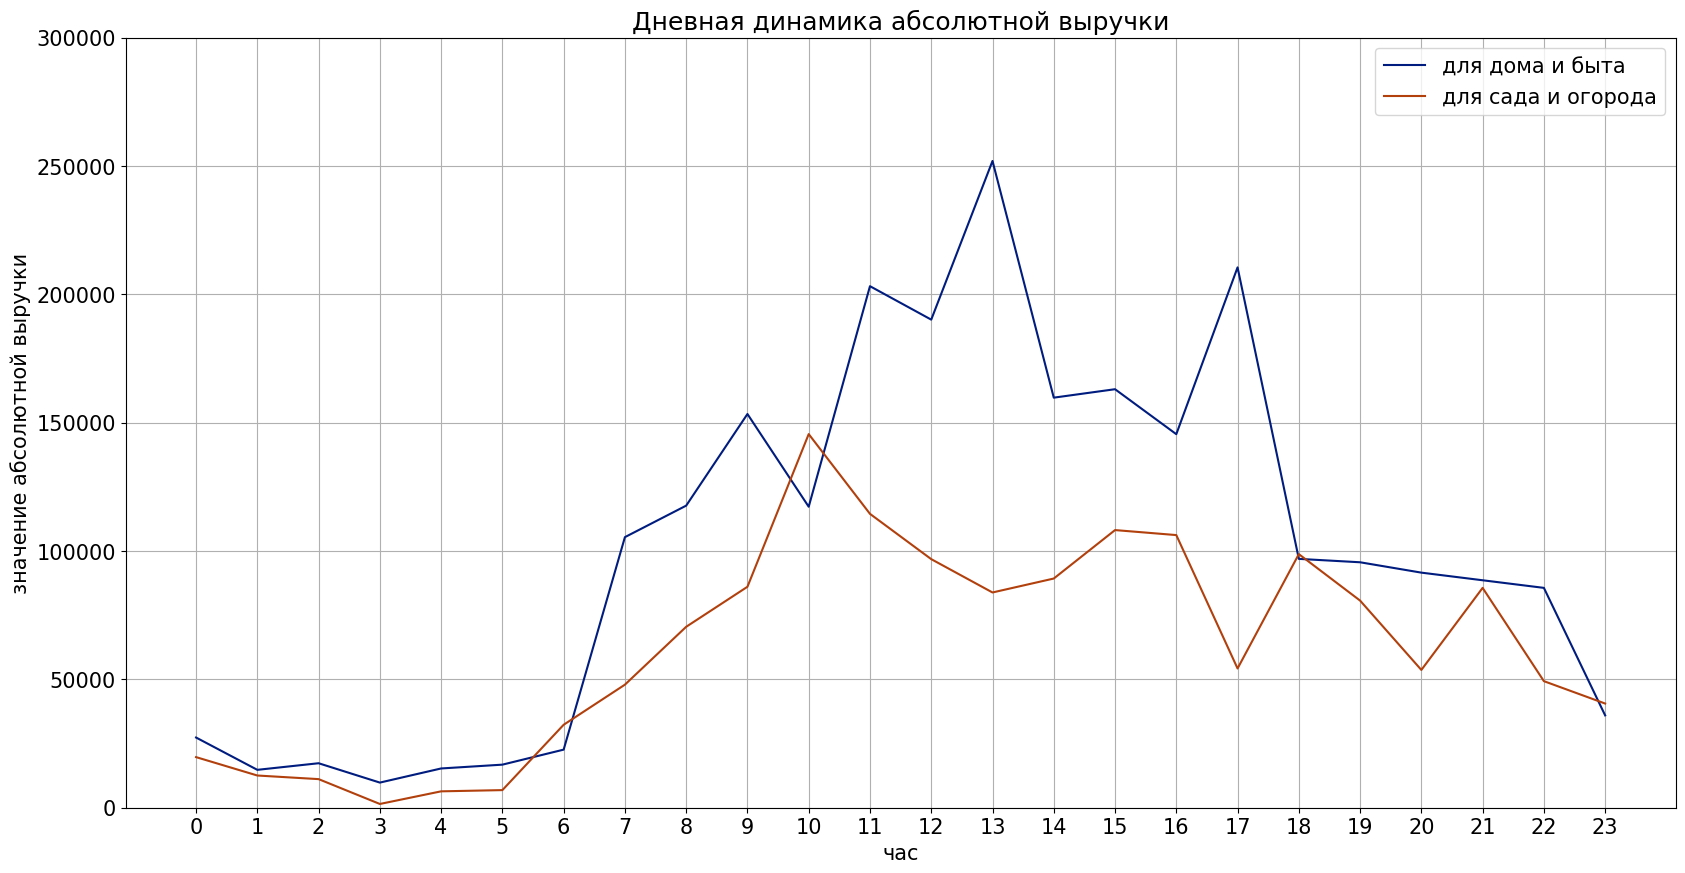

In [131]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize = (20,10))
plt.grid(True)
plt.plot(day_profit_dyn_housekeeping['hour'], day_profit_dyn_housekeeping['profit'], label ='для дома и быта')
plt.plot(day_profit_dyn_garden['hour'], day_profit_dyn_garden['profit'], label='для сада и огорода')
plt.title('Дневная динамика абсолютной выручки')
plt.xticks(day_profit_dyn_garden['hour'])
plt.ylim(0, 300000)
plt.xlabel('час')
plt.ylabel('значение абсолютной выручки')
plt.legend() 
plt.show()

В категории 'для дома и быта' минимальные значения абсолютной выручки наблюдаются в ночные часы до 6 часов утра. С 7 часов наблюдается быстрый рост абсолютной выручки, который достигает пика в 13 часов. После с 14 по 16 часов наблюдется спад. В 17 часов виден последний пик за день, с последующим снижением к концу дня.  
В категории 'для сада и огорода' также наблюдается минимальные значения абсолютной выручки в ночные часы до 5 часов утра.  С пяти часов утра наблюдается рост с пиком в 10 часов утра. После наблюдается снижение с колебаниями до конца дня.

### Сегментация клиентов при помощи ABC-анализа

Произведем сегементацию клиентов по выручке при помощи ABC-анализа.

Рассчитаем какую выручку принес каждый клиент:

In [132]:
categorization = data_filt.groupby('customer_id', as_index = False) \
.agg({'reciept':'sum'}) \
.sort_values(by = 'reciept', ascending = False) \
.reset_index(drop = True)

При помощи бибиотеки abc-analysis произведем сегмнетацию на A, B, C сегменты клиентв по их выручке 

In [133]:
abc = abc_analysis(categorization['reciept'])

In [134]:
a_index = abc['Aind']
b_index = abc['Bind']
c_index = abc['Cind']

cond_list = [categorization.index.isin(a_index),
            categorization.index.isin(b_index),
            categorization.index.isin(c_index)]
segment_list = ['A', 'B', 'C']
categorization['category'] = np.select(cond_list, segment_list)

Перенесем сегменты в исходный датафрейм по средством merge

In [135]:
data_filt = data_filt.merge(categorization, on = 'customer_id')

In [136]:
data_filt.customer_id.nunique()

2430

In [137]:
categorization.customer_id.nunique()

2430

Выведим получившийся датафрейм

In [138]:
data_filt.head(10)

,date,customer_id,order_id,product,quantity,price,date_full,month,weekday,hour,year,reciept_x,product_def,type,reciept_y,category
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,2018-10-01 00:00:00,10,0,0,2018,142.0,комнатное,для сада и огорода,1037.0,C
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194.0,2018-10-01 00:00:00,10,0,0,2018,194.0,комнатное,для сада и огорода,1037.0,C
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.0,2018-10-01 00:00:00,10,0,0,2018,112.0,радермахера,для дома и быта,1037.0,C
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.0,2018-10-01 00:00:00,10,0,0,2018,179.0,хризолидокарпус,для сада и огорода,1037.0,C
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.0,2018-10-01 00:00:00,10,0,0,2018,112.0,циперус,для сада и огорода,1037.0,C
5,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,шеффлера лузеана d-9 см,1,164.0,2018-10-01 00:00:00,10,0,0,2018,164.0,шеффлера,для сада и огорода,1037.0,C
6,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,юкка нитчатая d-12 см h-25-35 см,1,134.0,2018-10-01 00:00:00,10,0,0,2018,134.0,юкка,для сада и огорода,1037.0,C
7,2018100108,375e0724-f033-4c76-b579-84969cf38ee2,68479,настенная сушилка для белья gimi brio super 100,1,824.0,2018-10-01 08:00:00,10,0,8,2018,824.0,настенная,для дома и быта,824.0,C
8,2018100108,6644e5b4-9934-4863-9778-aaa125207701,68478,"таз пластмассовый 21,0 л круглый ""водолей"" с61...",1,269.0,2018-10-01 08:00:00,10,0,8,2018,269.0,таз,для дома и быта,307.0,C
9,2019103116,6644e5b4-9934-4863-9778-aaa125207701,111409,"рассада дыни сорт казачка, горшок 9*9см",1,38.0,2019-10-31 16:00:00,10,3,16,2019,38.0,сумка-тележка,для дома и быта,307.0,C


**Зададим функции для рассмотрения метрик различных сегментов**:

Зададим функцию для рассмотрения годовой абсолютной выручки в сегментах: 

In [139]:
def cluster_profit_dynamics_annual (types1, types2):
    cluster_profit = data_filt.groupby(['category', 'year', 'month', 'type'], as_index = False).agg({'reciept_x':'sum'})
    cluster_profit['date'] = cluster_profit[['month', 'year']].apply(lambda x: '-'.join(x.values.astype(str)), axis = 'columns')
    cluster_A_profit_h = cluster_profit.query('category == "A" & type == @types1')
    cluster_B_profit_h = cluster_profit.query('category == "B" & type == @types1')
    cluster_C_profit_h = cluster_profit.query('category == "C" & type == @types1')
    cluster_A_profit_g = cluster_profit.query('category == "A" & type == @types2')
    cluster_B_profit_g = cluster_profit.query('category == "B" & type == @types2')
    cluster_C_profit_g = cluster_profit.query('category == "C" & type == @types2')
    plt.rcParams.update({'font.size': 15})
    plt.figure(figsize = (20,10))
    plt.grid(True)
    fig = (plt.plot(cluster_A_profit_h['date'], cluster_A_profit_h['reciept_x'], label = 'A-дом'),
    plt.plot(cluster_B_profit_h['date'], cluster_B_profit_h['reciept_x'], label=  'B-дом'),
    plt.plot(cluster_C_profit_h['date'], cluster_C_profit_h['reciept_x'], label=  'C-дом'),
    plt.plot(cluster_A_profit_g['date'], cluster_A_profit_g['reciept_x'], label=  'A-сад', linestyle = 'dashed'),
    plt.plot(cluster_B_profit_g['date'], cluster_B_profit_g['reciept_x'], label=  'B-сад', linestyle = 'dashed'),
    plt.plot(cluster_C_profit_g['date'], cluster_C_profit_g['reciept_x'], label=  'C-сад', linestyle = 'dashed'))
    plt.title('Годовая динамика абсолютной выручки сегментов')
    plt.xticks(cluster_C_profit_h['date'], rotation = 90)
    plt.ylim(0, 300000)
    plt.xlabel('месяц')
    plt.ylabel('значение абсолютной выручки')
    plt.legend() 
    plt.show()
    return fig

Зададим функуию для рассмотрения абсолютной выручки в различные периоды в сегментах.

In [140]:
def cluster_profit_dynamics_period (types1, types2, period, name, x, ranges):
    cluster_profit = data_filt.groupby(['category', period, 'type'], as_index = False).agg({'reciept_x':'sum'})
    cluster_A_profit_h = cluster_profit.query('category == "A" & type == @types1')
    cluster_B_profit_h = cluster_profit.query('category == "B" & type == @types1')
    cluster_C_profit_h = cluster_profit.query('category == "C" & type == @types1')
    cluster_A_profit_g = cluster_profit.query('category == "A" & type == @types2')
    cluster_B_profit_g = cluster_profit.query('category == "B" & type == @types2')
    cluster_C_profit_g = cluster_profit.query('category == "C" & type == @types2')
    plt.rcParams.update({'font.size': 15})
    plt.figure(figsize = (20,10))
    plt.grid(True)
    fig = (plt.plot(cluster_A_profit_h[period], cluster_A_profit_h['reciept_x'], label = 'A-дом'),
    plt.plot(cluster_B_profit_h[period], cluster_B_profit_h['reciept_x'], label=  'B-дом'),
    plt.plot(cluster_C_profit_h[period], cluster_C_profit_h['reciept_x'], label=  'C-дом'),
    plt.plot(cluster_A_profit_g[period], cluster_A_profit_g['reciept_x'], label=  'A-сад', linestyle = 'dashed'),
    plt.plot(cluster_B_profit_g[period], cluster_B_profit_g['reciept_x'], label=  'B-сад', linestyle = 'dashed'),
    plt.plot(cluster_C_profit_g[period], cluster_C_profit_g['reciept_x'], label=  'C-сад', linestyle = 'dashed'))
    plt.title(name)
    #plt.xticks(cluster_C_profit[period])
    plt.ylim(0, ranges)
    plt.xlabel(x)
    plt.ylabel('значение абсолютной выручки')
    plt.legend() 
    plt.show();
    return fig

Зададим функцию для рассмотрения годовой динамики количествоа единиц товара в различных сегментах:

In [141]:
def cluster_quantity_dynamics_annual (types1, types2, ranges):
    cluster_profit = data_filt.groupby(['category', 'year', 'month', 'type'], as_index = False).agg({'quantity':'sum'})
    cluster_profit['date'] = cluster_profit[['month', 'year']].apply(lambda x: '-'.join(x.values.astype(str)), axis = 'columns')
    cluster_A_profit_h = cluster_profit.query('category == "A" & type == @types1')
    cluster_B_profit_h = cluster_profit.query('category == "B" & type == @types1')
    cluster_C_profit_h = cluster_profit.query('category == "C" & type == @types1')
    cluster_A_profit_g = cluster_profit.query('category == "A" & type == @types2')
    cluster_B_profit_g = cluster_profit.query('category == "B" & type == @types2')
    cluster_C_profit_g = cluster_profit.query('category == "C" & type == @types2')
    plt.rcParams.update({'font.size': 15})
    plt.figure(figsize = (20,10))
    plt.grid(True)
    fig = (plt.plot(cluster_A_profit_h['date'], cluster_A_profit_h['quantity'], label = 'A-дом'),
    plt.plot(cluster_B_profit_h['date'], cluster_B_profit_h['quantity'], label=  'B-дом'),
    plt.plot(cluster_C_profit_h['date'], cluster_C_profit_h['quantity'], label=  'C-дом'),
    plt.plot(cluster_A_profit_g['date'], cluster_A_profit_g['quantity'], label=  'A-сад', linestyle = 'dashed'),
    plt.plot(cluster_B_profit_g['date'], cluster_B_profit_g['quantity'], label=  'B-сад', linestyle = 'dashed'),
    plt.plot(cluster_C_profit_g['date'], cluster_C_profit_g['quantity'], label=  'C-сад', linestyle = 'dashed'))
    plt.title('Годовая динамика суммарного количества единиц товара сегментов')
    plt.xticks(cluster_C_profit_h['date'], rotation = 90)
    plt.ylim(0, ranges)
    plt.xlabel('месяц')
    plt.ylabel('суммарное количетсво единиц товара')
    plt.legend() 
    plt.show();
    return fig

Зададим функцию для рассмотрения динамики абсолютного количества единиц товара в различных сегментах:

In [142]:
def cluster_profit_quantity_period (types1, types2, period, name, x, ranges, metric):
    cluster_profit = data_filt.groupby(['category', period, 'type'], as_index = False).agg({metric:'sum'})
    cluster_A_profit_h = cluster_profit.query('category == "A" & type == @types1')
    cluster_B_profit_h = cluster_profit.query('category == "B" & type == @types1')
    cluster_C_profit_h = cluster_profit.query('category == "C" & type == @types1')
    cluster_A_profit_g = cluster_profit.query('category == "A" & type == @types2')
    cluster_B_profit_g = cluster_profit.query('category == "B" & type == @types2')
    cluster_C_profit_g = cluster_profit.query('category == "C" & type == @types2')
    plt.rcParams.update({'font.size': 15})
    plt.figure(figsize = (20,10))
    plt.grid(True)
    fig = (plt.plot(cluster_A_profit_h[period], cluster_A_profit_h[metric], label = 'A-дом'),
    plt.plot(cluster_B_profit_h[period], cluster_B_profit_h[metric], label=  'B-дом'),
    plt.plot(cluster_C_profit_h[period], cluster_C_profit_h[metric], label=  'C-дом'),
    plt.plot(cluster_A_profit_g[period], cluster_A_profit_g[metric], label=  'A-сад', linestyle = 'dashed'),
    plt.plot(cluster_B_profit_g[period], cluster_B_profit_g[metric], label=  'B-сад', linestyle = 'dashed'),
    plt.plot(cluster_C_profit_g[period], cluster_C_profit_g[metric], label=  'C-сад', linestyle = 'dashed'))
    plt.xticks(cluster_C_profit_h[period])
    plt.title(name)
    plt.ylim(0, ranges)
    plt.xlabel(x)
    plt.ylabel('суммарное количетсво единиц товара')
    plt.legend() 
    plt.show()
    return fig

Рассмотрим годовую динамику абсолютной выручки в различных сегментах:

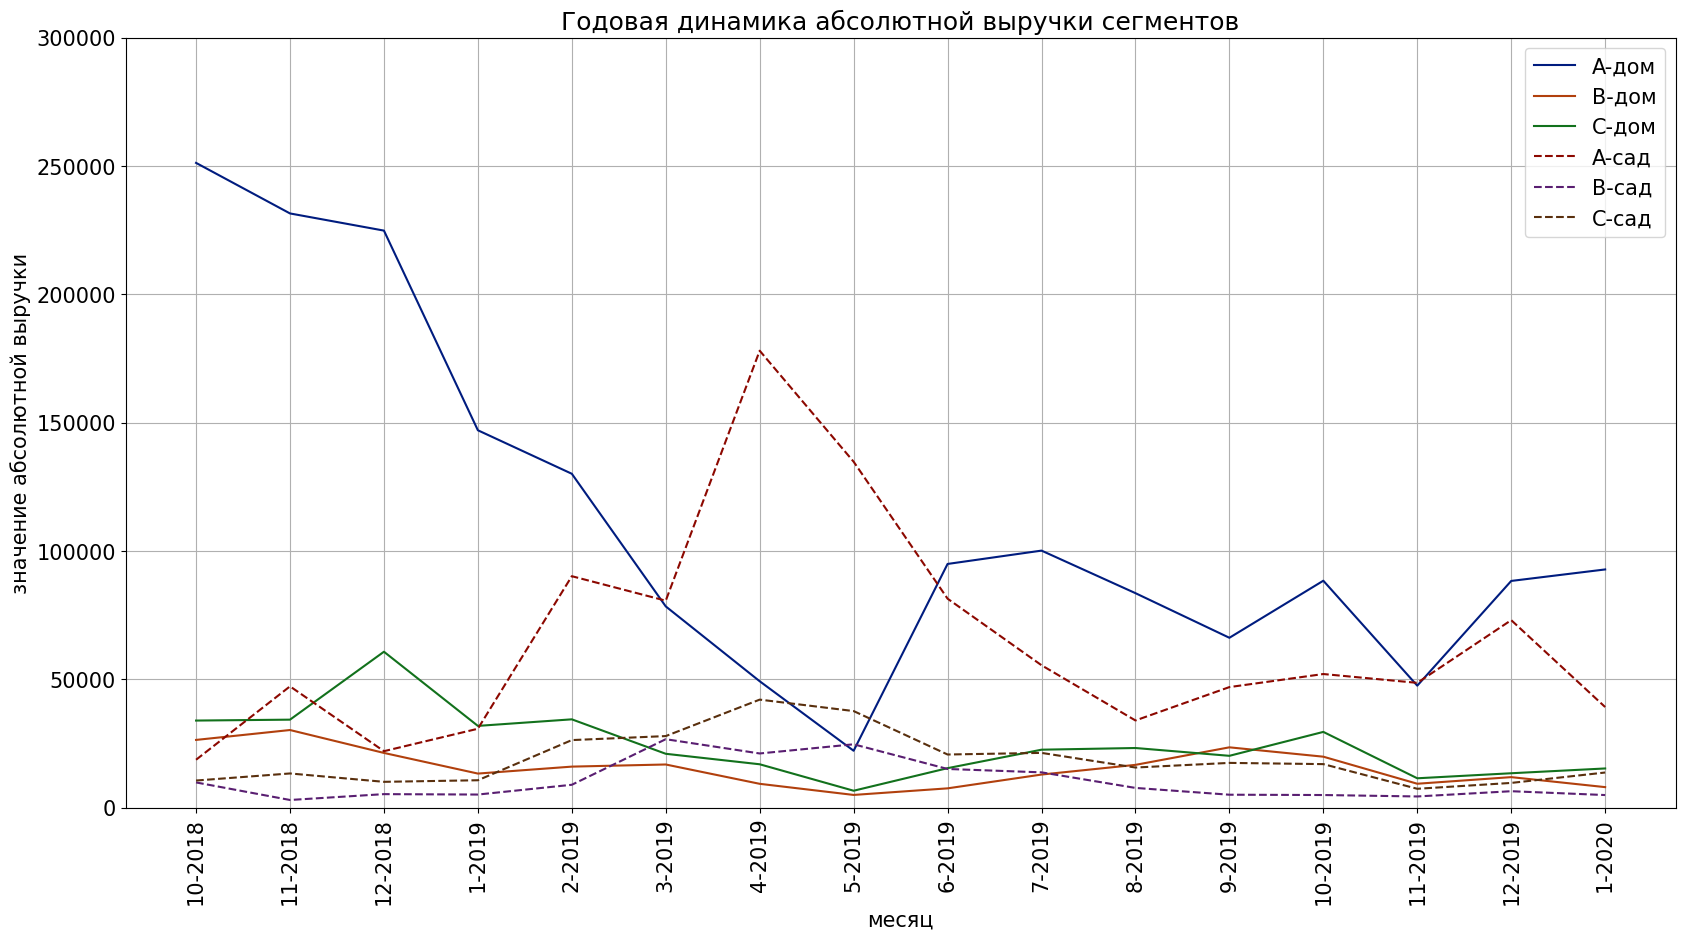

In [162]:
cluster_profit_dynamics_annual ("для дома и быта", "для сада и огорода")
plt.show()

По годовой динамике абсолютной выручки  в обеих категориях выделяются сегменты A.  
В сегменте A категории 'для дома и быта' c начала периода исследования наблюдается быстрое падение значений абсолютной выручки с максимального значения в октябре 2018 года до минимального значения в мае 2019 года. В июня уже наблюдается востановительный рост и стабилизация значений в оставшемся отрезке в корридоре 50000 - 100000.  
В сегменте A категории 'сада и огорода' значение выручки начинает расти с минимальных значений и достигает максимального в апреле 2019 года. После пика начинается снижение до августа 2019 года. С августа 2019 наблюдается стаблизация значений в окрестностях 50000.  
В остальных сегментах колебания не так значительны и значения в целом стабильны.

Рассмотри недельную динамику абсолютной выручки в различных сегментах:

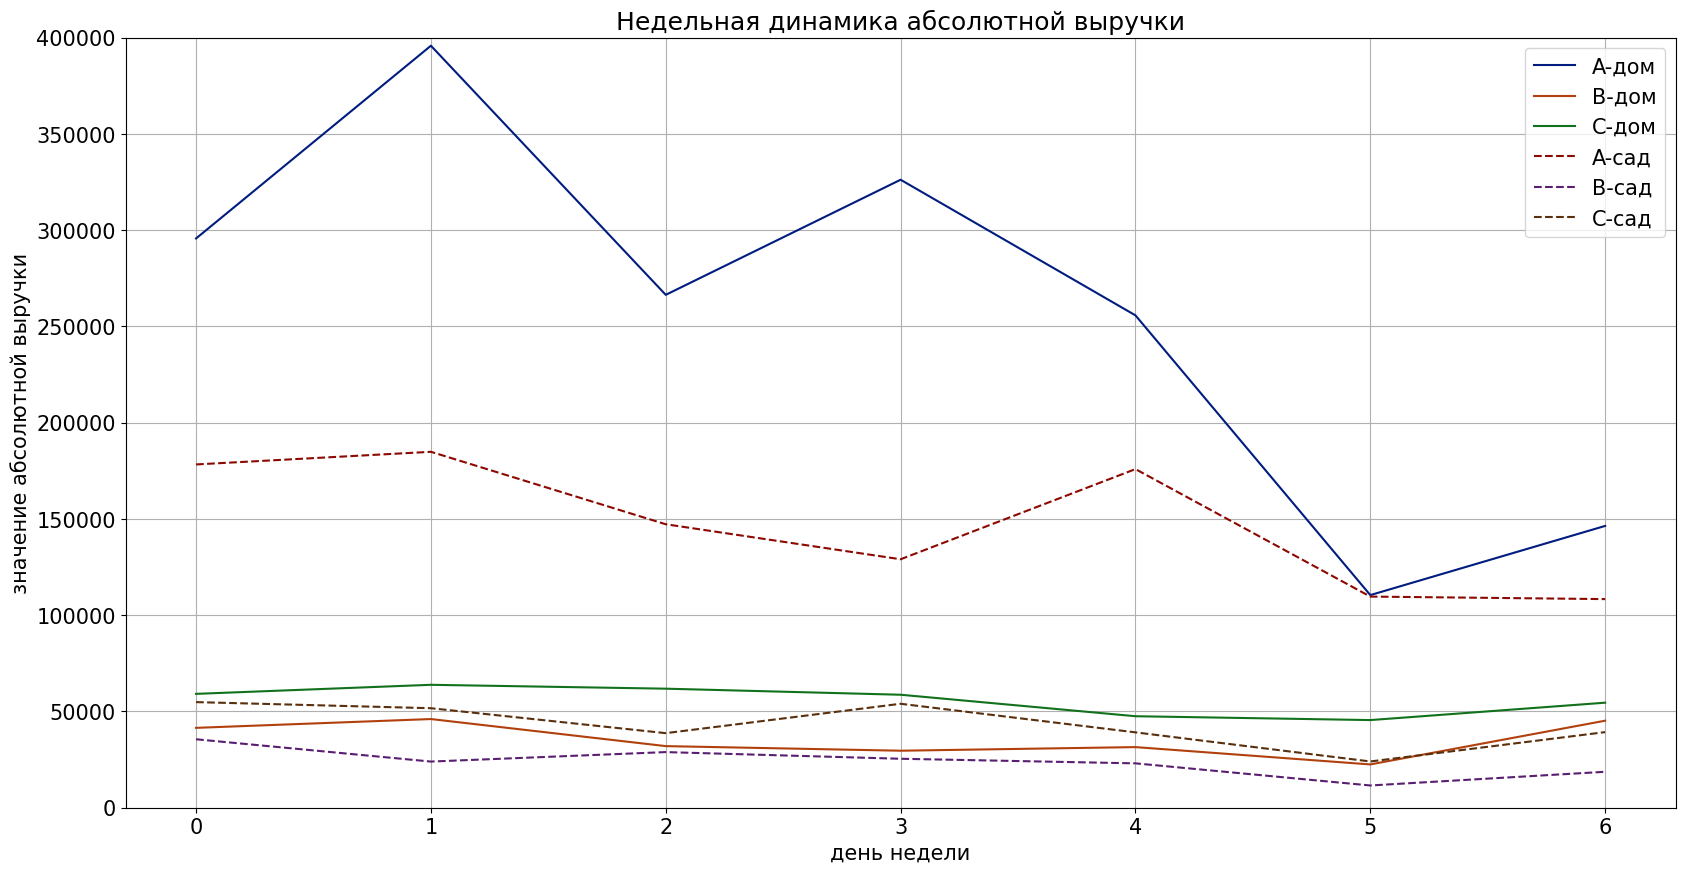

In [160]:
cluster_profit_dynamics_period ("для дома и быта",
                                "для сада и огорода",
                                'weekday',
                                'Недельная динамика абсолютной выручки',
                                'день недели', 
                                 400000)
plt.show();

При рассмотрении недельной динамики абсолютной выручки наиболее значительны колебания в сегменте A в категории 'для дома и быта'. На протяжении всей недели видна негативная тенденция с минимальными значениями в выходные дни. В остальных сегментах значения в целом стабильны на протяжении всей недели.

Рассмотрим годовую динамику сумарного количества единиц товара в различных сегментах: 

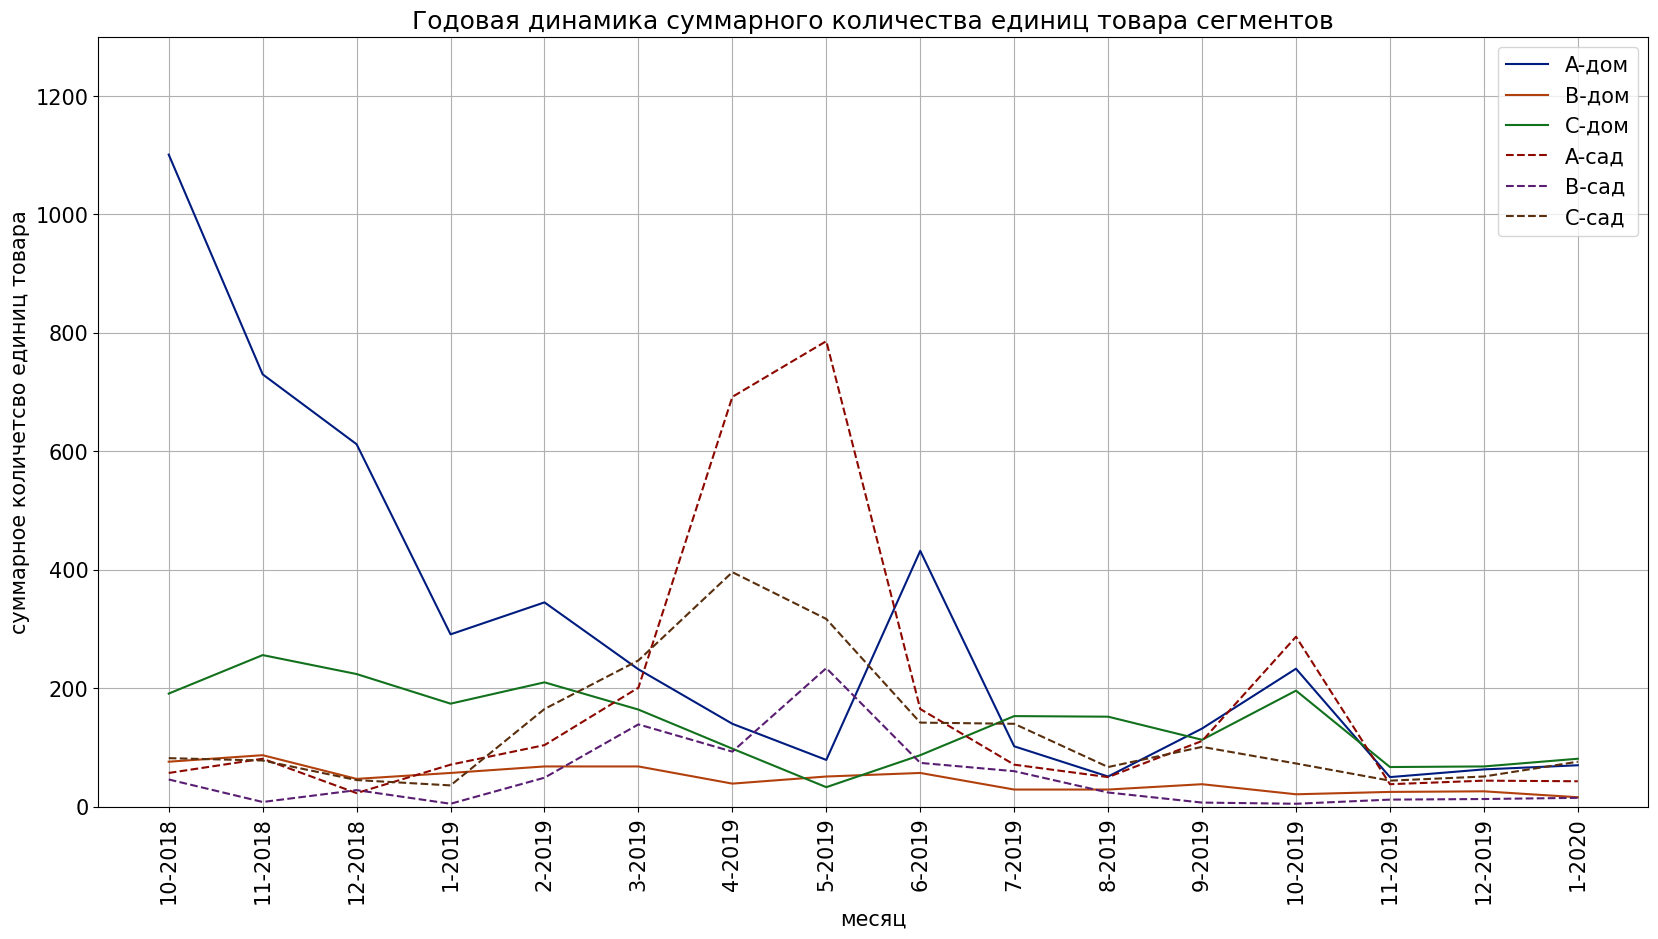

In [159]:
cluster_quantity_dynamics_annual ("для дома и быта", "для сада и огорода", 1300)
plt.show();

По годовой динамике суммарного количества единц товара выделяеются сегменты:
 A в категории 'для дома и быта';
 A в категории 'для сада и огорода';
 С в категори 'для сада и огорода';
Сегмент A в категории 'для дома и быта' имеет негативную тенденцию. В октябре 2018 года имеет наибольшее значение среди всех сегментов, но затем наблюдается быстрое снижение до мая 2019 года. В июне наблюдается пик значений, в июле уже возвращение к майским значениям. В остальной период уже значения приближаются к остальным кластерам.  
Сегмент A в категории 'для сада и огорода' в начале преиода имеет значения сходные с другими кластерами, оданако в ферале начинается быстрый рост значений, который достигает пика в мае 2019 года. После пика в мае 2019 года наблюдается снижение и стабилизация значений в корридоре до 200 единиц.
Сегмент С в категории 'для сада и огорода' в целом повторяет тендеции сегмента A, только пик наблюдается в апреле 2019 года.
 

Рассмотрим недельную динамику суммарного количества единиц товара в различных сегментах:

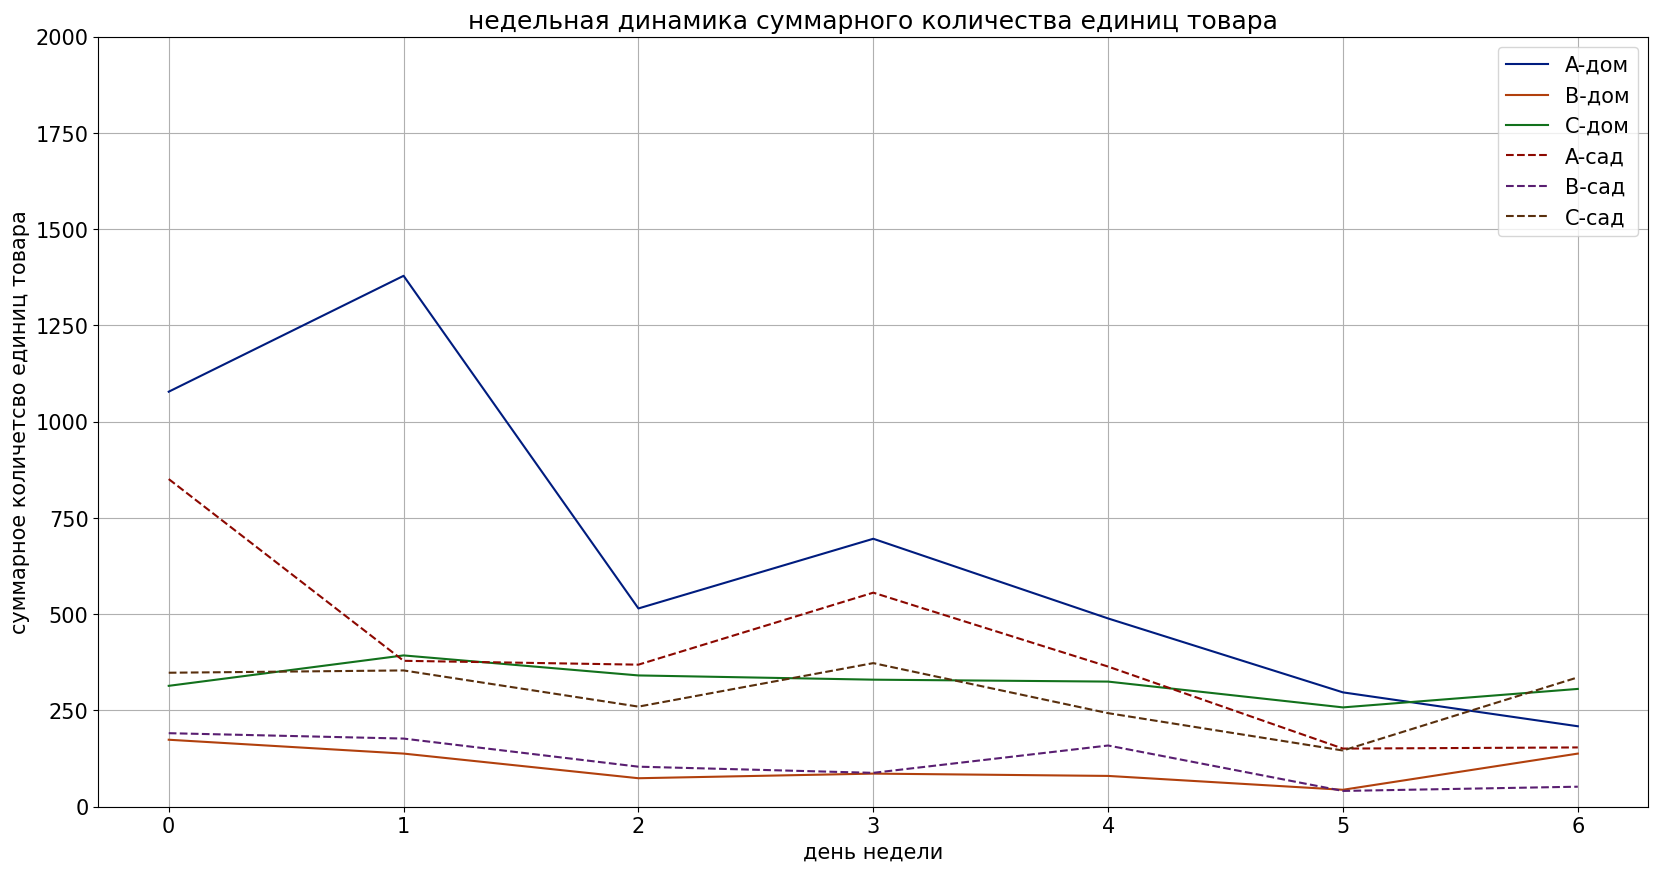

In [161]:
cluster_profit_quantity_period ('для дома и быта',
                                'для сада и огорода',
                                'weekday',
                                'недельная динамика суммарного количества единиц товара',
                                'день недели', 
                                 2000,
                                'quantity')
plt.show();

По графику недельной динамики во всех кластерах и категориях видна негоативная динамика. Наименьшее количество единиц товара  
было приобретено в субботу и воскресенье.

### Проверка гипотез

Оценим размерность сегментов клиентов:

In [147]:
sizeA = data_filt[data_filt['category'] == 'A']['customer_id'].nunique()

In [148]:
sizeB = data_filt[data_filt['category'] == 'B']['customer_id'].nunique()

In [149]:
sizeC = data_filt[data_filt['category'] == 'C']['customer_id'].nunique()

In [150]:
f'размерность сегментов A, B, C составялет соответственно: {sizeA}, {sizeB}, {sizeC} пользователей'

'размерность сегментов A, B, C составялет соответственно: 687, 319, 1424 пользователей'

In [151]:
group_id = data_filt.groupby('customer_id').agg({'category':'nunique'}).replace({1:'unique', 2:'common'})
common_id = group_id[group_id['category'] == 'common'].count()#выделим пользоватей входящих в обе группы
f'количество общих пользователей для групп: {common_id}'

'количество общих пользователей для групп: category    0\ndtype: int64'

#### Проверка гипотез о стоймости товара

Сформируем гипотезы для стоймости единицы товара в различных сегментах клиентов и проверим из соответсвенно:

Сформируем первую гипотезу:
H0 - стоймость единицы товара клиентов сегментов A и B равны;  
H1 - стоймость единицы товара сегментов A и B не равны;  
Сформируем вторую гипотезу:  
H0 - стоймость единицы товара сегментов A и C равны;  
H1 - стоймость единицы товара сегментов A и C не равны;    
Сформируем третью гипотезу:      
H0 - стоймость единицы товара сегментов B и C равны;  
H1 - стоймость единицы товара сегментов B и C не равны;


Для проверки гипотез будем использовать двухсторонний тест Манна-Уитни с поправкой Холма для множественных тестов

Зададим функцию для проверки гипотез:

In [152]:
def parametr_test (data, A, B, C, parameter):
    A = data[data['category'] == A][parameter]
    B = data[data['category'] == B][parameter]
    C = data[data['category'] == C][parameter]
    resultAB = st.mannwhitneyu(A, B)
    resultAC = st.mannwhitneyu(A, C)
    resultBC = st.mannwhitneyu(B, C)
    return resultAB, resultAC, resultBC

In [153]:
def median_parametr_test (data, A, B, C, parameter):
    A = data[data['category'] == A].groupby('customer_id',as_index = False).agg({parameter:'median'})[parameter]
    B = data[data['category'] == B].groupby('customer_id',as_index = False).agg({parameter:'median'})[parameter]
    C = data[data['category'] == C].groupby('customer_id',as_index = False).agg({parameter:'median'})[parameter]
    resultAB = st.mannwhitneyu(A, B)
    resultAC = st.mannwhitneyu(A, C)
    resultBC = st.mannwhitneyu(B, C)
    return resultAB, resultAC, resultBC

Получим результаты теста

In [154]:
results_price = parametr_test (data_filt, 'A','B','C', 'price')

Зададим цикл для проверки результатов теста

In [155]:
alpha = 0.05
n = 3
for i in range(n):
    if results_price[i].pvalue < alpha/(n-i):
        print(results_price[i].pvalue)
        print('Отвергаем нулевую гипотезу')
    else:
        print(results_price[i].pvalue)
        print('Не получилось отвергнуть нулевую гипотезу,')

9.580636678132675e-09
Отвергаем нулевую гипотезу
2.425648298256931e-50
Отвергаем нулевую гипотезу
2.5258276809484188e-12
Отвергаем нулевую гипотезу


В результате проведения проверок гипотез пришлось отвергнуть нулевую гипотезу во всех трех гипотезах - стоймость единицы товара не равны вовсех сегментах клиентов

#### Проверка гипотез о равенстве  количества товаров в заказе

Сформируем гипотезы для  количества товаров в заказе в  различных сегментах

Сформируем первую гипотезу:  
H0 - количество товаров в заказе сегментов A и B равны;  
H1 - количество товаров в заказе сегментов A и B не равны;  
Сформируем вторую гипотезу:  
H0 - количество товаров в заказе сегментов A и C равны;  
H1 - количество товаров в заказе сегментов A и C не равны;    
Сформируем третью гипотезу:      
H0 - количество товаров в заказе сегментов B и C равны;  
H1 - количество товаров в заказе сегментов B и C не равны;

Для проверки гипотез будем использовать двухсторонний тест Манна-Уитни с поправкой Холма для множественных тестов

Применим заданную функцию для проведения тестов

In [156]:
results_quantity = parametr_test (data_filt, 'A','B','C', 'quantity')

Зададим цикл для проверки сформированных гипотез

In [157]:
alpha = 0.05
n = 3
for i in range(n):
    if results_quantity[i].pvalue < alpha/(n-i):
        print(results_quantity[i].pvalue)
        print('Отвергаем нулевую гипотезу')
    else:
        print(results_quantity[i].pvalue)
        print('Не получилось отвергнуть нулевую гипотезу')

0.0008370095240761323
Отвергаем нулевую гипотезу
0.031990150504844155
Не получилось отвергнуть нулевую гипотезу
0.0556965439393187
Не получилось отвергнуть нулевую гипотезу


В результате проверки отвергаем нулевую гипотезу для первой гипотезы:
      количество товаров в заказе групп A и B;  
При проверке второй и третьей гипотезы не удалось отвергнуть нулевую гипотезу:  
количество товаров в заказе в групп A и С, B и С равно.

### Общий вывод 

В ходе предобработки данных мы подготовили даннные исходного датасета:   
    - привели данные к необходимым форматам;  
    - выделили необходимые данные в отдельные столбцы;  
    - очистили информацию по принципу "один пользователь - один заказ"  
    - убрали аномальные и подозрительные значения из данных;
В ходе исследовательского анализи данных определили следующие показатели:
    - период данных представленного датасета расположен между 1-10-2018 и 31-01-2020;
      
- определили характертеристики заказа:  
      
      - Большинство заказов, очевидно, приходится на 2019 год;  
      - всего было совершено 5550 заказов;
      - среднее количество товаров в заказе ~ 2;
      - 75 % пользователей заказали 1 едницу товара;
      - средняя цена единицы товара составляет 531;
      - минимальная цена единицы товара: 9;
      - максимальная цена единицы товара: 14917;
      - медианный чек для всего периода составляет: 191;
      
- рассмотрели динамику медианного чека в различные периоды:
     - видна общая негативная тенденция за весь период. Снижение с начала наблюдений до плато в феврале 2019 года, небольшой пик в мае 2019 года и резкое падение в ноябре 2019 года;
     - анализируя недельную динамику медианной чека нельзя выделить каких либо трендов, колебания незначительны и значения близки к медианным.
     - в суточном диапазоне низкие значения медианного чека в ночные и вечерние часы; Наибольший пик значений обнаруживается в 5 часов утра. В остальные часы колебания значений проходят в районе дневной медианы.
     
Анализируя динамику медианного чека можно увидеть негативные тенденции в годовом разрезе. В качестве рекомендаций можно предложить стимулировать пользователей приобретать больше товаров в одном заказе, предложив какие либо бонусы за это действие.

 - рассмотрели динамику выручки на пользователя в различные периоды:
   - При рассмотрении месячной динамики медианной выручки на пользователя видна общая негативная тенденция за весь период. Снижение с начала наблюдений до марта 2019 года, небольшой пик в июне 2019 года и резкое падение в ноябре 2019 года.
   - анализируя недельную динамику выручки на пользователя нельзя выделить каких либо трендов, колебания незначительны и значения близки к медианным. Небольшое снижение видно в субботу и воскресенье.
   - в суточном диапозоне низкие значения медианной выручки на рользователя, ожидаемо, в ночныые и вечерние часы; Наибольший пик значений обнаруживается в 7 часов утра. В остальные часы колебания значений проходят в районе дневной медианы.  
  
Анализируя динамику медианной выручки на пользователя можно увидеть негативные тенденции в годовом разрезе. В качестве рекомендаций можно предложить стимулировать пользователей приобретать больше товаров в одном заказе, предложив какие либо бонусы за это действие. Так же необходимо стимулировать спрос в выходные дни 

- рассмотрели абсолютные метрики - динамика абсолютной выручки:
 
   - помесячная динамика абслютной выручки также обнаруживает негативный тренд. Наибольшие значения выручки наблюдаются в начальный период с последующим колебательным снижением к концу наблюдаемого периода;
   - в недельной динамике также обнаруживается тренд на уменьшение выручки. Наибольшее значение во вторник, наименьшее в субботу;
   - часовая динамика, очевидно представлена пиками значений в дневное рабочее время, а минимальными в ночное и вечернее;
   
В отношении абсолютной выручки виден, как месячный, так и недельный негативный тренд. Трудно определить имеет ли снижение во втором полугодии сезонный характер или же это особенность только этого периода. Однако стоит обратить внимание на повышение маржинальности в осенне-зимний период.Что касается недельной динамики, необходимо увеличивать продажи или значения чека в выходные дни для преодаления отрицательного тренда.
 - рассмотрели динамику количества покупателей:
 
   - месячная динамика пользователей не показывает негативной динамики. К концу 2019 года достигает максимального значения.
   - по недельной динамике количества пользователей видна негативная тенденция к уменьшению пользователей к концу недели.
   - по дневной динамике наблюдается ожидаемая кривая количества пользователей. Минимальные значения наблюдаются в вечение часы. С 5 часов утра наблюдается быстрый рост количества пользователей, который достигает пика в 11 часов. После пика наблюдается медленное снижение к медианному значению в 17 часов.  
   
Для улучшение уже рассмотренных метрик необходимо привлечь большее количество пользовтелей в пятницу и выходные дни, согласно показателям недельной динамики количества пользователей.

Рассмотрев показатели лояльности клиентов, обнаружили, что большинство (64%) совершили не более 1 покупки. Необходимо создать или расширить программу лояльности для увеличения удержания пользователей.  

Проанализировав предсталенные наименования товаров, провели их категоризацию. По количеству товаров категории 'для дома и быта' и 'для сада и огорода' приблизительно равны. 

Рассмотрели показатели динамики метрик по категориям: 
 - анализ медианного чека в категориях: 
   - При рассмотрении годовой динамики обнаруживается негативный тренд по обеим категориям. Для категории 'для сада и огорода' видны более стабильные значения с пиком в мае 2019 года. В целом динамика медианной выручки на одного пользователя синхронна для обеих категорий. К концу 2019 года виден резкий спад до минимальных значений;
    - в недельной динамике не наблюдается резких колебаний для обеих категорий. Стоит лишь отметить провал в субботу в категории 'для дома и быта';
   - для категории 'для дома и быта' наибольший пик медианной выручки приходится на 5 часов утра. Затем снижение в корридор 600 - 800 с небольшим пиком в конце рабочего дня с дальнейшим снижением. Для категории 'для сада и огорода' наблюдается несколько пиков: в 2-3 часа, в 8 часов и 18 часов.
   
Для обеих категорий наблюдается снижение в годовом разрезе медианной выручки, особенно к концу 2019 года. Необходимо увеличить количество товаров в заказе пользователей для обеих категорий.
 - анализ динамики абсолютной выручки:
     - Для категории 'для дома и быта' наблюдается негативная динамика на всем протяжении исследуемого периода. Наибольшие значения абсолютной выручки находятся в октябре - декабре 2018 года. С января 2019 года происходит снижение до минимального значения в мае 2019 года. С июня 2019 года выручка выходит на плато и с небольшими колебаниями держится в окрестностях 100000 до конца исследуемого периода. В категории 'для сада и огорода' в 2018 году наблюдаются минимальные значения абсолютной выручки. С января 2019 года обнаруживается рост с пиком в апреле 2019 года. После пика происходит снижение до августа 2018. Далее выручка выходит на плато с незначительными колебаниями до конца исследуемого периода.
     - Для категории 'для дома и быта' наблюдается тендения к снижению выручки на протяжении всей недели. Наибольшее значение выручки в категории наблюдается во вторник, наменьшее в субботу с небольшим востановлением в воскресенье.  В категории 'для сада и огорода' так же наблюдается недельное снижение, хоть и с меньшим градиентом. Наименьшее значение так же наблюдается в субботу.
     - В категории 'для дома и быта' минимальные значения абсолютной выручки наблюдаются в ночные часы до 6 часов утра. С 7 часов наблюдается быстрый рост абсолютной выручки, который достигает пика в 13 часов. После с 14 по 16 часов наблюдется спад. В 17 часов виден последний пик за день, с последующим снижением к концу дня.  В категории 'для сада и огорода' также наблюдается минимальные значения абсолютной выручки в ночные часы до 5 часов утра.  С пяти часов утра наблюдается рост с пиком в 10 часов утра. После наблюдается снижение с колебаниями до конца дня.

Недельная динамика имеет негативную динамику для обеих категорий. Особенно видна просадка абсолютную выручки. Как и для улучшения длюх метрик необходимо увеличить маржинальность покупок в выходнве дни.

При помощи ABC-анализа провели сегментацию клиентов, разделив на три сегмента:  
  A-наиболее ценные - 80% всей выручки;
  B-средняя ценность - 15% всей выручки;
  С-низкая ценность - 5% всей выручки
  
Рассмотрели динамику в сегментах следующих метрик:
 
- Годовая динамика абсолютной выручки в сегментах: 
    -По годовой динамике абсолютной выручки  в обеих категориях выделяются сегменты A.  
    В сегменте A категории 'для дома и быта' c начала периода исследования наблюдается быстрое падение значений                 абсолютной выручки с максимального значения в октябре 2018 года до минимального значения в мае 2019 года. В июня           уже наблюдается востановительный рост и стабилизация значений в оставшемся отрезке в корридоре 50000 - 100000.  
    В сегменте A категории 'сада и огорода' значение выручки начинает расти с минимальных значений и достигает                 максимального в апреле 2019 года. После пика начинается снижение до августа 2019 года. С августа 2019 наблюдается           стаблизация значений в окрестностях 50000.
    В остальных сегментах колебания не так значительны и значения в целом стабильны.
    
В рекомендации можно включить обратить внисание на описанные сегменты A, как наиболее высокодоходные. В сегменте A         категории 'для дома и быта' необходимо увеличить маржинальность пользователей в весенние месяцы, для сглаживания           провала.  
В сегменте A категории 'для сада и огорода' наоборот наблюдается пик значений в весенние месяцы. Необходимо расширить асортимент в данной категории, который поддерживал бы спрос в другие сезоны.

   - Недельная динамика абсолютной выручки в сегментах: 
   - при рассмотрении недельной динамики абсолютной выручки наиболее значительны колебания в сегменте A в категории 'для        дома и быта'. На протяжении всей недели видна негативная тенденция с минимальными значениями в выходные дни. В              остальных сегментах значения в целом стабильны на протяжении всей недели.
   
Рекомендация для всех сегментов в недельном разрезе: необходимо привлечь больше пользователей в выходные дни(акции, промокоды, и тд) для поддержания спроса в конце недели.  

   - годовая динамика проданного суммарного количества единиц товара: 
      По годовой динамике суммарного количества единц товара выделяеются сегменты:
      A в категории 'для дома и быта';
      A в категории 'для сада и огорода';
      С в категори 'для сада и огорода';
      Сегмент A в категории 'для дома и быта' имеет негативную тенденцию. В октябре 2018 года имеет наибольшее значение           среди всех сегментов, но затем наблюдается быстрое снижение до мая 2019 года. В июне наблюдается пик значений, в июле       уже возвращение к майским значениям. В остальной период уже значения приближаются к остальным кластерам.  
      Сегмент A в категории 'для сада и огорода' в начале преиода имеет значения сходные с другими кластерами, оданако в         ферале начинается быстрый рост значений, который достигает пика в мае 2019 года. После пика в мае 2019 года                 наблюдается снижение и стабилизация значений в корридоре до 200 единиц.
      Сегмент С в категории 'для сада и огорода' в целом повторяет тендеции сегмента A, только пик наблюдается в апреле           2019 года.
      
Годовая динамика суммарного количества купленных товаров, в целом коррелирует с годовой динамикой абсолютной выручки. На графике видны те же сезонные тренды. Стоит обратить на сегменты A в обоих категориях, для преодоленния сезонных провалов(расширить асортимент, проводить акции в несезон для категории).
   
   - недельная динамика проданного суммарного количества единиц товара: 
     по графику недельной динамики во всех кластерах и категориях видна негоативная динамика. Наименьшее количество единиц      товара  было приобретено в субботу и воскресенье.

Для всех категорий и сегментов в недельном разрезе необходимо поддержать спрос в конце недели для преодалении негативного тренда. 

Для полученных сегментов сформировали следующие гипотезы: 
 1. H0 - стоймости единицы товара между разлмичными сегментами равны
    H1 - стоймости единицы товара между различными сегментами не равны
 2. H0 - количество товаров в заказе в различных сегментах равны;
    H1 - количество товаров в заказе в различных сегментах не равны;  
    
При прверке первой гипотезы не получилось принять нулевую гипотезу ни в одном из случаев.
При проверке второй гипотезы отвергнили нулевую гипотезу лишь в первом случае между сегментами A и B. В остальных случаях приняли нулевую гипотезу.

В первом случае проверка гипотез показала, что все сегменты имеют разный ценовой диапазон товаров в своих покупках. Поэтому при намерении увеличения выручки через повышение ценовой характеристики товара, необходимо отдельно разработать стратегию для всех сегментах, покупающих в своем ценовом диапазоне.

При рассмотрении гипотез о количестве товаров в заказе оказалось, что поведение клиентов в различных сегментах не так сильно различается. При проверке гипотез приняли гипотезу лишь о равенстве количества товаров в заказе в сегментах A и С. В остальных сравнениях гипотезу о равенстве пришлось отвергнуть. В целом при сходности поведения различных сегментов можно избрать одну общую стратегию для увеличения количетсва товаров в заказе.